In [1]:
import itertools
import math
import pickle
import json

import numpy as np
import seaborn as sns
from tqdm import tqdm
from scipy.stats import poisson
import pandas as pd

# Parameters

In [2]:
initial_cases = 10

# sweep over [0.0 - 1.0]  # based on travel rates
imported_cases_per_step = .5  # really, there's a cost to setting this too, if we make it part of the action space
imported_cases_per_step_range = np.arange(0.0, 1.0, 0.2)

# .97 - .98
# .97 ** (6*30 / 4) == 0.25
# .98 ** (6*30 / 4) == 0.4
#   --> credence assigned to NO vaccine in 6 months
#        strikes balance of giving a fair chance of 6 month vaccine; while not giving high chance to vaccine in 2-months
discount = 0.99

# time step: ~4 days  (1 generation period)
num_population = 1000

In [3]:
imported_cases_per_step_range

array([0. , 0.2, 0.4, 0.6, 0.8])

In [4]:
# is this really a fair form? 
# wouldn't keeping everyone home for 6 weeks have some finite cost?

# Cost of setting R
R_0 = 2.5   # 2.8? #3?  look up; depends on the place

# sweep:  [1, 3]
power = 2
power_range = np.arange(1.0, 3.0, 0.5)

# average person's annual economic contribution: $50,000?
economic_contribution_annual = 50000
economic_contribution_2_weeks = economic_contribution_annual * 2.0 / 52
cost_to_keep_half_home = num_population / 2 * economic_contribution_2_weeks

# want: cost_of_r(R_0 / 4) == cost_to_keep_half_home
# Better: how much economic loss has the US had, to keep R ~= 1
# (1/((R_0/4)**power) - 1/(R_0 ** power)) * scale_factor == cost_to_keep_half_home
# scale_factor = cost_to_keep_half_home / (1/((R_0/4)**power) - 1/(R_0 ** power))

# population of 100,000:
# R = 1 for 4 days  ~=  100 people getting sick (25 ppl / day * 4 days)
# every 20 days: 500 people sick -> 5 person dead

# cost_of_r(1.0) == cost_of_n(100) == cost of 1 death + other bad effects ?= $4,000,000
# [1/(1 ** power) - 1/(R_0 ** power)] * scale_factor == 100
# scale_factor = 100 / [1 - 1/(R_0 ** power)]

scale_factor = 100
scale_factor_range = [100, 500, 1000]

def cost_of_r(r, power=power, scale_factor=100, **kwargs):
    baseline = 1/(R_0 ** power)
    actual = 1/(r ** power)
    
    # cost_to_keep_half_home / (1/((num_population/4)**power) - 1/(R_0 ** power))
    
    if r >= R_0:
        return 0
    else:
        return (actual - baseline) * scale_factor

14
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.5 2.  2.5]


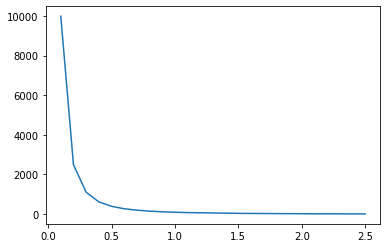

In [5]:
rs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.5, 2.0, 2.5])
costs_of_r = [cost_of_r(r) for r in rs]
sns.lineplot(x=rs, y=costs_of_r)
actions = rs
num_actions = len(actions)
print(num_actions)
print(actions)

In [6]:
cost_of_r(2.5) - cost_of_r(2.0)

-9.0

In [7]:
# Cost of N (number of cases)
# assume cost of someone getting sick is $40,000

'''fraction_need_hospital = 0.04
cost_per_hospital_visit = 50000
cost_per_death = 1e6

# cost_of_n(n) == n
# cost_of_r(1.0) == cost_of_n(100) == 100

hospital_capacity = 25 # 5% of population #  20000

death_rate_hospital = 0.25
death_rate_neglected = 0.9'''


def cost_of_n(n, **kwargs):
    if n <= 0:
        return 0
    else:
        return n
    
    '''    num_need_hospital = n * fraction_need_hospital
        num_hospital = min(num_need_hospital, hospital_capacity)
        num_neglected = num_need_hospital - num_hospital
        num_deaths = num_neglected * death_rate_neglected + num_hospital * death_rate_hospital
        
        return cost_per_hospital_visit * num_hospital + cost_per_death * num_deaths '''

297

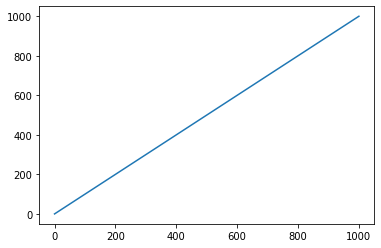

In [8]:
ns = sum([list(range(100*i, 100*(i+1), i+1)) for i in range(10)], []) + \
     [1_000]
     #sum([list(range(1000*i, 1000*(i+1), (i+1)*10)) for i in range(1, 10)], []) + \
     #sum([list(range(10000*i, 10000*(i+1), (i+1)*100)) for i in range(1, 10)], []) + \
     
# #list(range(num_population))
costs_of_n = [cost_of_n(n) for n in ns]
sns.lineplot(x=ns, y=costs_of_n)
states = ns
num_states = len(states)
num_states

In [9]:
lookup = dict([(x, i) for i in range(num_states - 1) for x in range(states[i], states[i+1])] + [(num_population, len(states) - 1)])
def bucket_state_index(new_state):
    if new_state < 0:
        raise Exception('Cannot have negative case count')
    elif new_state in lookup:
        return lookup[new_state]
    else:
        return lookup[num_population]
list(lookup.items())[-10:]

[(991, 295),
 (992, 295),
 (993, 295),
 (994, 295),
 (995, 295),
 (996, 295),
 (997, 295),
 (998, 295),
 (999, 295),
 (1000, 296)]

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [11]:
find_nearest(states, 2329)

1000

In [12]:
def expected_new_state(current_state, action, imported_cases_per_step=imported_cases_per_step, **kwargs):
    r_effective = action
    current_cases = current_state
    
    fraction_susceptible = 1 # (num_population - current_cases) / num_population
    # TODO: may need better way to bound susceptible population,
    # to account for immunity
    # One option: fraction_susceptible = 1 always, and just bound new_state by num_population

    # Better solution: keep track of how many people are susceptible NOW, based on some immunity time
    expected_new_cases = (current_cases * r_effective) * fraction_susceptible + imported_cases_per_step

    return expected_new_cases

In [13]:
expected_new_state(2330, 2.0, imported_cases_per_step=0.25)

4660.25

In [14]:
def new_state_distribution(state, action, **kwargs):
    lam = expected_new_state(state, action, **kwargs)
    # TODO: change to negative binomial; look up constant in literature for COVID
    return poisson(lam)

In [15]:
distribution = new_state_distribution(2330, 2.0)
distribution.mean(), distribution.var(), distribution.median()

(4660.5, 4660.5, 4660.0)

In [16]:
distribution.cdf(4750) - distribution.cdf(4700)

0.18443092046258014

In [17]:
def bucketed_distribution(distribution, states):
    probs = np.zeros_like(states, dtype=float)
    for state_idx in range(num_states - 1):
        low_state = states[state_idx]
        high_state = states[state_idx + 1]
        probs[state_idx] = (distribution.cdf(high_state) - distribution.cdf(low_state))
    probs[num_states - 1] = 1 - distribution.cdf(states[num_states - 1])
    return probs

In [18]:
bucket_distr = bucketed_distribution(distribution, states)
[bucket_distr[bucket_state_index(x)] for x in [4500, 4550, 4600, 4650, 4700, 4750, 4800]]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [19]:
def transition_probabilities(**kwargs):
    transition_probs = np.zeros((num_states, num_actions, num_states))

    for state_idx in tqdm(range(num_states)):
        for action_idx in range(num_actions):
            distribution = new_state_distribution(states[state_idx], actions[action_idx], **kwargs)
            bucket_distr = bucketed_distribution(distribution, states)
            transition_probs[state_idx, action_idx] = bucket_distr
            #print(len(bucket_distr))
            
    return transition_probs

In [20]:
def reward(state, action, power=power, **kwargs):
    n = state
    r_effective = action
    return -cost_of_n(n, **kwargs) - cost_of_r(r_effective, **kwargs)  # should this be cost_of_n(new_state)?

In [21]:
def step(state_idx, action_idx):
    # state: number of current cases (discretized)
    # action: value of R_effective to set (discretized)
    # return: new_state, reward
    
    distr = new_state_distribution(states[state_idx], actions[action_idx])
    new_state = distr.rvs()
    
    # TODO: change to an actual expectation
    # ensure number of infected people does not exceed entire population
    new_state = min(new_state, num_population)
    new_state_idx = bucket_state_index(new_state)  # discretized case count
    
    resulting_reward = reward(states[state_idx], actions[action_idx])
    
    return new_state_idx, resulting_reward

In [22]:
state_idx = bucket_state_index(322)
print(f'original state: {states[state_idx]}')

action_idx = 2
print(f'action: {actions[action_idx]}')

new_state_idx, resulting_reward = step(state_idx, action_idx)
print('new state: ', states[new_state_idx])
print('reward : ', resulting_reward)

original state: 320
action: 0.3
new state:  85
reward :  -1415.111111111111


## Initial Conditions

## Value Iteration

In [23]:
def select_action(state_idx, state_values, transition_probs, **kwargs):
    rewards = np.zeros_like(actions, dtype=float)
    for action_idx in range(len(actions)):
        distr = new_state_distribution(states[state_idx], actions[action_idx])
        probs = transition_probs[state_idx, action_idx] # bucketed_distribution(distr, states)
        
        step_reward = reward(states[state_idx], actions[action_idx], **kwargs) 
        # TODO: in general, this should be coupled with the probability of reaching a given state. 
        # Here, we've made them independent, because we've made the reward be a function just of the state you're in and the action you take -- not of the next state you end up reaching
        
        rewards[action_idx] = (probs * (step_reward + state_values * discount)).sum()
    best_action_idx = rewards.argmax()
    return best_action_idx, rewards[best_action_idx] # action, lifetime value of taking this action

In [24]:
def state_value(state_idx, state_values, transition_probs, **kwargs):
    best_action, max_reward = select_action(state_idx, state_values, transition_probs, **kwargs)
    return max_reward # lifetime value of taking the best action from this state

In [25]:
def save_pickle(obj, file_name):
    with open(file_name, 'w') as f:
        s = pickle.dumps(obj, protocol=0)
        f.write(s.decode('latin-1'))

In [26]:
def load_pickle(file_name):
    with open(file_name, 'r') as f:
        s = f.read()
        obj = pickle.loads(s.encode('latin-1'))
    return obj

In [27]:
def compute_best_policy():

    epsilon = 1e-3

    # Load existing transition probabilities and policy table.
    # Compute in any missing values
    # Return best policies

    try:
        transition_probs = load_pickle('transition_probs.pickle')
        print('Loaded transition_probs')
    except:
        transition_probs = {}

    try:
        policy_table = load_pickle('policy_table.pickle')
        print('Loaded policy_table')
    except:
        policy_table = {}


    for imported_cases_per_step in tqdm(imported_cases_per_step_range):
        # Try using cached transition probabilities:
        if imported_cases_per_step not in transition_probs:
            transition_probs[imported_cases_per_step] = transition_probabilities(imported_cases_per_step=imported_cases_per_step)
            save_pickle(transition_probs, 'transition_probs.pickle')
        else:
            print(f'transition_probs already computed for imported_cases_per_step = {imported_cases_per_step}')

        for power in tqdm(power_range):
            for scale_factor in tqdm(scale_factor_range):

                params_obj = {
                    'power': power,
                    'imported_cases_per_step': imported_cases_per_step,
                    'scale_factor': scale_factor
                }
                kwargs = params_obj
                params_key = tuple(params_obj.items())

                # Try using cached policy
                if params_key in params_obj:
                    print('policy already computed for {params_key}')
                    continue

                state_values = np.random.random(num_states) * -1000 - 1000
                best_action_idx = np.zeros_like(state_values)

                for i in tqdm(range(100)):
                    new_state_values = np.zeros_like(state_values, dtype=float)
                    for state_idx in range(num_states):
                        best_action_idx[state_idx], new_state_values[state_idx] = select_action(state_idx, state_values, transition_probs[imported_cases_per_step], **kwargs)
                    diffs = abs(state_values - new_state_values)
                    max_diff = diffs.max()
                    print(f'max_diff = {max_diff}')
                    state_values = new_state_values
                    if max_diff < epsilon:
                        print(f'max_diff: {max_diff} < {epsilon}')
                        break

                result_obj = {
                    'best_action_idx': best_action_idx,
                    'state_values': state_values
                }


                policy_table[params_key] = result_obj

                save_pickle(policy_table, 'policy_table.pickle')

    return policy_table

In [28]:
policy_table = compute_best_policy()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

Loaded transition_probs
Loaded policy_table
transition_probs already computed for imported_cases_per_step = 0.0





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1168.3114036992022





  2%|▏         | 2/100 [00:04<04:04,  2.49s/it]

max_diff = 838.7050456660722





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 555.799982260376





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 396.4026734161853





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 263.16890789894205





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 215.1561100110398





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 187.15523195501805





  8%|▊         | 8/100 [00:19<03:49,  2.50s/it]

max_diff = 169.73267770541224





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 159.83062823875298





 10%|█         | 10/100 [00:24<03:45,  2.51s/it]

max_diff = 155.43891616916653





 11%|█         | 11/100 [00:27<03:44,  2.52s/it]

max_diff = 123.37639067616146





 12%|█▏        | 12/100 [00:30<03:41,  2.52s/it]

max_diff = 89.0564315628917





 13%|█▎        | 13/100 [00:32<03:39,  2.52s/it]

max_diff = 59.203786821106405





 14%|█▍        | 14/100 [00:35<03:36,  2.51s/it]

max_diff = 38.38800735731638





 15%|█▌        | 15/100 [00:37<03:33,  2.51s/it]

max_diff = 24.703013691789238





 16%|█▌        | 16/100 [00:40<03:30,  2.51s/it]

max_diff = 15.553564900802485





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 9.730972563692376





 18%|█▊        | 18/100 [00:45<03:24,  2.50s/it]

max_diff = 6.035639866230667





 19%|█▉        | 19/100 [00:47<03:22,  2.50s/it]

max_diff = 3.6952183646862977





 20%|██        | 20/100 [00:50<03:19,  2.50s/it]

max_diff = 2.226581585371605





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 1.3243539342583972





 22%|██▏       | 22/100 [00:55<03:14,  2.49s/it]

max_diff = 0.7812244191709397





 23%|██▎       | 23/100 [00:57<03:12,  2.50s/it]

max_diff = 0.45788350350539986





 24%|██▍       | 24/100 [01:00<03:10,  2.50s/it]

max_diff = 0.26862085197171837





 25%|██▌       | 25/100 [01:02<03:07,  2.50s/it]

max_diff = 0.15833707806450548





 26%|██▌       | 26/100 [01:05<03:05,  2.50s/it]

max_diff = 0.09326680519097863





 27%|██▋       | 27/100 [01:07<03:01,  2.49s/it]

max_diff = 0.05474568248155265





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 0.03202716075247736





 29%|██▉       | 29/100 [01:12<02:55,  2.47s/it]

max_diff = 0.01869127225018019





 30%|███       | 30/100 [01:14<02:52,  2.47s/it]

max_diff = 0.010891066908698122





 31%|███       | 31/100 [01:17<02:50,  2.47s/it]

max_diff = 0.006339607488371257





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 0.0036878691980746225





 33%|███▎      | 33/100 [01:22<02:45,  2.47s/it]

max_diff = 0.0021444284457174945





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 0.001246621880454768


 34%|███▍      | 34/100 [01:27<02:49,  2.57s/it]


 33%|███▎      | 1/3 [01:27<02:54, 87.27s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007245790475280955
max_diff: 0.0007245790475280955 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1886.3319849049822





  2%|▏         | 2/100 [00:04<04:04,  2.49s/it]

max_diff = 974.1793229341833





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 964.4375297048409





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 954.7931544077928





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 945.2452228637148





  6%|▌         | 6/100 [00:14<03:52,  2.48s/it]

max_diff = 935.7927706350783





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 926.4348429287284





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 917.1704944994399





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 724.6885556748366





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 564.352914696392





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 536.7164389216705





 12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

max_diff = 509.8758656314749





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 484.7969292259004





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 464.49273786780395





 15%|█▌        | 15/100 [00:37<03:29,  2.47s/it]

max_diff = 447.2924804906779





 16%|█▌        | 16/100 [00:39<03:28,  2.49s/it]

max_diff = 433.23271779256174





 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

max_diff = 420.0827480406606





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 406.911549818049





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 393.88635522135155





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 381.1311981046438





 21%|██        | 21/100 [00:52<03:14,  2.46s/it]

max_diff = 367.540911000875





 22%|██▏       | 22/100 [00:54<03:11,  2.46s/it]

max_diff = 168.4820781289618





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 9.258905347041946





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 4.363298875519831





 25%|██▌       | 25/100 [01:01<03:05,  2.47s/it]

max_diff = 2.4231490522815875





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 1.4519930027399823





 27%|██▋       | 27/100 [01:06<03:01,  2.49s/it]

max_diff = 0.9005506080593477





 28%|██▊       | 28/100 [01:09<02:58,  2.49s/it]

max_diff = 0.5711050690970296





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 0.3647802126743045





 30%|███       | 30/100 [01:14<02:52,  2.47s/it]

max_diff = 0.23320913229326834





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 0.14892845704525826





 32%|███▏      | 32/100 [01:19<02:47,  2.46s/it]

max_diff = 0.09496440420480212





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 0.06047645386024669





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 0.03847703775136324





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 0.024464556330713094





 36%|███▌      | 36/100 [01:29<02:38,  2.48s/it]

max_diff = 0.015548562747426331





 37%|███▋      | 37/100 [01:31<02:36,  2.48s/it]

max_diff = 0.009879307026494644





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.006276092077314388





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 0.00398663373925956





 40%|████      | 40/100 [01:39<02:29,  2.48s/it]

max_diff = 0.0025321821940451628





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.0016082960028143134





 42%|████▏     | 42/100 [01:44<02:24,  2.49s/it]

max_diff = 0.0010214712747256272


 42%|████▏     | 42/100 [01:46<02:27,  2.54s/it]


 67%|██████▋   | 2/3 [03:13<01:33, 93.05s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.000648753381028655
max_diff: 0.000648753381028655 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1621.705829113474





  2%|▏         | 2/100 [00:04<04:03,  2.49s/it]

max_diff = 977.7572517453355





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 967.9796792278826





  4%|▍         | 4/100 [00:09<03:59,  2.50s/it]

max_diff = 958.2998824356046





  5%|▌         | 5/100 [00:12<04:08,  2.62s/it]

max_diff = 948.7168836112478





  6%|▌         | 6/100 [00:15<04:01,  2.57s/it]

max_diff = 939.229714775136





  7%|▋         | 7/100 [00:17<03:56,  2.54s/it]

max_diff = 929.8374176273846





  8%|▊         | 8/100 [00:20<03:51,  2.52s/it]

max_diff = 920.539043451111





  9%|▉         | 9/100 [00:22<03:48,  2.51s/it]

max_diff = 911.3336530166016





 10%|█         | 10/100 [00:25<03:44,  2.49s/it]

max_diff = 902.220316486435





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 893.1981133215722





 12%|█▏        | 12/100 [00:30<03:38,  2.48s/it]

max_diff = 884.2661321883552





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 875.4234708664735





 14%|█▍        | 14/100 [00:35<03:33,  2.48s/it]

max_diff = 866.6692361578062





 15%|█▌        | 15/100 [00:37<03:31,  2.48s/it]

max_diff = 858.0025437962286





 16%|█▌        | 16/100 [00:40<03:28,  2.49s/it]

max_diff = 849.4225183582676





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 840.9282931746857





 18%|█▊        | 18/100 [00:45<03:24,  2.49s/it]

max_diff = 832.5190102429387





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 824.1938201405101





 20%|██        | 20/100 [00:50<03:19,  2.50s/it]

max_diff = 815.9518819391051





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 807.7923631197154





 22%|██▏       | 22/100 [00:55<03:14,  2.50s/it]

max_diff = 799.7144394885181





 23%|██▎       | 23/100 [00:57<03:12,  2.49s/it]

max_diff = 791.7172950936329





 24%|██▍       | 24/100 [01:00<03:08,  2.49s/it]

max_diff = 783.8001221426966





 25%|██▌       | 25/100 [01:02<03:07,  2.50s/it]

max_diff = 775.9621209212673





 26%|██▌       | 26/100 [01:05<03:04,  2.49s/it]

max_diff = 768.2024997120534





 27%|██▋       | 27/100 [01:07<03:01,  2.49s/it]

max_diff = 760.5204747149328





 28%|██▊       | 28/100 [01:10<02:59,  2.49s/it]

max_diff = 752.9152699677798





 29%|██▉       | 29/100 [01:12<02:56,  2.49s/it]

max_diff = 745.3861172681027





 30%|███       | 30/100 [01:15<02:54,  2.50s/it]

max_diff = 737.9322560954206





 31%|███       | 31/100 [01:17<02:52,  2.50s/it]

max_diff = 730.552933534469





 32%|███▏      | 32/100 [01:20<02:50,  2.51s/it]

max_diff = 723.2474041991227





 33%|███▎      | 33/100 [01:22<02:48,  2.52s/it]

max_diff = 270.3621849656083





 34%|███▍      | 34/100 [01:25<02:44,  2.49s/it]

max_diff = 1.3738686871292884





 35%|███▌      | 35/100 [01:27<02:41,  2.48s/it]

max_diff = 0.9116569168181741





 36%|███▌      | 36/100 [01:29<02:39,  2.49s/it]

max_diff = 0.6073967911033833





 37%|███▋      | 37/100 [01:32<02:37,  2.49s/it]

max_diff = 0.4051011520823522





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.27032042624341557





 39%|███▉      | 39/100 [01:37<02:32,  2.49s/it]

max_diff = 0.1804401504996349





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.12046859863767168





 41%|████      | 41/100 [01:42<02:26,  2.49s/it]

max_diff = 0.08043930315761827





 42%|████▏     | 42/100 [01:44<02:24,  2.49s/it]

max_diff = 0.05371508170719608





 43%|████▎     | 43/100 [01:47<02:22,  2.50s/it]

max_diff = 0.03587113067260361





 44%|████▍     | 44/100 [01:49<02:20,  2.51s/it]

max_diff = 0.02395559237629641





 45%|████▌     | 45/100 [01:52<02:18,  2.52s/it]

max_diff = 0.01599841234201449





 46%|████▌     | 46/100 [01:55<02:16,  2.52s/it]

max_diff = 0.010684443925129017





 47%|████▋     | 47/100 [01:57<02:13,  2.52s/it]

max_diff = 0.007135593856219202





 48%|████▊     | 48/100 [02:00<02:10,  2.52s/it]

max_diff = 0.004765519966895226





 49%|████▉     | 49/100 [02:02<02:08,  2.52s/it]

max_diff = 0.0031826706108404323





 50%|█████     | 50/100 [02:05<02:06,  2.52s/it]

max_diff = 0.002125562405126402





 51%|█████     | 51/100 [02:07<02:03,  2.52s/it]

max_diff = 0.001419569001882337


 51%|█████     | 51/100 [02:10<02:05,  2.55s/it]


100%|██████████| 3/3 [05:23<00:00, 108.00s/it]

 25%|██▌       | 1/4 [05:23<16:11, 324.00s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009480679182161111
max_diff: 0.0009480679182161111 < 0.001





  1%|          | 1/100 [00:02<04:12,  2.55s/it]

max_diff = 1132.4598179420298





  2%|▏         | 2/100 [00:05<04:09,  2.54s/it]

max_diff = 840.5288095372434





  3%|▎         | 3/100 [00:07<04:07,  2.55s/it]

max_diff = 569.9389613898902





  4%|▍         | 4/100 [00:10<04:04,  2.55s/it]

max_diff = 470.0096603455281





  5%|▌         | 5/100 [00:12<04:00,  2.53s/it]

max_diff = 339.09214183004315





  6%|▌         | 6/100 [00:15<03:57,  2.53s/it]

max_diff = 243.9712251828987





  7%|▋         | 7/100 [00:17<03:54,  2.52s/it]

max_diff = 190.38603086314288





  8%|▊         | 8/100 [00:20<03:50,  2.51s/it]

max_diff = 172.78316796728632





  9%|▉         | 9/100 [00:22<03:47,  2.51s/it]

max_diff = 163.00495417870388





 10%|█         | 10/100 [00:25<03:44,  2.49s/it]

max_diff = 158.5960479463265





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 122.80757510520016





 12%|█▏        | 12/100 [00:30<03:36,  2.46s/it]

max_diff = 88.55126001548979





 13%|█▎        | 13/100 [00:32<03:33,  2.45s/it]

max_diff = 58.781692704238594





 14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]

max_diff = 38.103620735842014





 15%|█▌        | 15/100 [00:37<03:28,  2.45s/it]

max_diff = 24.504502754592068





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 15.426371662892961





 17%|█▋        | 17/100 [00:42<03:25,  2.47s/it]

max_diff = 9.649074193393062





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 5.983164549996218





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 3.661879812765619





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 2.205823321273783





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 1.311850465785028





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 0.773780567031281





 23%|██▎       | 23/100 [00:57<03:10,  2.47s/it]

max_diff = 0.4534947003903653





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 0.2660626432789286





 25%|██▌       | 25/100 [01:02<03:06,  2.48s/it]

max_diff = 0.15682733625726542





 26%|██▌       | 26/100 [01:04<03:03,  2.49s/it]

max_diff = 0.09237244150881452





 27%|██▋       | 27/100 [01:07<03:01,  2.49s/it]

max_diff = 0.054217870206230145





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 0.031717185491288546





 29%|██▉       | 29/100 [01:12<02:56,  2.49s/it]

max_diff = 0.01850991020182846





 30%|███       | 30/100 [01:14<02:54,  2.50s/it]

max_diff = 0.010785220187244704





 31%|███       | 31/100 [01:17<02:51,  2.49s/it]

max_diff = 0.006277932064222114





 32%|███▏      | 32/100 [01:19<02:49,  2.50s/it]

max_diff = 0.003651968225312885





 33%|███▎      | 33/100 [01:22<02:47,  2.50s/it]

max_diff = 0.002123544084497553





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 0.0012344779670456774


 34%|███▍      | 34/100 [01:27<02:48,  2.56s/it]


 33%|███▎      | 1/3 [01:27<02:54, 87.03s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007175193995863083
max_diff: 0.0007175193995863083 < 0.001





  1%|          | 1/100 [00:02<04:08,  2.51s/it]

max_diff = 1508.7061400666757





  2%|▏         | 2/100 [00:04<04:05,  2.50s/it]

max_diff = 978.1082348142966





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 968.3271524661532





  4%|▍         | 4/100 [00:09<03:57,  2.47s/it]

max_diff = 958.6438809414922





  5%|▌         | 5/100 [00:12<03:55,  2.47s/it]

max_diff = 949.0574421320771





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 939.566867710756





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 930.171199033648





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 920.8694870433119





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 835.7439188699664





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 579.6001867260511





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 544.3319063603976





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 516.3622937543496





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 492.82152471264453





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 473.75386527737646





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 455.85384317692296





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 440.62168815546283





 17%|█▋        | 17/100 [00:41<03:25,  2.47s/it]

max_diff = 427.4588067513869





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 414.8640419719213





 19%|█▉        | 19/100 [00:46<03:21,  2.48s/it]

max_diff = 402.2005781944772





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 389.7120037664936





 21%|██        | 21/100 [00:51<03:15,  2.48s/it]

max_diff = 377.38686342036635





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 314.08708273570846





 23%|██▎       | 23/100 [00:56<03:11,  2.49s/it]

max_diff = 12.598603704154812





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 5.060173529875101





 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

max_diff = 2.747856145384503





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 1.6353873483039933





 27%|██▋       | 27/100 [01:06<03:01,  2.48s/it]

max_diff = 1.015811344506801





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 0.6442912741731561





 29%|██▉       | 29/100 [01:11<02:55,  2.48s/it]

max_diff = 0.41244784282207547





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 0.26425498416574555





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 0.16903872759939986





 32%|███▏      | 32/100 [01:19<02:47,  2.46s/it]

max_diff = 0.107916556600685





 33%|███▎      | 33/100 [01:21<02:44,  2.46s/it]

max_diff = 0.06877998696108989





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 0.04378283355254098





 35%|███▌      | 35/100 [01:26<02:39,  2.46s/it]

max_diff = 0.027847339029904106





 36%|███▌      | 36/100 [01:29<02:36,  2.45s/it]

max_diff = 0.01770219665741024





 37%|███▋      | 37/100 [01:31<02:35,  2.46s/it]

max_diff = 0.011249153432800085





 38%|███▊      | 38/100 [01:33<02:33,  2.47s/it]

max_diff = 0.007146899613871938





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.0045400054441415705





 40%|████      | 40/100 [01:38<02:28,  2.48s/it]

max_diff = 0.002883754996219068





 41%|████      | 41/100 [01:41<02:26,  2.49s/it]

max_diff = 0.0018316295463591814





 42%|████▏     | 42/100 [01:43<02:24,  2.49s/it]

max_diff = 0.001163329920018441


 42%|████▏     | 42/100 [01:46<02:26,  2.53s/it]


 67%|██████▋   | 2/3 [03:13<01:32, 92.85s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007388555004581576
max_diff: 0.0007388555004581576 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1650.2286479454851





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 1203.4032854466116





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 1100.3619952238018





  4%|▍         | 4/100 [00:09<03:59,  2.49s/it]

max_diff = 1002.6654972640058





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 978.0464556271013





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 959.4928016027752





  7%|▋         | 7/100 [00:17<03:51,  2.48s/it]

max_diff = 942.4238978111234





  8%|▊         | 8/100 [00:19<03:48,  2.49s/it]

max_diff = 926.4043369309238





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 912.0776781836375





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 899.974704275839





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 890.0011545493307





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 880.888670288341





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 872.0720155515501





 14%|█▍        | 14/100 [00:34<03:33,  2.48s/it]

max_diff = 863.3512953960344





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 854.7177824420723





 16%|█▌        | 16/100 [00:39<03:27,  2.48s/it]

max_diff = 846.1706046176532





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 837.7088985714763





 18%|█▊        | 18/100 [00:44<03:21,  2.46s/it]

max_diff = 829.331809585763





 19%|█▉        | 19/100 [00:47<03:18,  2.45s/it]

max_diff = 821.0384914899041





 20%|██        | 20/100 [00:49<03:16,  2.46s/it]

max_diff = 812.8281065750052





 21%|██        | 21/100 [00:51<03:14,  2.46s/it]

max_diff = 804.6998255092585





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 796.6528272541655





 23%|██▎       | 23/100 [00:56<03:10,  2.47s/it]

max_diff = 788.6862989816218





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 780.7994359918084





 25%|██▌       | 25/100 [01:01<03:05,  2.47s/it]

max_diff = 772.9914416318861





 26%|██▌       | 26/100 [01:04<03:03,  2.47s/it]

max_diff = 765.2615272155672





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 757.6089119434109





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 750.0328228239741





 29%|██▉       | 29/100 [01:11<02:56,  2.48s/it]

max_diff = 742.5324945957364





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 735.1071696497784





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 727.7560979532791





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 715.2566302632877





 33%|███▎      | 33/100 [01:21<02:46,  2.49s/it]

max_diff = 1.8662714660640631





 34%|███▍      | 34/100 [01:24<02:44,  2.50s/it]

max_diff = 1.2390925345862343





 35%|███▌      | 35/100 [01:26<02:42,  2.50s/it]

max_diff = 0.8229237550767721





 36%|███▌      | 36/100 [01:29<02:39,  2.50s/it]

max_diff = 0.548553497526882





 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

max_diff = 0.36592626091078273





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.24420835616911063





 39%|███▉      | 39/100 [01:36<02:31,  2.49s/it]

max_diff = 0.1630222390012932





 40%|████      | 40/100 [01:39<02:30,  2.50s/it]

max_diff = 0.10884474123304244





 41%|████      | 41/100 [01:41<02:27,  2.51s/it]

max_diff = 0.07267989648971707





 42%|████▏     | 42/100 [01:44<02:25,  2.51s/it]

max_diff = 0.048534434601606335





 43%|████▎     | 43/100 [01:46<02:22,  2.51s/it]

max_diff = 0.032411835203674855





 44%|████▍     | 44/100 [01:49<02:20,  2.51s/it]

max_diff = 0.02164554265254992





 45%|████▌     | 45/100 [01:51<02:17,  2.50s/it]

max_diff = 0.0144557398998586





 46%|████▌     | 46/100 [01:54<02:14,  2.49s/it]

max_diff = 0.009654205376136815





 47%|████▋     | 47/100 [01:56<02:11,  2.48s/it]

max_diff = 0.006447561034292448





 48%|████▊     | 48/100 [01:59<02:08,  2.48s/it]

max_diff = 0.004306020447984338





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.002875793994462583





 50%|█████     | 50/100 [02:04<02:03,  2.48s/it]

max_diff = 0.0019206141187169123





 51%|█████     | 51/100 [02:06<02:01,  2.49s/it]

max_diff = 0.0012826934362237807


 51%|█████     | 51/100 [02:09<02:04,  2.53s/it]


100%|██████████| 3/3 [05:22<00:00, 107.55s/it]

 50%|█████     | 2/4 [10:46<10:47, 323.60s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.000856654871313367
max_diff: 0.000856654871313367 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1932.8898072021548





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 849.8981970921059





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 524.6098530585068





  4%|▍         | 4/100 [00:09<03:57,  2.47s/it]

max_diff = 362.35053645084054





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 283.86624024096





  6%|▌         | 6/100 [00:14<03:52,  2.48s/it]

max_diff = 235.18380059622245





  7%|▋         | 7/100 [00:17<03:50,  2.47s/it]

max_diff = 205.0226868360778





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 185.8032603372235





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 175.0076253642369





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 170.07246627304903





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 135.45386878088175





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 95.50715203868549





 13%|█▎        | 13/100 [00:32<03:36,  2.49s/it]

max_diff = 64.58147370976258





 14%|█▍        | 14/100 [00:34<03:34,  2.49s/it]

max_diff = 41.70939535092111





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 26.912347639770815





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 16.97157377439453





 17%|█▋        | 17/100 [00:42<03:26,  2.48s/it]

max_diff = 10.63563973771943





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 6.612819775789831





 19%|█▉        | 19/100 [00:47<03:21,  2.48s/it]

max_diff = 4.057094543916719





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 2.454414547014494





 21%|██        | 21/100 [00:52<03:14,  2.47s/it]

max_diff = 1.4618942711431373





 22%|██▏       | 22/100 [00:54<03:12,  2.46s/it]

max_diff = 0.8631341693289869





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 0.5062941698652139





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 0.2967636357216179





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 0.17483890390303714





 26%|██▌       | 26/100 [01:04<03:01,  2.46s/it]

max_diff = 0.10302051418329938





 27%|██▋       | 27/100 [01:06<02:59,  2.45s/it]

max_diff = 0.060506687235829304





 28%|██▊       | 28/100 [01:09<02:56,  2.45s/it]

max_diff = 0.03541532675808412





 29%|██▉       | 29/100 [01:11<02:54,  2.46s/it]

max_diff = 0.02067590657952678





 30%|███       | 30/100 [01:14<02:51,  2.46s/it]

max_diff = 0.012050236148752447





 31%|███       | 31/100 [01:16<02:49,  2.46s/it]

max_diff = 0.007015373612375697





 32%|███▏      | 32/100 [01:19<02:47,  2.46s/it]

max_diff = 0.004081352471985156





 33%|███▎      | 33/100 [01:21<02:44,  2.46s/it]

max_diff = 0.0023733712987450417





 34%|███▍      | 34/100 [01:23<02:42,  2.46s/it]

max_diff = 0.0013797651163258706


 34%|███▍      | 34/100 [01:26<02:47,  2.54s/it]


 33%|███▎      | 1/3 [01:26<02:52, 86.47s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008019856686587445
max_diff: 0.0008019856686587445 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1909.7914671055346





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 1013.3578753718284





  3%|▎         | 3/100 [00:07<03:58,  2.46s/it]

max_diff = 967.3061208795125





  4%|▍         | 4/100 [00:09<03:56,  2.46s/it]

max_diff = 952.5244479240046





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 942.999203444765





  6%|▌         | 6/100 [00:14<03:53,  2.48s/it]

max_diff = 933.5692114103167





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 924.2335192962128





  8%|▊         | 8/100 [00:19<03:48,  2.49s/it]

max_diff = 851.9718114721836





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 593.9488943781125





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 561.1511656168532





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 533.2683016534775





 12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

max_diff = 507.6429691482699





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 483.64419170577094





 14%|█▍        | 14/100 [00:34<03:32,  2.48s/it]

max_diff = 463.3813255367113





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 446.58380212475095





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 432.9908283979512





 17%|█▋        | 17/100 [00:42<03:24,  2.46s/it]

max_diff = 420.22031014098684





 18%|█▊        | 18/100 [00:44<03:21,  2.46s/it]

max_diff = 407.3892495058153





 19%|█▉        | 19/100 [00:47<03:20,  2.47s/it]

max_diff = 394.607333492364





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 382.05102639172947





 21%|██        | 21/100 [00:51<03:15,  2.47s/it]

max_diff = 368.4962883808985





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 156.8935197345072





 23%|██▎       | 23/100 [00:56<03:11,  2.48s/it]

max_diff = 8.420316943524085





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 4.051749457170445





 25%|██▌       | 25/100 [01:01<03:05,  2.48s/it]

max_diff = 2.2692623833645484





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 1.36731350665832





 27%|██▋       | 27/100 [01:06<03:00,  2.48s/it]

max_diff = 0.8500298382095934





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 0.5399148115138814





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 0.3449270576093113





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 0.22047366881270136





 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

max_diff = 0.1407572156349488





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 0.08973265855456702





 33%|███▎      | 33/100 [01:21<02:45,  2.48s/it]

max_diff = 0.057134610611683456





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 0.03634644596786529





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 0.023108040519218775





 36%|███▌      | 36/100 [01:29<02:37,  2.47s/it]

max_diff = 0.014685675452710711





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 0.009330743110695039





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 0.005927483611230855





 39%|███▉      | 39/100 [01:36<02:30,  2.48s/it]

max_diff = 0.0037651475013262825





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 0.0023914828270790167





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.0015189246641966747


 41%|████      | 41/100 [01:43<02:29,  2.54s/it]


 67%|██████▋   | 2/3 [03:10<01:31, 91.72s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009647063507145504
max_diff: 0.0009647063507145504 < 0.001





  1%|          | 1/100 [00:02<04:02,  2.45s/it]

max_diff = 1990.465995723684





  2%|▏         | 2/100 [00:04<04:00,  2.45s/it]

max_diff = 1208.9917464357254





  3%|▎         | 3/100 [00:07<03:58,  2.46s/it]

max_diff = 1111.8892717927283





  4%|▍         | 4/100 [00:09<03:55,  2.46s/it]

max_diff = 1011.0690117721379





  5%|▌         | 5/100 [00:12<03:53,  2.46s/it]

max_diff = 981.9522845054498





  6%|▌         | 6/100 [00:14<03:51,  2.46s/it]

max_diff = 963.4064907978081





  7%|▋         | 7/100 [00:17<03:48,  2.46s/it]

max_diff = 946.8433065063873





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 929.9893882456818





  9%|▉         | 9/100 [00:22<03:45,  2.47s/it]

max_diff = 914.5210057395561





 10%|█         | 10/100 [00:24<03:42,  2.48s/it]

max_diff = 900.9976149044269





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 889.6090359721129





 12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

max_diff = 880.2442165993489





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 871.4322203786651





 14%|█▍        | 14/100 [00:34<03:35,  2.50s/it]

max_diff = 862.7178981748784





 15%|█▌        | 15/100 [00:37<03:32,  2.50s/it]

max_diff = 854.090719193131





 16%|█▌        | 16/100 [00:39<03:30,  2.50s/it]

max_diff = 845.5498120011962





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 837.0943138811872





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 828.7233707423802





 19%|█▉        | 19/100 [00:47<03:22,  2.50s/it]

max_diff = 820.4361370349507





 20%|██        | 20/100 [00:49<03:19,  2.49s/it]

max_diff = 812.2317756646007





 21%|██        | 21/100 [00:52<03:16,  2.48s/it]

max_diff = 804.1094579079581





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 796.0683633288754





 23%|██▎       | 23/100 [00:57<03:12,  2.50s/it]

max_diff = 788.1076796955895





 24%|██▍       | 24/100 [00:59<03:10,  2.50s/it]

max_diff = 780.2266028986305





 25%|██▌       | 25/100 [01:02<03:07,  2.50s/it]

max_diff = 772.4243368696443





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 764.7000935009492





 27%|██▋       | 27/100 [01:07<03:02,  2.50s/it]

max_diff = 757.0530925659368





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 749.4825616402777





 29%|██▉       | 29/100 [01:12<02:56,  2.48s/it]

max_diff = 741.9877360238752





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 734.567858663635





 31%|███       | 31/100 [01:17<02:51,  2.49s/it]

max_diff = 727.2221800769985





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 662.4347414409276





 33%|███▎      | 33/100 [01:22<02:46,  2.48s/it]

max_diff = 1.853810047814477





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 1.231054786225286





 35%|███▌      | 35/100 [01:27<02:41,  2.49s/it]

max_diff = 0.8177087002295593





 36%|███▌      | 36/100 [01:29<02:39,  2.49s/it]

max_diff = 0.5451133312053571





 37%|███▋      | 37/100 [01:32<02:36,  2.49s/it]

max_diff = 0.36364635159043246





 38%|███▊      | 38/100 [01:34<02:35,  2.51s/it]

max_diff = 0.24269301705862745





 39%|███▉      | 39/100 [01:37<02:33,  2.51s/it]

max_diff = 0.16201324907160597





 40%|████      | 40/100 [01:39<02:30,  2.51s/it]

max_diff = 0.1081721449700126





 41%|████      | 41/100 [01:42<02:28,  2.51s/it]

max_diff = 0.07223122486175271





 42%|████▏     | 42/100 [01:44<02:25,  2.50s/it]

max_diff = 0.048235005378955975





 43%|████▎     | 43/100 [01:47<02:22,  2.50s/it]

max_diff = 0.03221195063451887





 44%|████▍     | 44/100 [01:49<02:19,  2.49s/it]

max_diff = 0.021512086401344277





 45%|████▌     | 45/100 [01:52<02:17,  2.51s/it]

max_diff = 0.014366626051923959





 46%|████▌     | 46/100 [01:54<02:15,  2.51s/it]

max_diff = 0.009594696683052462





 47%|████▋     | 47/100 [01:57<02:12,  2.51s/it]

max_diff = 0.006407820492313476





 48%|████▊     | 48/100 [01:59<02:10,  2.51s/it]

max_diff = 0.004279480595869245





 49%|████▉     | 49/100 [02:02<02:07,  2.50s/it]

max_diff = 0.0028580696452991106





 50%|█████     | 50/100 [02:04<02:05,  2.51s/it]

max_diff = 0.0019087769906036556





 51%|█████     | 51/100 [02:07<02:02,  2.51s/it]

max_diff = 0.0012747880100505427


 51%|█████     | 51/100 [02:09<02:04,  2.54s/it]


100%|██████████| 3/3 [05:20<00:00, 106.68s/it]

 75%|███████▌  | 3/4 [16:06<05:22, 322.54s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008513752109138295
max_diff: 0.0008513752109138295 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1649.5508494442524





  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

max_diff = 842.1776752590717





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 571.6410757902631





  4%|▍         | 4/100 [00:09<03:59,  2.49s/it]

max_diff = 472.7400121205874





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 340.62292665221275





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 274.34737077551836





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 230.2645428956057





  8%|▊         | 8/100 [00:19<03:50,  2.50s/it]

max_diff = 186.89358306326903





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 156.7086412821609





 10%|█         | 10/100 [00:24<03:44,  2.49s/it]

max_diff = 151.32148202103326





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 125.13777470938385





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 90.62384388520513





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 60.631578950769836





 14%|█▍        | 14/100 [00:34<03:33,  2.49s/it]

max_diff = 39.350769378012046





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 25.383969307689767





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 15.996754733196212





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 10.02070875055324





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 6.221837714670073





 19%|█▉        | 19/100 [00:47<03:19,  2.47s/it]

max_diff = 3.812828006674863





 20%|██        | 20/100 [00:49<03:17,  2.46s/it]

max_diff = 2.300444528128537





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 1.3689779213254951





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 0.8078185937620219





 23%|██▎       | 23/100 [00:57<03:10,  2.47s/it]

max_diff = 0.4735708097114184





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 0.2777675031884428





 25%|██▌       | 25/100 [01:01<03:05,  2.47s/it]

max_diff = 0.16373594775814126





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 0.09646539303594182





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 0.05663345753237081





 28%|██▊       | 28/100 [01:09<02:58,  2.47s/it]

max_diff = 0.03313586149124603





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 0.01933997266314691





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 0.011269667974374897





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 0.0065602152772044064





 32%|███▏      | 32/100 [01:19<02:48,  2.47s/it]

max_diff = 0.0038162847613421036





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 0.002219130818048143





 34%|███▍      | 34/100 [01:24<02:42,  2.46s/it]

max_diff = 0.0012900602032459574


 34%|███▍      | 34/100 [01:26<02:48,  2.55s/it]


 33%|███▎      | 1/3 [01:26<02:53, 86.68s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007498311806557467
max_diff: 0.0007498311806557467 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1761.436499655411





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 1103.0818979747323





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 1003.4593316104401





  4%|▍         | 4/100 [00:09<03:56,  2.46s/it]

max_diff = 952.6076174709051





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 943.0815412961965





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 933.6507258832344





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 924.3142186244013





  8%|▊         | 8/100 [00:19<03:46,  2.46s/it]

max_diff = 841.1467245401072





  9%|▉         | 9/100 [00:22<03:43,  2.46s/it]

max_diff = 591.1843689170582





 10%|█         | 10/100 [00:24<03:41,  2.46s/it]

max_diff = 561.8098792040291





 11%|█         | 11/100 [00:27<03:38,  2.46s/it]

max_diff = 533.6647916177644





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 507.0756077598053





 13%|█▎        | 13/100 [00:32<03:33,  2.46s/it]

max_diff = 482.9504942171334





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 462.201315235161





 15%|█▌        | 15/100 [00:36<03:29,  2.47s/it]

max_diff = 445.22528568607777





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 431.63851247507773





 17%|█▋        | 17/100 [00:41<03:25,  2.47s/it]

max_diff = 418.91267534200597





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 406.1227994392466





 19%|█▉        | 19/100 [00:46<03:20,  2.48s/it]

max_diff = 393.4294545586181





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 380.9466826194439





 21%|██        | 21/100 [00:51<03:15,  2.47s/it]

max_diff = 367.70618426444526





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 182.73079796811908





 23%|██▎       | 23/100 [00:56<03:10,  2.48s/it]

max_diff = 10.873570197309164





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 5.202551163301905





 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

max_diff = 2.9443119969564577





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 1.7882822003375622





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 1.126684447963271





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 0.7200100894096977





 29%|██▉       | 29/100 [01:11<02:54,  2.46s/it]

max_diff = 0.46373419182964426





 30%|███       | 30/100 [01:14<02:52,  2.47s/it]

max_diff = 0.2984011805638147





 31%|███       | 31/100 [01:16<02:50,  2.46s/it]

max_diff = 0.19144141166543704





 32%|███▏      | 32/100 [01:18<02:47,  2.47s/it]

max_diff = 0.12245449143301812





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 0.07814245149347698





 34%|███▍      | 34/100 [01:23<02:43,  2.47s/it]

max_diff = 0.04978169073910976





 35%|███▌      | 35/100 [01:26<02:41,  2.48s/it]

max_diff = 0.031678386900239275





 36%|███▌      | 36/100 [01:28<02:38,  2.48s/it]

max_diff = 0.020143710215052124





 37%|███▋      | 37/100 [01:31<02:36,  2.48s/it]

max_diff = 0.012803082805476151





 38%|███▊      | 38/100 [01:33<02:33,  2.48s/it]

max_diff = 0.008135108444548678





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 0.005168130695892614





 40%|████      | 40/100 [01:38<02:28,  2.48s/it]

max_diff = 0.0032828789480845444





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.002085192243612255





 42%|████▏     | 42/100 [01:43<02:23,  2.48s/it]

max_diff = 0.0013243986359157134


 42%|████▏     | 42/100 [01:46<02:26,  2.53s/it]


 67%|██████▋   | 2/3 [03:12<01:32, 92.56s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008411624366999604
max_diff: 0.0008411624366999604 < 0.001





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1900.9967281934369





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 975.8995622523644





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 966.1405661115327





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 956.479160450418





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 946.9143688459135





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 937.4452251574548





  7%|▋         | 7/100 [00:17<03:51,  2.48s/it]

max_diff = 928.0707729058804





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 918.7900651768214





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 909.6021645250548





 10%|█         | 10/100 [00:24<03:44,  2.50s/it]

max_diff = 900.5061428798053





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 891.501081451006





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 882.5860706364947





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 873.7602099301312





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 865.0226078308297





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 856.3723817525206





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 847.8086579349965





 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

max_diff = 839.3305713556474





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 830.9372656420928





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 822.6278929856744





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 814.401614055816





 21%|██        | 21/100 [00:52<03:16,  2.49s/it]

max_diff = 806.2575979152607





 22%|██▏       | 22/100 [00:54<03:13,  2.49s/it]

max_diff = 798.1950219361061





 23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]

max_diff = 790.213071716742





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 782.3109409995741





 25%|██▌       | 25/100 [01:02<03:06,  2.48s/it]

max_diff = 774.4878315895803





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 766.7429532736824





 27%|██▋       | 27/100 [01:07<03:01,  2.48s/it]

max_diff = 759.0755237409467





 28%|██▊       | 28/100 [01:09<02:59,  2.50s/it]

max_diff = 751.4847685035311





 29%|██▉       | 29/100 [01:12<02:57,  2.50s/it]

max_diff = 743.9699208184975





 30%|███       | 30/100 [01:14<02:54,  2.50s/it]

max_diff = 736.5302216103119





 31%|███       | 31/100 [01:17<02:52,  2.50s/it]

max_diff = 729.1649193942103





 32%|███▏      | 32/100 [01:19<02:49,  2.50s/it]

max_diff = 721.8732702002671





 33%|███▎      | 33/100 [01:22<02:48,  2.51s/it]

max_diff = 134.60605869159554





 34%|███▍      | 34/100 [01:24<02:45,  2.51s/it]

max_diff = 1.2783006031932018





 35%|███▌      | 35/100 [01:27<02:42,  2.50s/it]

max_diff = 0.848786649399699





 36%|███▌      | 36/100 [01:29<02:39,  2.50s/it]

max_diff = 0.5657908554421738





 37%|███▋      | 37/100 [01:32<02:37,  2.50s/it]

max_diff = 0.3774241417158919





 38%|███▊      | 38/100 [01:34<02:35,  2.51s/it]

max_diff = 0.2518814440409187





 39%|███▉      | 39/100 [01:37<02:32,  2.49s/it]

max_diff = 0.16814434274783707





 40%|████      | 40/100 [01:39<02:29,  2.50s/it]

max_diff = 0.11226456909571425





 41%|████      | 41/100 [01:42<02:27,  2.49s/it]

max_diff = 0.07496343469028943





 42%|████▏     | 42/100 [01:44<02:24,  2.49s/it]

max_diff = 0.050059337703714846





 43%|████▎     | 43/100 [01:47<02:21,  2.49s/it]

max_diff = 0.03343017999213771





 44%|████▍     | 44/100 [01:49<02:18,  2.48s/it]

max_diff = 0.022325621172058163





 45%|████▌     | 45/100 [01:51<02:16,  2.47s/it]

max_diff = 0.014909922505466966





 46%|████▌     | 46/100 [01:54<02:13,  2.48s/it]

max_diff = 0.009957529160601553





 47%|████▋     | 47/100 [01:56<02:11,  2.48s/it]

max_diff = 0.006650135743257124





 48%|████▊     | 48/100 [01:59<02:09,  2.48s/it]

max_diff = 0.004441310466063442





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.0029661479966307525





 50%|█████     | 50/100 [02:04<02:03,  2.48s/it]

max_diff = 0.0019809575023828074





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.001322994128713617


 51%|█████     | 51/100 [02:09<02:04,  2.54s/it]


100%|██████████| 3/3 [05:22<00:00, 107.44s/it]

  0%|          | 0/297 [00:00<?, ?it/s]

max_diff = 0.000883569930010708
max_diff: 0.000883569930010708 < 0.001



100%|██████████| 297/297 [04:40<00:00,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:02<04:04,  2.46s/it]

max_diff = 1520.4158110592762





  2%|▏         | 2/100 [00:04<04:01,  2.46s/it]

max_diff = 841.372479652322





  3%|▎         | 3/100 [00:07<03:58,  2.46s/it]

max_diff = 570.4253099624093





  4%|▍         | 4/100 [00:09<03:56,  2.47s/it]

max_diff = 471.2569688789208





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 340.1655107128404





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 270.8712286645505





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 228.46096701736133





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 184.3674971660639





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 166.76137724011232





 10%|█         | 10/100 [00:24<03:42,  2.48s/it]

max_diff = 159.6261078406569





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 156.4691220333798





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 118.87002751805721





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 89.59124444456393





 14%|█▍        | 14/100 [00:34<03:30,  2.45s/it]

max_diff = 62.89563361758246





 15%|█▌        | 15/100 [00:37<03:28,  2.46s/it]

max_diff = 42.642865437894216





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 29.064678627067224





 17%|█▋        | 17/100 [00:41<03:23,  2.46s/it]

max_diff = 19.46139199607751





 18%|█▊        | 18/100 [00:44<03:21,  2.45s/it]

max_diff = 12.963930525881551





 19%|█▉        | 19/100 [00:46<03:18,  2.45s/it]

max_diff = 8.604540152648951





 20%|██        | 20/100 [00:49<03:16,  2.45s/it]

max_diff = 5.68565834311903





 21%|██        | 21/100 [00:51<03:14,  2.46s/it]

max_diff = 3.72013243197307





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 2.4127156505801395





 23%|██▎       | 23/100 [00:56<03:10,  2.48s/it]

max_diff = 1.551060046927887





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 0.9907537262761252





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 0.6323360731939829





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 0.40229805600665713





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 0.2566007191580866





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 0.16460369274682307





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 0.10606112323966954





 30%|███       | 30/100 [01:14<02:52,  2.46s/it]

max_diff = 0.06850474508883053





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 0.044293184239904804





 32%|███▏      | 32/100 [01:18<02:47,  2.47s/it]

max_diff = 0.02864905956448638





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 0.0185319273832647





 34%|███▍      | 34/100 [01:23<02:42,  2.47s/it]

max_diff = 0.011987448864601902





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 0.007753884984595061





 36%|███▌      | 36/100 [01:28<02:37,  2.47s/it]

max_diff = 0.005015325868043874





 37%|███▋      | 37/100 [01:31<02:34,  2.46s/it]

max_diff = 0.0032439144915770157





 38%|███▊      | 38/100 [01:33<02:32,  2.46s/it]

max_diff = 0.0020981335937904078





 39%|███▉      | 39/100 [01:36<02:30,  2.46s/it]

max_diff = 0.001357040052425873


 39%|███▉      | 39/100 [01:38<02:34,  2.53s/it]


 33%|███▎      | 1/3 [01:38<03:17, 98.69s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008777069551797467
max_diff: 0.0008777069551797467 < 0.001





  1%|          | 1/100 [00:02<04:13,  2.56s/it]

max_diff = 1772.46739006503





  2%|▏         | 2/100 [00:05<04:07,  2.53s/it]

max_diff = 1040.684262331416





  3%|▎         | 3/100 [00:07<04:03,  2.51s/it]

max_diff = 962.0302617143784





  4%|▍         | 4/100 [00:09<03:59,  2.49s/it]

max_diff = 952.4099590972346





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 942.885859506262





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 933.4570009111994





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 924.1224309020881





  8%|▊         | 8/100 [00:19<03:47,  2.48s/it]

max_diff = 870.2830129073336





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 587.4473354813636





 10%|█         | 10/100 [00:24<03:42,  2.48s/it]

max_diff = 552.2349873352523





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 527.7365403079584





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 505.1762722654221





 13%|█▎        | 13/100 [00:32<03:35,  2.47s/it]

max_diff = 484.2077019707158





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 464.8816587445126





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 448.5049187921195





 16%|█▌        | 16/100 [00:39<03:29,  2.49s/it]

max_diff = 435.3062175230334





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 423.06190379216787





 18%|█▊        | 18/100 [00:44<03:25,  2.50s/it]

max_diff = 410.9475292109364





 19%|█▉        | 19/100 [00:47<03:22,  2.50s/it]

max_diff = 398.9224519130021





 20%|██        | 20/100 [00:49<03:19,  2.49s/it]

max_diff = 387.1897619156025





 21%|██        | 21/100 [00:52<03:16,  2.49s/it]

max_diff = 375.6741443857645





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 363.02368619576373





 23%|██▎       | 23/100 [00:57<03:10,  2.47s/it]

max_diff = 162.60214438297407





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 13.008091935324046





 25%|██▌       | 25/100 [01:01<03:04,  2.47s/it]

max_diff = 6.635834245567821





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 3.820221808664428





 27%|██▋       | 27/100 [01:06<02:59,  2.46s/it]

max_diff = 2.301900490967455





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 1.42513222837988





 29%|██▉       | 29/100 [01:11<02:56,  2.48s/it]

max_diff = 0.8968606097914744





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 0.5705756134066178





 31%|███       | 31/100 [01:16<02:49,  2.46s/it]

max_diff = 0.3665302828885615





 32%|███▏      | 32/100 [01:19<02:47,  2.46s/it]

max_diff = 0.23658757970224542





 33%|███▎      | 33/100 [01:21<02:44,  2.46s/it]

max_diff = 0.1531200661920593





 34%|███▍      | 34/100 [01:24<02:42,  2.46s/it]

max_diff = 0.09926272861048346





 35%|███▌      | 35/100 [01:26<02:39,  2.46s/it]

max_diff = 0.06441428374091629





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 0.04182657625096908





 37%|███▋      | 37/100 [01:31<02:36,  2.48s/it]

max_diff = 0.027170206310984213





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 0.017653863125815406





 39%|███▉      | 39/100 [01:36<02:31,  2.49s/it]

max_diff = 0.011472361147752963





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.007456022525730077





 41%|████      | 41/100 [01:41<02:27,  2.50s/it]

max_diff = 0.004846044934311067





 42%|████▏     | 42/100 [01:44<02:25,  2.50s/it]

max_diff = 0.003149805932480376





 43%|████▎     | 43/100 [01:46<02:22,  2.50s/it]

max_diff = 0.0020473412641877076





 44%|████▍     | 44/100 [01:49<02:20,  2.50s/it]

max_diff = 0.0013307699500728631


 44%|████▍     | 44/100 [01:51<02:22,  2.54s/it]


 67%|██████▋   | 2/3 [03:30<01:42, 102.56s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008650070958537981
max_diff: 0.0008650070958537981 < 0.001





  1%|          | 1/100 [00:02<04:09,  2.52s/it]

max_diff = 1472.1630408805422





  2%|▏         | 2/100 [00:05<04:06,  2.51s/it]

max_diff = 975.1882880468431





  3%|▎         | 3/100 [00:07<04:04,  2.52s/it]

max_diff = 965.4364051663752





  4%|▍         | 4/100 [00:10<04:01,  2.51s/it]

max_diff = 955.7820411147118





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 946.2242207035652





  6%|▌         | 6/100 [00:15<03:55,  2.50s/it]

max_diff = 936.7619784965291





  7%|▋         | 7/100 [00:17<03:53,  2.51s/it]

max_diff = 927.3943587115646





  8%|▊         | 8/100 [00:20<03:50,  2.50s/it]

max_diff = 918.1204151244501





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 908.9392109732053





 10%|█         | 10/100 [00:25<03:44,  2.49s/it]

max_diff = 899.849818863473





 11%|█         | 11/100 [00:27<03:42,  2.50s/it]

max_diff = 890.8513206748376





 12%|█▏        | 12/100 [00:30<03:39,  2.50s/it]

max_diff = 881.9428074680927





 13%|█▎        | 13/100 [00:32<03:36,  2.49s/it]

max_diff = 873.1233793934098





 14%|█▍        | 14/100 [00:34<03:33,  2.48s/it]

max_diff = 864.392145599475





 15%|█▌        | 15/100 [00:37<03:29,  2.47s/it]

max_diff = 855.7482241434791





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 847.1907419020445





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 838.7188344830247





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 830.3316461381964





 19%|█▉        | 19/100 [00:47<03:20,  2.47s/it]

max_diff = 822.0283296768175





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 813.808046380047





 21%|██        | 21/100 [00:52<03:15,  2.48s/it]

max_diff = 805.6699659162477





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 797.6132662570853





 23%|██▎       | 23/100 [00:57<03:10,  2.47s/it]

max_diff = 789.6371335945114





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 781.740762258567





 25%|██▌       | 25/100 [01:02<03:06,  2.48s/it]

max_diff = 773.9233546359828





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 766.1841210896237





 27%|██▋       | 27/100 [01:07<03:02,  2.50s/it]

max_diff = 758.5222798787254





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 750.9370570799329





 29%|██▉       | 29/100 [01:12<02:56,  2.48s/it]

max_diff = 743.4276865091342





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 735.9934096440447





 31%|███       | 31/100 [01:17<02:51,  2.48s/it]

max_diff = 728.6334755476018





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 721.3471407921279





 33%|███▎      | 33/100 [01:22<02:46,  2.48s/it]

max_diff = 714.1336693842059





 34%|███▍      | 34/100 [01:24<02:44,  2.50s/it]

max_diff = 194.64430596036982





 35%|███▌      | 35/100 [01:27<02:42,  2.49s/it]

max_diff = 1.4057576357845392





 36%|███▌      | 36/100 [01:29<02:39,  2.50s/it]

max_diff = 0.9078105322150805





 37%|███▋      | 37/100 [01:32<02:37,  2.51s/it]

max_diff = 0.5850890927868022





 38%|███▊      | 38/100 [01:34<02:34,  2.50s/it]

max_diff = 0.3764603967683797





 39%|███▉      | 39/100 [01:37<02:31,  2.49s/it]

max_diff = 0.24238408646851894





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.1559971274655254





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 0.1009908928826917





 42%|████▏     | 42/100 [01:44<02:22,  2.46s/it]

max_diff = 0.06548113870667294





 43%|████▎     | 43/100 [01:46<02:19,  2.45s/it]

max_diff = 0.04249789052846609





 44%|████▍     | 44/100 [01:49<02:17,  2.46s/it]

max_diff = 0.027597944503213512





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 0.017928523859154666





 46%|████▌     | 46/100 [01:54<02:12,  2.46s/it]

max_diff = 0.011649562326056184





 47%|████▋     | 47/100 [01:56<02:10,  2.46s/it]

max_diff = 0.007570675603346899





 48%|████▊     | 48/100 [01:59<02:07,  2.46s/it]

max_diff = 0.004920358671370195





 49%|████▉     | 49/100 [02:01<02:05,  2.46s/it]

max_diff = 0.003198025417077588





 50%|█████     | 50/100 [02:04<02:02,  2.46s/it]

max_diff = 0.0020786501008842606





 51%|█████     | 51/100 [02:06<02:01,  2.47s/it]

max_diff = 0.0013511071701941546


 51%|█████     | 51/100 [02:09<02:03,  2.53s/it]


100%|██████████| 3/3 [05:39<00:00, 113.11s/it]

 25%|██▌       | 1/4 [05:39<16:58, 339.34s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008782209224591497
max_diff: 0.0008782209224591497 < 0.001





  1%|          | 1/100 [00:02<04:51,  2.94s/it]

max_diff = 1393.8359177735988





  2%|▏         | 2/100 [00:05<04:34,  2.80s/it]

max_diff = 703.7619592550573





  3%|▎         | 3/100 [00:08<04:33,  2.82s/it]

max_diff = 486.6519300067698





  4%|▍         | 4/100 [00:10<04:20,  2.71s/it]

max_diff = 357.87723278427256





  5%|▌         | 5/100 [00:13<04:11,  2.64s/it]

max_diff = 281.8483368484249





  6%|▌         | 6/100 [00:15<04:04,  2.60s/it]

max_diff = 231.37754857426535





  7%|▋         | 7/100 [00:18<03:58,  2.56s/it]

max_diff = 186.23119833366127





  8%|▊         | 8/100 [00:20<03:53,  2.54s/it]

max_diff = 161.19227538181303





  9%|▉         | 9/100 [00:23<03:49,  2.52s/it]

max_diff = 151.22590579886037





 10%|█         | 10/100 [00:25<03:46,  2.52s/it]

max_diff = 145.6071644570411





 11%|█         | 11/100 [00:28<03:44,  2.52s/it]

max_diff = 142.46204792956814





 12%|█▏        | 12/100 [00:30<03:41,  2.52s/it]

max_diff = 113.70956138357451





 13%|█▎        | 13/100 [00:33<03:37,  2.50s/it]

max_diff = 85.31877690440433





 14%|█▍        | 14/100 [00:35<03:35,  2.50s/it]

max_diff = 59.49776032567843





 15%|█▌        | 15/100 [00:38<03:32,  2.50s/it]

max_diff = 40.44983781463634





 16%|█▌        | 16/100 [00:40<03:30,  2.51s/it]

max_diff = 27.56808044616082





 17%|█▋        | 17/100 [00:43<03:26,  2.49s/it]

max_diff = 18.444900380395666





 18%|█▊        | 18/100 [00:45<03:23,  2.48s/it]

max_diff = 12.279319886446501





 19%|█▉        | 19/100 [00:48<03:21,  2.48s/it]

max_diff = 8.145763544762303





 20%|██        | 20/100 [00:50<03:18,  2.49s/it]

max_diff = 5.377798670975608





 21%|██        | 21/100 [00:53<03:16,  2.49s/it]

max_diff = 3.5169967447227464





 22%|██▏       | 22/100 [00:55<03:13,  2.48s/it]

max_diff = 2.278368044909257





 23%|██▎       | 23/100 [00:58<03:10,  2.47s/it]

max_diff = 1.4627135542741598





 24%|██▍       | 24/100 [01:00<03:07,  2.47s/it]

max_diff = 0.9344421756359225





 25%|██▌       | 25/100 [01:02<03:04,  2.46s/it]

max_diff = 0.5965363556369994





 26%|██▌       | 26/100 [01:05<03:01,  2.45s/it]

max_diff = 0.3793639180057653





 27%|██▋       | 27/100 [01:07<02:58,  2.45s/it]

max_diff = 0.24212464410538814





 28%|██▊       | 28/100 [01:10<02:56,  2.45s/it]

max_diff = 0.15542672117771872





 29%|██▉       | 29/100 [01:12<02:54,  2.46s/it]

max_diff = 0.1001897159821965





 30%|███       | 30/100 [01:15<02:52,  2.47s/it]

max_diff = 0.06472464362650499





 31%|███       | 31/100 [01:17<02:50,  2.47s/it]

max_diff = 0.04185198756476893





 32%|███▏      | 32/100 [01:20<02:47,  2.47s/it]

max_diff = 0.02707058342275559





 33%|███▎      | 33/100 [01:22<02:46,  2.49s/it]

max_diff = 0.017510882581518672





 34%|███▍      | 34/100 [01:25<02:44,  2.49s/it]

max_diff = 0.011326932994052186





 35%|███▌      | 35/100 [01:27<02:41,  2.49s/it]

max_diff = 0.00732660796984419





 36%|███▌      | 36/100 [01:30<02:38,  2.48s/it]

max_diff = 0.004738940279821691





 37%|███▋      | 37/100 [01:32<02:36,  2.48s/it]

max_diff = 0.0030651407832920086





 38%|███▊      | 38/100 [01:35<02:34,  2.48s/it]

max_diff = 0.001982501295969996





 39%|███▉      | 39/100 [01:37<02:31,  2.48s/it]

max_diff = 0.001282249604628305


 39%|███▉      | 39/100 [01:40<02:36,  2.57s/it]


 33%|███▎      | 1/3 [01:40<03:20, 100.06s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008293334403788322
max_diff: 0.0008293334403788322 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1283.8531187085307





  2%|▏         | 2/100 [00:04<04:00,  2.46s/it]

max_diff = 976.2317653352725





  3%|▎         | 3/100 [00:07<03:59,  2.46s/it]

max_diff = 966.46944768192





  4%|▍         | 4/100 [00:09<03:57,  2.48s/it]

max_diff = 956.8047532051005





  5%|▌         | 5/100 [00:12<03:56,  2.48s/it]

max_diff = 947.23670567305





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 937.764338616319





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 928.386695230156





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 919.1028282778543





  9%|▉         | 9/100 [00:22<03:43,  2.46s/it]

max_diff = 835.0612004973627





 10%|█         | 10/100 [00:24<03:41,  2.47s/it]

max_diff = 579.8251167858725





 11%|█         | 11/100 [00:27<03:39,  2.46s/it]

max_diff = 544.1458344107596





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 516.0650708323337





 13%|█▎        | 13/100 [00:32<03:33,  2.46s/it]

max_diff = 492.474889731393





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 473.54323542531347





 15%|█▌        | 15/100 [00:36<03:29,  2.46s/it]

max_diff = 455.9575468720377





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 441.08260124678964





 17%|█▋        | 17/100 [00:41<03:26,  2.48s/it]

max_diff = 428.19479880308063





 18%|█▊        | 18/100 [00:44<03:23,  2.49s/it]

max_diff = 415.9698594325473





 19%|█▉        | 19/100 [00:46<03:21,  2.49s/it]

max_diff = 403.726896684615





 20%|██        | 20/100 [00:49<03:19,  2.49s/it]

max_diff = 391.6554937120127





 21%|██        | 21/100 [00:51<03:16,  2.49s/it]

max_diff = 379.79824572215693





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 366.5184422377697





 23%|██▎       | 23/100 [00:56<03:10,  2.47s/it]

max_diff = 171.1026531122352





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 15.172634716951507





 25%|██▌       | 25/100 [01:01<03:05,  2.47s/it]

max_diff = 7.771538287097428





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 4.504121504091017





 27%|██▋       | 27/100 [01:06<03:01,  2.49s/it]

max_diff = 2.723491467333588





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 1.6861436045892333





 29%|██▉       | 29/100 [01:11<02:56,  2.49s/it]

max_diff = 1.063325198882012





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 0.6752457562488416





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 0.4335066124349396





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 0.27976830787702056





 33%|███▎      | 33/100 [01:21<02:46,  2.49s/it]

max_diff = 0.18104639142984524





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 0.11735849311116908





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 0.07615402799638105





 36%|███▌      | 36/100 [01:29<02:37,  2.47s/it]

max_diff = 0.049448420310000074





 37%|███▋      | 37/100 [01:31<02:35,  2.46s/it]

max_diff = 0.03212081952005974





 38%|███▊      | 38/100 [01:34<02:33,  2.47s/it]

max_diff = 0.020870339094472





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.01356251212200732





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 0.008814405813609483





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.005728914436986088





 42%|████▏     | 42/100 [01:43<02:23,  2.48s/it]

max_diff = 0.003723643676494248





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.002420327848085435





 44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]

max_diff = 0.001573210069182096





 45%|████▌     | 45/100 [01:51<02:16,  2.48s/it]

max_diff = 0.001022594051391934


 45%|████▌     | 45/100 [01:53<02:19,  2.53s/it]


 67%|██████▋   | 2/3 [03:33<01:44, 104.22s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0006646948622801574
max_diff: 0.0006646948622801574 < 0.001





  1%|          | 1/100 [00:02<04:10,  2.54s/it]

max_diff = 1212.1006394897222





  2%|▏         | 2/100 [00:05<04:07,  2.53s/it]

max_diff = 978.8571462125392





  3%|▎         | 3/100 [00:07<04:04,  2.52s/it]

max_diff = 969.068574750414





  4%|▍         | 4/100 [00:10<04:01,  2.52s/it]

max_diff = 959.3778890029107





  5%|▌         | 5/100 [00:12<03:58,  2.52s/it]

max_diff = 949.7841101128824





  6%|▌         | 6/100 [00:15<03:55,  2.51s/it]

max_diff = 940.2862690117536





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 930.8834063216354





  8%|▊         | 8/100 [00:19<03:48,  2.48s/it]

max_diff = 921.5745722584197





  9%|▉         | 9/100 [00:22<03:46,  2.48s/it]

max_diff = 912.3588265358376





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 903.2352382704794





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 894.2028858877748





 12%|█▏        | 12/100 [00:29<03:39,  2.50s/it]

max_diff = 885.2608570288958





 13%|█▎        | 13/100 [00:32<03:37,  2.49s/it]

max_diff = 876.408248458607





 14%|█▍        | 14/100 [00:34<03:34,  2.49s/it]

max_diff = 867.6441659740194





 15%|█▌        | 15/100 [00:37<03:32,  2.50s/it]

max_diff = 858.9677243142796





 16%|█▌        | 16/100 [00:39<03:29,  2.49s/it]

max_diff = 850.378047071139





 17%|█▋        | 17/100 [00:42<03:26,  2.48s/it]

max_diff = 841.8742666004273





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 833.4555239344245





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 825.1209686950824





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 816.869759008132





 21%|██        | 21/100 [00:52<03:14,  2.47s/it]

max_diff = 808.7010614180508





 22%|██▏       | 22/100 [00:54<03:12,  2.46s/it]

max_diff = 800.6140508038661





 23%|██▎       | 23/100 [00:57<03:09,  2.46s/it]

max_diff = 792.6079102958283





 24%|██▍       | 24/100 [00:59<03:06,  2.46s/it]

max_diff = 784.6818311928728





 25%|██▌       | 25/100 [01:02<03:04,  2.45s/it]

max_diff = 776.8350128809398





 26%|██▌       | 26/100 [01:04<03:02,  2.46s/it]

max_diff = 769.0666627521314





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 761.3759961246105





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 753.7622361633657





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 746.2246138017254





 30%|███       | 30/100 [01:14<02:52,  2.47s/it]

max_diff = 738.7623676637086





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 731.3747439870713





 32%|███▏      | 32/100 [01:19<02:48,  2.47s/it]

max_diff = 724.0609965472031





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 716.8203865817304





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 459.57185489925905





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 1.7788595760903263





 36%|███▌      | 36/100 [01:29<02:37,  2.47s/it]

max_diff = 1.1497545628808439





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 0.7424249820833211





 38%|███▊      | 38/100 [01:34<02:32,  2.47s/it]

max_diff = 0.47807465869846055





 39%|███▉      | 39/100 [01:36<02:30,  2.46s/it]

max_diff = 0.30777598070562817





 40%|████      | 40/100 [01:39<02:27,  2.46s/it]

max_diff = 0.19799090499873273





 41%|████      | 41/100 [01:41<02:24,  2.46s/it]

max_diff = 0.127803592098644





 42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]

max_diff = 0.08279688882248593





 43%|████▎     | 43/100 [01:46<02:20,  2.47s/it]

max_diff = 0.05370792812027503





 44%|████▍     | 44/100 [01:48<02:17,  2.46s/it]

max_diff = 0.03486643316500704





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 0.022645884353551082





 46%|████▌     | 46/100 [01:53<02:13,  2.46s/it]

max_diff = 0.014713010012201266





 47%|████▋     | 47/100 [01:56<02:10,  2.46s/it]

max_diff = 0.009560794740536949





 48%|████▊     | 48/100 [01:58<02:08,  2.46s/it]

max_diff = 0.006213495180418249





 49%|████▉     | 49/100 [02:01<02:05,  2.46s/it]

max_diff = 0.004038393228256609





 50%|█████     | 50/100 [02:03<02:02,  2.46s/it]

max_diff = 0.0026248246649629436





 51%|█████     | 51/100 [02:06<02:00,  2.46s/it]

max_diff = 0.0017060975296772085





 52%|█████▏    | 52/100 [02:08<01:58,  2.46s/it]

max_diff = 0.0011089572544733528


 52%|█████▏    | 52/100 [02:11<02:01,  2.52s/it]


100%|██████████| 3/3 [05:45<00:00, 115.03s/it]

 50%|█████     | 2/4 [11:24<11:22, 341.06s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007208258866739925
max_diff: 0.0007208258866739925 < 0.001





  1%|          | 1/100 [00:02<04:08,  2.51s/it]

max_diff = 1381.548074120627





  2%|▏         | 2/100 [00:04<04:04,  2.50s/it]

max_diff = 839.9951800509289





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 563.2094666024545





  4%|▍         | 4/100 [00:09<03:59,  2.49s/it]

max_diff = 464.1321746875851





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 314.5246417630533





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 201.94540915865446





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 172.29258958596097





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 155.82513112266588





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 145.17602329083547





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 139.1738508352978





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 135.98860615974172





 12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

max_diff = 113.3309164029688





 13%|█▎        | 13/100 [00:32<03:36,  2.49s/it]

max_diff = 84.96572779750022





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 59.19373856658149





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 40.247968896679595





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 27.425540105619802





 17%|█▋        | 17/100 [00:42<03:25,  2.47s/it]

max_diff = 18.345902201317585





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 12.212991787770079





 19%|█▉        | 19/100 [00:47<03:20,  2.47s/it]

max_diff = 8.101299170152743





 20%|██        | 20/100 [00:49<03:16,  2.46s/it]

max_diff = 5.347621003136737





 21%|██        | 21/100 [00:51<03:13,  2.45s/it]

max_diff = 3.496920820991363





 22%|██▏       | 22/100 [00:54<03:12,  2.46s/it]

max_diff = 2.2650714962974234





 23%|██▎       | 23/100 [00:56<03:09,  2.47s/it]

max_diff = 1.4540179792220442





 24%|██▍       | 24/100 [00:59<03:07,  2.46s/it]

max_diff = 0.9288805092437542





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 0.59297351938676





 26%|██▌       | 26/100 [01:04<03:01,  2.46s/it]

max_diff = 0.37709822825672745





 27%|██▋       | 27/100 [01:06<02:59,  2.46s/it]

max_diff = 0.2406985058078135





 28%|██▊       | 28/100 [01:09<02:56,  2.45s/it]

max_diff = 0.15452319886844634





 29%|██▉       | 29/100 [01:11<02:54,  2.46s/it]

max_diff = 0.09961180316622631





 30%|███       | 30/100 [01:14<02:52,  2.46s/it]

max_diff = 0.06435263030653005





 31%|███       | 31/100 [01:16<02:49,  2.46s/it]

max_diff = 0.04161176146408252





 32%|███▏      | 32/100 [01:19<02:47,  2.47s/it]

max_diff = 0.02691526131275168





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 0.017410414786354522





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 0.011261941360316996





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 0.007284566393536807





 36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]

max_diff = 0.004711745719760074





 37%|███▋      | 37/100 [01:31<02:36,  2.48s/it]

max_diff = 0.003047550671908539





 38%|███▊      | 38/100 [01:33<02:33,  2.48s/it]

max_diff = 0.001971123894691118





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 0.001274890764761949


 39%|███▉      | 39/100 [01:38<02:34,  2.54s/it]


 33%|███▎      | 1/3 [01:38<03:17, 98.90s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008245738390542101
max_diff: 0.0008245738390542101 < 0.001





  1%|          | 1/100 [00:02<04:07,  2.50s/it]

max_diff = 1740.4643180486416





  2%|▏         | 2/100 [00:04<04:04,  2.50s/it]

max_diff = 1176.5129835235052





  3%|▎         | 3/100 [00:07<04:02,  2.50s/it]

max_diff = 999.8117361336112





  4%|▍         | 4/100 [00:09<03:59,  2.49s/it]

max_diff = 951.5576280739988





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 942.0420517932589





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 932.6216312753259





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 923.2954149625721





  8%|▊         | 8/100 [00:19<03:48,  2.48s/it]

max_diff = 696.46463630578





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 595.159679697299





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 564.7219949030568





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 537.5628781306132





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 511.5908851178756





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 487.4090832030488





 14%|█▍        | 14/100 [00:34<03:33,  2.49s/it]

max_diff = 467.6734310285392





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 450.9992237242677





 16%|█▌        | 16/100 [00:39<03:30,  2.51s/it]

max_diff = 437.41442138898856





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 424.9675486857923





 18%|█▊        | 18/100 [00:44<03:24,  2.50s/it]

max_diff = 412.70737507489866





 19%|█▉        | 19/100 [00:47<03:23,  2.51s/it]

max_diff = 400.4968300565688





 20%|██        | 20/100 [00:49<03:21,  2.51s/it]

max_diff = 388.5836343774499





 21%|██        | 21/100 [00:52<03:18,  2.52s/it]

max_diff = 376.9883086571008





 22%|██▏       | 22/100 [00:54<03:15,  2.51s/it]

max_diff = 364.8240870119698





 23%|██▎       | 23/100 [00:57<03:13,  2.51s/it]

max_diff = 194.856885695026





 24%|██▍       | 24/100 [00:59<03:10,  2.51s/it]

max_diff = 14.533240947726881





 25%|██▌       | 25/100 [01:02<03:08,  2.51s/it]

max_diff = 7.219822572553312





 26%|██▌       | 26/100 [01:04<03:04,  2.50s/it]

max_diff = 4.138493753389412





 27%|██▋       | 27/100 [01:07<03:01,  2.48s/it]

max_diff = 2.48860776814945





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 1.537549610458882





 29%|██▉       | 29/100 [01:12<02:56,  2.48s/it]

max_diff = 0.9674036272790545





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 0.6145057986868778





 31%|███       | 31/100 [01:17<02:51,  2.49s/it]

max_diff = 0.39447597300568304





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 0.2545402733867377





 33%|███▎      | 33/100 [01:22<02:47,  2.50s/it]

max_diff = 0.16470500344439643





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 0.10675928127784573





 35%|███▌      | 35/100 [01:27<02:42,  2.50s/it]

max_diff = 0.06927357726635819





 36%|███▌      | 36/100 [01:29<02:39,  2.50s/it]

max_diff = 0.04497972115314042





 37%|███▋      | 37/100 [01:32<02:36,  2.49s/it]

max_diff = 0.029217588860774413





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.018983798359840875





 39%|███▉      | 39/100 [01:37<02:31,  2.49s/it]

max_diff = 0.012336476518612471





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.008017563366593095





 41%|████      | 41/100 [01:42<02:26,  2.49s/it]

max_diff = 0.005210995144807384





 42%|████▏     | 42/100 [01:44<02:24,  2.50s/it]

max_diff = 0.0033870047536765924





 43%|████▎     | 43/100 [01:47<02:22,  2.49s/it]

max_diff = 0.002201514171247254





 44%|████▍     | 44/100 [01:49<02:19,  2.49s/it]

max_diff = 0.0014309806247183587


 44%|████▍     | 44/100 [01:52<02:22,  2.55s/it]


 67%|██████▋   | 2/3 [03:31<01:42, 102.90s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009301438949478325
max_diff: 0.0009301438949478325 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1534.8977446682638





  2%|▏         | 2/100 [00:04<04:01,  2.46s/it]

max_diff = 1209.0159180768856





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 1107.6465351259094





  4%|▍         | 4/100 [00:09<03:58,  2.49s/it]

max_diff = 1030.6699858612715





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 993.5876081321985





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 965.0023112900262





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 947.8843066520085





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 930.3093388613424





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 914.6530249499037





 10%|█         | 10/100 [00:24<03:42,  2.48s/it]

max_diff = 901.0865019172361





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 889.5076350745148





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 880.0617975909936





 13%|█▎        | 13/100 [00:32<03:35,  2.47s/it]

max_diff = 871.2480649758309





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 862.5355843260731





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 853.9102284828132





 16%|█▌        | 16/100 [00:39<03:27,  2.48s/it]

max_diff = 845.3711261979843





 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

max_diff = 836.917414936006





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 828.5482407866475





 19%|█▉        | 19/100 [00:47<03:21,  2.48s/it]

max_diff = 820.2627583787835





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 812.060130794991





 21%|██        | 21/100 [00:51<03:15,  2.48s/it]

max_diff = 803.939529487041





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 795.9001341921721





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 787.9411328502538





 24%|██▍       | 24/100 [00:59<03:07,  2.46s/it]

max_diff = 780.0617215217499





 25%|██▌       | 25/100 [01:01<03:04,  2.47s/it]

max_diff = 772.2611043065299





 26%|██▌       | 26/100 [01:04<03:03,  2.47s/it]

max_diff = 764.5384932634624





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 756.8931083308307





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 749.3241772475158





 29%|██▉       | 29/100 [01:11<02:55,  2.48s/it]

max_diff = 741.8309354750418





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 734.412626120291





 31%|███       | 31/100 [01:16<02:50,  2.48s/it]

max_diff = 727.0684998590878





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 719.7978148604961





 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

max_diff = 712.5998367118918





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 42.54412947186938





 35%|███▌      | 35/100 [01:26<02:41,  2.48s/it]

max_diff = 1.4945758415597084





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 0.9652840011585795





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 0.6223173256512382





 38%|███▊      | 38/100 [01:33<02:32,  2.47s/it]

max_diff = 0.4003708936215844





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.2578453234018525





 40%|████      | 40/100 [01:38<02:28,  2.47s/it]

max_diff = 0.1658192703871464





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 0.10733055485980003





 42%|████▏     | 42/100 [01:43<02:23,  2.47s/it]

max_diff = 0.06958397202470223





 43%|████▎     | 43/100 [01:46<02:20,  2.47s/it]

max_diff = 0.04515756526598125





 44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]

max_diff = 0.02932388981571421





 45%|████▌     | 45/100 [01:51<02:16,  2.49s/it]

max_diff = 0.019049261740292422





 46%|████▌     | 46/100 [01:53<02:15,  2.50s/it]

max_diff = 0.012377596263831947





 47%|████▋     | 47/100 [01:56<02:11,  2.49s/it]

max_diff = 0.008043722285947297





 48%|████▊     | 48/100 [01:58<02:09,  2.49s/it]

max_diff = 0.005227770816418342





 49%|████▉     | 49/100 [02:01<02:06,  2.47s/it]

max_diff = 0.003397817439690698





 50%|█████     | 50/100 [02:03<02:03,  2.47s/it]

max_diff = 0.0022085055425122846





 51%|█████     | 51/100 [02:06<02:00,  2.46s/it]

max_diff = 0.0014355101266119163


 51%|█████     | 51/100 [02:08<02:03,  2.52s/it]


100%|██████████| 3/3 [05:39<00:00, 113.25s/it]

 75%|███████▌  | 3/4 [17:04<05:40, 340.67s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009330820612376556
max_diff: 0.0009330820612376556 < 0.001





  1%|          | 1/100 [00:02<04:02,  2.45s/it]

max_diff = 1319.9519301200344





  2%|▏         | 2/100 [00:04<04:01,  2.46s/it]

max_diff = 838.7139531584362





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 547.9731586618832





  4%|▍         | 4/100 [00:09<03:56,  2.46s/it]

max_diff = 349.11418492009625





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 260.8815330379148





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 223.80925373805258





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 184.71533726438156





  8%|▊         | 8/100 [00:19<03:48,  2.48s/it]

max_diff = 159.4647671809289





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 140.10780573673037





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 134.40890873905255





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 131.36754731976907





 12%|█▏        | 12/100 [00:29<03:39,  2.49s/it]

max_diff = 108.65551721786596





 13%|█▎        | 13/100 [00:32<03:36,  2.49s/it]

max_diff = 80.7861244792366





 14%|█▍        | 14/100 [00:34<03:34,  2.50s/it]

max_diff = 55.922870924732706





 15%|█▌        | 15/100 [00:37<03:32,  2.50s/it]

max_diff = 38.16988283856426





 16%|█▌        | 16/100 [00:39<03:29,  2.50s/it]

max_diff = 25.98297304283915





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 17.372460064192637





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 11.570045563495114





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 7.67285485415232





 20%|██        | 20/100 [00:49<03:18,  2.49s/it]

max_diff = 5.056085910075126





 21%|██        | 21/100 [00:52<03:16,  2.49s/it]

max_diff = 3.302631944593486





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 2.13648736873256





 23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]

max_diff = 1.370347040339766





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 0.8752332892472623





 25%|██▌       | 25/100 [01:02<03:05,  2.47s/it]

max_diff = 0.5583903533233752





 26%|██▌       | 26/100 [01:04<03:02,  2.46s/it]

max_diff = 0.3552495658832413





 27%|██▋       | 27/100 [01:06<02:59,  2.46s/it]

max_diff = 0.22697135404905566





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 0.1458307636621612





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 0.09405314705509227





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 0.060774844118896





 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

max_diff = 0.03930157869672257





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 0.025421635105885798





 33%|███▎      | 33/100 [01:21<02:47,  2.50s/it]

max_diff = 0.016444308017526055





 34%|███▍      | 34/100 [01:24<02:44,  2.50s/it]

max_diff = 0.010636985281053057





 35%|███▌      | 35/100 [01:26<02:42,  2.51s/it]

max_diff = 0.006880300293232722





 36%|███▌      | 36/100 [01:29<02:39,  2.50s/it]

max_diff = 0.004450247874046909





 37%|███▋      | 37/100 [01:31<02:37,  2.50s/it]

max_diff = 0.0028784079504475812





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.001861721461864363





 39%|███▉      | 39/100 [01:36<02:32,  2.50s/it]

max_diff = 0.0012041299432894448


 39%|███▉      | 39/100 [01:39<02:35,  2.55s/it]


 33%|███▎      | 1/3 [01:39<03:18, 99.48s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007788067077854066
max_diff: 0.0007788067077854066 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1897.9996678858156





  2%|▏         | 2/100 [00:05<04:04,  2.50s/it]

max_diff = 1178.2900160015315





  3%|▎         | 3/100 [00:07<04:02,  2.50s/it]

max_diff = 1000.5332876547554





  4%|▍         | 4/100 [00:10<04:00,  2.50s/it]

max_diff = 951.2661830554407





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 941.7535212248868





  6%|▌         | 6/100 [00:15<03:55,  2.51s/it]

max_diff = 932.3359860126375





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 923.0126261525111





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 706.678334567554





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 598.5230085909825





 10%|█         | 10/100 [00:24<03:44,  2.49s/it]

max_diff = 568.0723370014366





 11%|█         | 11/100 [00:27<03:42,  2.50s/it]

max_diff = 540.6099775458933





 12%|█▏        | 12/100 [00:29<03:40,  2.50s/it]

max_diff = 512.5013372263365





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 487.62540355404417





 14%|█▍        | 14/100 [00:34<03:34,  2.50s/it]

max_diff = 468.24754567309355





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 451.54285645432356





 16%|█▌        | 16/100 [00:39<03:29,  2.49s/it]

max_diff = 437.7320463619617





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 425.16639279077754





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 412.8682848191693





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 400.61219098054426





 20%|██        | 20/100 [00:49<03:19,  2.49s/it]

max_diff = 388.6101916467378





 21%|██        | 21/100 [00:52<03:16,  2.49s/it]

max_diff = 376.8724065591359





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 363.3297813835943





 23%|██▎       | 23/100 [00:57<03:12,  2.50s/it]

max_diff = 147.23846945161677





 24%|██▍       | 24/100 [00:59<03:08,  2.49s/it]

max_diff = 13.316687821834421





 25%|██▌       | 25/100 [01:02<03:06,  2.48s/it]

max_diff = 6.914055080032995





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 4.007649787061382





 27%|██▋       | 27/100 [01:07<03:01,  2.48s/it]

max_diff = 2.4237076861027163





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 1.5024974939042295





 29%|██▉       | 29/100 [01:12<02:56,  2.49s/it]

max_diff = 0.946945864627196





 30%|███       | 30/100 [01:14<02:54,  2.50s/it]

max_diff = 0.602360646273155





 31%|███       | 31/100 [01:17<02:52,  2.50s/it]

max_diff = 0.3869853331889317





 32%|███▏      | 32/100 [01:19<02:49,  2.50s/it]

max_diff = 0.24982144356908975





 33%|███▎      | 33/100 [01:22<02:47,  2.50s/it]

max_diff = 0.16169724591236445





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 0.10482796860924282





 35%|███▌      | 35/100 [01:27<02:41,  2.48s/it]

max_diff = 0.06802773528215766





 36%|███▌      | 36/100 [01:29<02:38,  2.48s/it]

max_diff = 0.044173748856337625





 37%|███▋      | 37/100 [01:32<02:35,  2.47s/it]

max_diff = 0.028695247918221867





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 0.018644897761987522





 39%|███▉      | 39/100 [01:37<02:34,  2.54s/it]

max_diff = 0.01211644102113496





 40%|████      | 40/100 [01:39<02:30,  2.51s/it]

max_diff = 0.007874640465161065





 41%|████      | 41/100 [01:42<02:27,  2.50s/it]

max_diff = 0.005118135131851886





 42%|████▏     | 42/100 [01:44<02:24,  2.49s/it]

max_diff = 0.0033266614245803794





 43%|████▎     | 43/100 [01:47<02:21,  2.48s/it]

max_diff = 0.002162297041650163





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 0.0014054917246539844


 44%|████▍     | 44/100 [01:52<02:22,  2.55s/it]


 67%|██████▋   | 2/3 [03:31<01:43, 103.28s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009135768759733764
max_diff: 0.0009135768759733764 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1195.4182741464947





  2%|▏         | 2/100 [00:04<04:01,  2.46s/it]

max_diff = 977.2339206916704





  3%|▎         | 3/100 [00:07<03:58,  2.46s/it]

max_diff = 967.4615814847543





  4%|▍         | 4/100 [00:09<03:56,  2.47s/it]

max_diff = 957.7869656699077





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 948.2090960132091





  6%|▌         | 6/100 [00:14<03:52,  2.48s/it]

max_diff = 938.727005053076





  7%|▋         | 7/100 [00:17<03:51,  2.48s/it]

max_diff = 929.3397350025461





  8%|▊         | 8/100 [00:19<03:48,  2.48s/it]

max_diff = 920.0463376525213





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 910.8458742759958





 10%|█         | 10/100 [00:24<03:44,  2.50s/it]

max_diff = 901.7374155332363





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 892.7200413779065





 12%|█▏        | 12/100 [00:29<03:40,  2.50s/it]

max_diff = 883.7928409641263





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 874.9549125544836





 14%|█▍        | 14/100 [00:34<03:33,  2.49s/it]

max_diff = 866.2053634289405





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 857.5433097946516





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 848.9678766967045





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 840.4781979297368





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 832.0734159504427





 19%|█▉        | 19/100 [00:47<03:21,  2.48s/it]

max_diff = 823.7526817909384





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 815.515154973029





 21%|██        | 21/100 [00:52<03:15,  2.48s/it]

max_diff = 807.3600034232986





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 799.2864033890655





 23%|██▎       | 23/100 [00:57<03:10,  2.48s/it]

max_diff = 791.2935393551743





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 783.3806039616211





 25%|██▌       | 25/100 [01:02<03:05,  2.47s/it]

max_diff = 775.5467979220048





 26%|██▌       | 26/100 [01:04<03:02,  2.46s/it]

max_diff = 767.7913299427855





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 760.1134166433585





 28%|██▊       | 28/100 [01:09<02:58,  2.47s/it]

max_diff = 752.5122824769205





 29%|██▉       | 29/100 [01:11<02:55,  2.46s/it]

max_diff = 744.9871596521516





 30%|███       | 30/100 [01:14<02:52,  2.46s/it]

max_diff = 737.5372880556279





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 730.161915175071





 32%|███▏      | 32/100 [01:19<02:47,  2.46s/it]

max_diff = 722.860296023322





 33%|███▎      | 33/100 [01:21<02:44,  2.46s/it]

max_diff = 715.6316930630892





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 342.4535724226371





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 1.5812220162370068





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 1.0209870232865796





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 0.6586236037037452





 38%|███▊      | 38/100 [01:34<02:33,  2.47s/it]

max_diff = 0.42381767446931917





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.2729403677585651





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 0.17547027246837388





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.11349891496865894





 42%|████▏     | 42/100 [01:44<02:24,  2.48s/it]

max_diff = 0.07356486073695123





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.04773359953833278





 44%|████▍     | 44/100 [01:49<02:18,  2.48s/it]

max_diff = 0.030993700107501354





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 0.020132806625042576





 46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]

max_diff = 0.013081173688988201





 47%|████▋     | 47/100 [01:56<02:10,  2.47s/it]

max_diff = 0.008500759722664952





 48%|████▊     | 48/100 [01:58<02:09,  2.48s/it]

max_diff = 0.005524731721379794





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.0035907978563045617





 50%|█████     | 50/100 [02:03<02:04,  2.49s/it]

max_diff = 0.002333926000574138





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.0015170273109106347


 51%|█████     | 51/100 [02:08<02:03,  2.53s/it]


100%|██████████| 3/3 [05:40<00:00, 113.48s/it]

  0%|          | 0/297 [00:00<?, ?it/s]

max_diff = 0.000986066210316494
max_diff: 0.000986066210316494 < 0.001



100%|██████████| 297/297 [04:40<00:00,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:02<04:01,  2.44s/it]

max_diff = 1233.974753302503





  2%|▏         | 2/100 [00:04<04:00,  2.45s/it]

max_diff = 839.596530139378





  3%|▎         | 3/100 [00:07<03:57,  2.45s/it]

max_diff = 557.4417327244146





  4%|▍         | 4/100 [00:09<03:55,  2.45s/it]

max_diff = 450.78134865638367





  5%|▌         | 5/100 [00:12<03:53,  2.46s/it]

max_diff = 272.624884052947





  6%|▌         | 6/100 [00:14<03:51,  2.46s/it]

max_diff = 207.74730721651667





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 177.6017578576102





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 150.6758173272092





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 132.35925597593086





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 125.53128060411109





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 121.57202493580371





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 119.16086177941088





 13%|█▎        | 13/100 [00:32<03:35,  2.47s/it]

max_diff = 105.30745802493493





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 81.3308696982549





 15%|█▌        | 15/100 [00:37<03:29,  2.47s/it]

max_diff = 59.66398379543534





 16%|█▌        | 16/100 [00:39<03:38,  2.60s/it]

max_diff = 42.742540370235474





 17%|█▋        | 17/100 [00:42<03:33,  2.57s/it]

max_diff = 30.959294771633722





 18%|█▊        | 18/100 [00:44<03:27,  2.53s/it]

max_diff = 22.14775371613814





 19%|█▉        | 19/100 [00:47<03:23,  2.51s/it]

max_diff = 15.736930343335189





 20%|██        | 20/100 [00:49<03:20,  2.51s/it]

max_diff = 11.118514246316408





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 7.82617472777838





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 5.504979860051208





 23%|██▎       | 23/100 [00:57<03:11,  2.48s/it]

max_diff = 3.865365901326186





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 2.706242779877357





 25%|██▌       | 25/100 [01:02<03:06,  2.49s/it]

max_diff = 1.8872724574475797





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 1.3095652703186715





 27%|██▋       | 27/100 [01:07<03:00,  2.48s/it]

max_diff = 0.9045735313429759





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 0.6253693206317621





 29%|██▉       | 29/100 [01:12<02:55,  2.48s/it]

max_diff = 0.4331428661453174





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 0.29856152312822815





 31%|███       | 31/100 [01:17<02:51,  2.48s/it]

max_diff = 0.2054272878294796





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 0.14126313009182923





 33%|███▎      | 33/100 [01:22<02:47,  2.50s/it]

max_diff = 0.09712159013815835





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 0.06676644700200995





 35%|███▌      | 35/100 [01:27<02:42,  2.50s/it]

max_diff = 0.045895950824160536





 36%|███▌      | 36/100 [01:29<02:40,  2.50s/it]

max_diff = 0.03154817381619068





 37%|███▋      | 37/100 [01:32<02:36,  2.49s/it]

max_diff = 0.02168522389820282





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.014905522131812177





 39%|███▉      | 39/100 [01:37<02:32,  2.49s/it]

max_diff = 0.010245341370136885





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.00704211504853447





 41%|████      | 41/100 [01:42<02:27,  2.51s/it]

max_diff = 0.004840365758354892





 42%|████▏     | 42/100 [01:44<02:25,  2.51s/it]

max_diff = 0.0033269955438299803





 43%|████▎     | 43/100 [01:47<02:22,  2.51s/it]

max_diff = 0.0022867864445288433





 44%|████▍     | 44/100 [01:49<02:20,  2.51s/it]

max_diff = 0.0015718047179689165





 45%|████▌     | 45/100 [01:52<02:17,  2.50s/it]

max_diff = 0.0010803669938468374


 45%|████▌     | 45/100 [01:54<02:20,  2.55s/it]


 33%|███▎      | 1/3 [01:54<03:49, 114.67s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007425810472341254
max_diff: 0.0007425810472341254 < 0.001





  1%|          | 1/100 [00:02<04:11,  2.54s/it]

max_diff = 1261.8102403430844





  2%|▏         | 2/100 [00:05<04:09,  2.54s/it]

max_diff = 976.7988107326366





  3%|▎         | 3/100 [00:07<04:06,  2.54s/it]

max_diff = 967.0308226253101





  4%|▍         | 4/100 [00:10<04:03,  2.54s/it]

max_diff = 957.3605143990571





  5%|▌         | 5/100 [00:12<04:00,  2.53s/it]

max_diff = 947.7869092550663





  6%|▌         | 6/100 [00:15<03:57,  2.52s/it]

max_diff = 938.3090401625159





  7%|▋         | 7/100 [00:17<03:53,  2.51s/it]

max_diff = 928.925949760891





  8%|▊         | 8/100 [00:20<03:49,  2.50s/it]

max_diff = 919.6366902632817





  9%|▉         | 9/100 [00:22<03:46,  2.48s/it]

max_diff = 818.1607886235452





 10%|█         | 10/100 [00:25<03:43,  2.48s/it]

max_diff = 580.7843970361682





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 546.7344128972072





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 517.0266831889658





 13%|█▎        | 13/100 [00:32<03:33,  2.46s/it]

max_diff = 493.32907143028206





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 474.4828858323799





 15%|█▌        | 15/100 [00:37<03:28,  2.46s/it]

max_diff = 457.40369455241125





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 443.1955514426445





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 430.8045239218718





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 419.048078413085





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 407.422129339835





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 396.0973162193677





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 385.21928910438874





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 374.6219999704754





 23%|██▎       | 23/100 [00:57<03:11,  2.48s/it]

max_diff = 364.1717409376488





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 309.89841652110044





 25%|██▌       | 25/100 [01:02<03:06,  2.48s/it]

max_diff = 29.831210545013164





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 15.711869092501729





 27%|██▋       | 27/100 [01:07<03:01,  2.48s/it]

max_diff = 9.636238449744269





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 6.288468647093396





 29%|██▉       | 29/100 [01:12<02:55,  2.47s/it]

max_diff = 4.233063378087536





 30%|███       | 30/100 [01:14<02:52,  2.47s/it]

max_diff = 2.8993306737975217





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 2.010103319262271





 32%|███▏      | 32/100 [01:19<02:48,  2.47s/it]

max_diff = 1.4027073318648036





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 0.9842858053780219





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 0.6926541615393944





 35%|███▌      | 35/100 [01:26<02:41,  2.48s/it]

max_diff = 0.48640783459632075





 36%|███▌      | 36/100 [01:29<02:37,  2.47s/it]

max_diff = 0.3425109153795347





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 0.2416798383492278





 38%|███▊      | 38/100 [01:34<02:32,  2.47s/it]

max_diff = 0.17060437556938268





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.12045728239172604





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 0.08506173956993734





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 0.060072029617003864





 42%|████▏     | 42/100 [01:44<02:23,  2.48s/it]

max_diff = 0.04242615387920523





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.029964689132611966





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 0.021163877252547536





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 0.014948121151974192





 46%|████▌     | 46/100 [01:54<02:13,  2.47s/it]

max_diff = 0.010558001813478768





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 0.007457259052898735





 48%|████▊     | 48/100 [01:59<02:08,  2.48s/it]

max_diff = 0.0052671808771265205





 49%|████▉     | 49/100 [02:01<02:06,  2.47s/it]

max_diff = 0.0037203019273874816





 50%|█████     | 50/100 [02:03<02:03,  2.47s/it]

max_diff = 0.0026277179349563085





 51%|█████     | 51/100 [02:06<02:01,  2.47s/it]

max_diff = 0.001856007340393262





 52%|█████▏    | 52/100 [02:08<01:58,  2.47s/it]

max_diff = 0.0013109341307426803


 52%|█████▏    | 52/100 [02:11<02:01,  2.53s/it]


 67%|██████▋   | 2/3 [04:06<01:59, 119.68s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009259386461053509
max_diff: 0.0009259386461053509 < 0.001





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1553.8407750156543





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 1093.6386380784652





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 1001.4738417294602





  4%|▍         | 4/100 [00:09<03:57,  2.47s/it]

max_diff = 976.9353476488923





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 955.0301449323006





  6%|▌         | 6/100 [00:14<03:51,  2.47s/it]

max_diff = 940.20655312288





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 928.3218590476581





  8%|▊         | 8/100 [00:19<03:46,  2.47s/it]

max_diff = 917.6321855953702





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 907.419396816389





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 897.6398760435932





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 888.4744149864327





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 879.5642863328321





 13%|█▎        | 13/100 [00:32<03:33,  2.46s/it]

max_diff = 870.7670015066888





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 862.0593314916223





 15%|█▌        | 15/100 [00:36<03:28,  2.45s/it]

max_diff = 853.4387381767046





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 844.9043507949391





 17%|█▋        | 17/100 [00:41<03:24,  2.46s/it]

max_diff = 836.455307286993





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 828.0907542141213





 19%|█▉        | 19/100 [00:46<03:20,  2.48s/it]

max_diff = 819.8098466719821





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 811.6117482052614





 21%|██        | 21/100 [00:51<03:15,  2.48s/it]

max_diff = 803.495630723206





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 795.4606744159755





 23%|██▎       | 23/100 [00:56<03:10,  2.47s/it]

max_diff = 787.5060676718167





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 779.6310069950996





 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

max_diff = 771.834696925147





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 764.116349955897





 27%|██▋       | 27/100 [01:06<03:02,  2.49s/it]

max_diff = 756.4751864563332





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 748.9104345917731





 29%|██▉       | 29/100 [01:11<02:56,  2.49s/it]

max_diff = 741.4213302458556





 30%|███       | 30/100 [01:14<02:53,  2.49s/it]

max_diff = 734.0071169433904





 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

max_diff = 726.6670457739565





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 719.4003753162178





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 712.2063715630575





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 705.0843078474245





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 305.97736063503544





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 3.4723260882783507





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 2.431420339478791





 38%|███▊      | 38/100 [01:33<02:32,  2.47s/it]

max_diff = 1.7075581444732961





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 1.2027650559721224





 40%|████      | 40/100 [01:38<02:27,  2.46s/it]

max_diff = 0.8476550610284903





 41%|████      | 41/100 [01:41<02:25,  2.46s/it]

max_diff = 0.5965665864641778





 42%|████▏     | 42/100 [01:43<02:22,  2.47s/it]

max_diff = 0.42116545032331487





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.2973972809413681





 44%|████▍     | 44/100 [01:48<02:18,  2.48s/it]

max_diff = 0.21002184336975915





 45%|████▌     | 45/100 [01:51<02:16,  2.47s/it]

max_diff = 0.14832664516870864





 46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]

max_diff = 0.10475894028422772





 47%|████▋     | 47/100 [01:56<02:10,  2.47s/it]

max_diff = 0.07399015002374654





 48%|████▊     | 48/100 [01:58<02:08,  2.47s/it]

max_diff = 0.05225930269443779





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.03691115847686888





 50%|█████     | 50/100 [02:03<02:04,  2.48s/it]

max_diff = 0.026070808780787047





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.018414209618640598





 52%|█████▏    | 52/100 [02:08<01:58,  2.47s/it]

max_diff = 0.013006270113692153





 53%|█████▎    | 53/100 [02:11<01:56,  2.47s/it]

max_diff = 0.009186565119307488





 54%|█████▍    | 54/100 [02:13<01:53,  2.48s/it]

max_diff = 0.006488644670753274





 55%|█████▌    | 55/100 [02:16<01:51,  2.48s/it]

max_diff = 0.004583055408147629





 56%|█████▌    | 56/100 [02:18<01:49,  2.48s/it]

max_diff = 0.00323710213706363





 57%|█████▋    | 57/100 [02:21<01:46,  2.49s/it]

max_diff = 0.002286429466039408





 58%|█████▊    | 58/100 [02:23<01:44,  2.49s/it]

max_diff = 0.001614950775547186





 59%|█████▉    | 59/100 [02:26<01:42,  2.49s/it]

max_diff = 0.001140672084147809


 59%|█████▉    | 59/100 [02:28<01:43,  2.52s/it]


100%|██████████| 3/3 [06:34<00:00, 131.52s/it]

 25%|██▌       | 1/4 [06:34<19:43, 394.55s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008056795995798893
max_diff: 0.0008056795995798893 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1136.6498793839355





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 840.1403036074712





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 566.367852055324





  4%|▍         | 4/100 [00:09<03:59,  2.50s/it]

max_diff = 459.5925934654447





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 259.2351238444089





  6%|▌         | 6/100 [00:15<03:55,  2.51s/it]

max_diff = 212.3824401753718





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 181.30087135322174





  8%|▊         | 8/100 [00:19<03:48,  2.49s/it]

max_diff = 154.96372247471936





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 136.94724373579902





 10%|█         | 10/100 [00:24<03:44,  2.49s/it]

max_diff = 121.11824195373174





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 115.73801894821281





 12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

max_diff = 113.39367986048364





 13%|█▎        | 13/100 [00:32<03:44,  2.58s/it]

max_diff = 100.57657294472119





 14%|█▍        | 14/100 [00:35<03:39,  2.55s/it]

max_diff = 76.78805682035454





 15%|█▌        | 15/100 [00:37<03:35,  2.54s/it]

max_diff = 55.86093338712726





 16%|█▌        | 16/100 [00:40<03:32,  2.53s/it]

max_diff = 40.12906725666653





 17%|█▋        | 17/100 [00:42<03:28,  2.51s/it]

max_diff = 29.051316016307283





 18%|█▊        | 18/100 [00:45<03:25,  2.51s/it]

max_diff = 20.746244694621055





 19%|█▉        | 19/100 [00:47<03:23,  2.51s/it]

max_diff = 14.717192672748752





 20%|██        | 20/100 [00:50<03:19,  2.50s/it]

max_diff = 10.396527448255256





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 7.316122801466918





 22%|██▏       | 22/100 [00:55<03:14,  2.49s/it]

max_diff = 5.145186842919429





 23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]

max_diff = 3.610908774560812





 24%|██▍       | 24/100 [01:00<03:09,  2.49s/it]

max_diff = 2.5253320608780996





 25%|██▌       | 25/100 [01:02<03:07,  2.50s/it]

max_diff = 1.7615798434926546





 26%|██▌       | 26/100 [01:05<03:05,  2.50s/it]

max_diff = 1.2208008661364147





 27%|██▋       | 27/100 [01:07<03:02,  2.50s/it]

max_diff = 0.8431620710616698





 28%|██▊       | 28/100 [01:10<02:59,  2.49s/it]

max_diff = 0.5832124906246463





 29%|██▉       | 29/100 [01:12<02:56,  2.48s/it]

max_diff = 0.4035628442052257





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 0.27809174064259423





 31%|███       | 31/100 [01:17<02:51,  2.48s/it]

max_diff = 0.1913167389220689





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 0.1315553688109503





 33%|███▎      | 33/100 [01:22<02:46,  2.48s/it]

max_diff = 0.09044565396015969





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 0.062176397584153165





 35%|███▌      | 35/100 [01:27<02:40,  2.47s/it]

max_diff = 0.0427404223864869





 36%|███▌      | 36/100 [01:29<02:37,  2.46s/it]

max_diff = 0.029378991081102868





 37%|███▋      | 37/100 [01:32<02:34,  2.45s/it]

max_diff = 0.020194143472508586





 38%|███▊      | 38/100 [01:34<02:32,  2.46s/it]

max_diff = 0.01388059264900221





 39%|███▉      | 39/100 [01:37<02:29,  2.45s/it]

max_diff = 0.00954084408658673





 40%|████      | 40/100 [01:39<02:26,  2.45s/it]

max_diff = 0.0065578759376876405





 41%|████      | 41/100 [01:42<02:24,  2.45s/it]

max_diff = 0.004507524330620072





 42%|████▏     | 42/100 [01:44<02:22,  2.46s/it]

max_diff = 0.0030982182261141133





 43%|████▎     | 43/100 [01:46<02:19,  2.45s/it]

max_diff = 0.0021295376482157735





 44%|████▍     | 44/100 [01:49<02:17,  2.46s/it]

max_diff = 0.0014637208359999931





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 0.0010060763625006075


 45%|████▌     | 45/100 [01:54<02:19,  2.54s/it]


 33%|███▎      | 1/3 [01:54<03:48, 114.41s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0006915179856150644
max_diff: 0.0006915179856150644 < 0.001





  1%|          | 1/100 [00:02<04:08,  2.51s/it]

max_diff = 1130.5758235632918





  2%|▏         | 2/100 [00:04<04:05,  2.50s/it]

max_diff = 976.9452730723083





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 967.1758203415848





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 957.5040621381695





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 947.9290215167875





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 938.44973130162





  7%|▋         | 7/100 [00:17<03:50,  2.47s/it]

max_diff = 929.0652339886037





  8%|▊         | 8/100 [00:19<03:47,  2.48s/it]

max_diff = 919.7745816487177





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 845.3032524139326





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 581.9053181690124





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 546.5884591481154





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 518.808581309655





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 495.3354381612826





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 476.58109669724035





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 459.1332903087132





 16%|█▌        | 16/100 [00:39<03:28,  2.49s/it]

max_diff = 444.3290919680967





 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

max_diff = 431.7208284523713





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 419.8945517283373





 19%|█▉        | 19/100 [00:47<03:20,  2.47s/it]

max_diff = 408.2418783395333





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 396.81346348068837





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 385.83368140211314





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 375.08683998701963





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 364.2919725890861





 24%|██▍       | 24/100 [00:59<03:07,  2.46s/it]

max_diff = 283.40281296672947





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 28.6159113281974





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 15.581870480968064





 27%|██▋       | 27/100 [01:06<03:01,  2.49s/it]

max_diff = 9.638567060846981





 28%|██▊       | 28/100 [01:09<03:08,  2.62s/it]

max_diff = 6.311879470264103





 29%|██▉       | 29/100 [01:12<03:03,  2.59s/it]

max_diff = 4.256323356370558





 30%|███       | 30/100 [01:14<02:58,  2.55s/it]

max_diff = 2.918205029654928





 31%|███       | 31/100 [01:17<02:53,  2.52s/it]

max_diff = 2.0243572094550473





 32%|███▏      | 32/100 [01:19<02:50,  2.50s/it]

max_diff = 1.413034017485188





 33%|███▎      | 33/100 [01:22<02:47,  2.50s/it]

max_diff = 0.9917115990247112





 34%|███▍      | 34/100 [01:24<02:44,  2.50s/it]

max_diff = 0.6979684674479358





 35%|███▌      | 35/100 [01:27<02:42,  2.49s/it]

max_diff = 0.49022452894132584





 36%|███▌      | 36/100 [01:29<02:39,  2.49s/it]

max_diff = 0.34519705197089934





 37%|███▋      | 37/100 [01:32<02:36,  2.49s/it]

max_diff = 0.24357337681067293





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 0.17194424958870513





 39%|███▉      | 39/100 [01:37<02:31,  2.49s/it]

max_diff = 0.12140480517336982





 40%|████      | 40/100 [01:39<02:28,  2.48s/it]

max_diff = 0.08573150471784174





 41%|████      | 41/100 [01:42<02:26,  2.48s/it]

max_diff = 0.06054532625057618





 42%|████▏     | 42/100 [01:44<02:23,  2.48s/it]

max_diff = 0.04276055470472784





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.030200928726117127





 44%|████▍     | 44/100 [01:49<02:19,  2.50s/it]

max_diff = 0.02133075839446974





 45%|████▌     | 45/100 [01:51<02:16,  2.48s/it]

max_diff = 0.01506600177162909





 46%|████▌     | 46/100 [01:54<02:13,  2.47s/it]

max_diff = 0.010641267355822492





 47%|████▋     | 47/100 [01:56<02:10,  2.46s/it]

max_diff = 0.007516072997532319





 48%|████▊     | 48/100 [01:59<02:07,  2.46s/it]

max_diff = 0.00530872317176545





 49%|████▉     | 49/100 [02:01<02:05,  2.46s/it]

max_diff = 0.003749644456547685





 50%|█████     | 50/100 [02:04<02:03,  2.47s/it]

max_diff = 0.0026484433219593484





 51%|█████     | 51/100 [02:06<02:00,  2.47s/it]

max_diff = 0.0018706461596593726





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.001321273866778938


 52%|█████▏    | 52/100 [02:11<02:01,  2.53s/it]


 67%|██████▋   | 2/3 [04:06<01:59, 119.58s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009332418194389902
max_diff: 0.0009332418194389902 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1087.073736535362





  2%|▏         | 2/100 [00:04<04:01,  2.46s/it]

max_diff = 979.1628594262452





  3%|▎         | 3/100 [00:07<03:58,  2.46s/it]

max_diff = 969.3712308319832





  4%|▍         | 4/100 [00:09<03:57,  2.48s/it]

max_diff = 959.6775185236638





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 950.080743338428





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 940.5799359050434





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 931.174136545992





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 921.8623951805321





  9%|▉         | 9/100 [00:22<03:48,  2.51s/it]

max_diff = 912.6437712287279





 10%|█         | 10/100 [00:24<03:45,  2.51s/it]

max_diff = 903.5173335164418





 11%|█         | 11/100 [00:27<03:43,  2.51s/it]

max_diff = 894.4821601812782





 12%|█▏        | 12/100 [00:29<03:40,  2.50s/it]

max_diff = 885.5373385794646





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 876.6819651936712





 14%|█▍        | 14/100 [00:34<03:35,  2.50s/it]

max_diff = 867.9151455417341





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 859.2359940863171





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 850.6436341454537





 17%|█▋        | 17/100 [00:42<03:26,  2.48s/it]

max_diff = 842.1371978039988





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 833.7158258259606





 19%|█▉        | 19/100 [00:47<03:21,  2.48s/it]

max_diff = 825.3786675677038





 20%|██        | 20/100 [00:49<03:19,  2.49s/it]

max_diff = 817.1248808920245





 21%|██        | 21/100 [00:52<03:16,  2.48s/it]

max_diff = 808.953632083103





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 800.8640957622774





 23%|██▎       | 23/100 [00:57<03:10,  2.48s/it]

max_diff = 792.8554548046523





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 784.9269002566034





 25%|██▌       | 25/100 [01:02<03:06,  2.49s/it]

max_diff = 777.0776312540402





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 769.3068549414966





 27%|██▋       | 27/100 [01:07<03:01,  2.49s/it]

max_diff = 761.6137863920812





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 753.9976485281586





 29%|██▉       | 29/100 [01:12<02:56,  2.49s/it]

max_diff = 746.4576720428777





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 738.9930953224466





 31%|███       | 31/100 [01:17<02:52,  2.50s/it]

max_diff = 731.6031643692222





 32%|███▏      | 32/100 [01:19<02:50,  2.50s/it]

max_diff = 724.2871327255307





 33%|███▎      | 33/100 [01:22<02:47,  2.50s/it]

max_diff = 717.0442613982741





 34%|███▍      | 34/100 [01:24<02:45,  2.50s/it]

max_diff = 709.87381878429





 35%|███▌      | 35/100 [01:27<02:42,  2.50s/it]

max_diff = 702.7750805964497





 36%|███▌      | 36/100 [01:29<02:40,  2.50s/it]

max_diff = 78.5098751677906





 37%|███▋      | 37/100 [01:32<02:37,  2.50s/it]

max_diff = 3.126857764647866





 38%|███▊      | 38/100 [01:34<02:34,  2.50s/it]

max_diff = 2.193766374643019





 39%|███▉      | 39/100 [01:37<02:32,  2.50s/it]

max_diff = 1.5401875639145146





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 1.0862027666335052





 41%|████      | 41/100 [01:42<02:27,  2.50s/it]

max_diff = 0.7647742744265997





 42%|████▏     | 42/100 [01:44<02:24,  2.50s/it]

max_diff = 0.5388976767571876





 43%|████▎     | 43/100 [01:47<02:22,  2.50s/it]

max_diff = 0.38048428516776767





 44%|████▍     | 44/100 [01:49<02:19,  2.49s/it]

max_diff = 0.2686820090311812





 45%|████▌     | 45/100 [01:52<02:17,  2.50s/it]

max_diff = 0.1897479745457531





 46%|████▌     | 46/100 [01:54<02:14,  2.49s/it]

max_diff = 0.13401051073742565





 47%|████▋     | 47/100 [01:57<02:12,  2.50s/it]

max_diff = 0.09464882231986849





 48%|████▊     | 48/100 [01:59<02:10,  2.50s/it]

max_diff = 0.0668499102757778





 49%|████▉     | 49/100 [02:02<02:06,  2.49s/it]

max_diff = 0.04721633846202167





 50%|█████     | 50/100 [02:04<02:03,  2.47s/it]

max_diff = 0.033349359247949906





 51%|█████     | 51/100 [02:07<02:00,  2.47s/it]

max_diff = 0.023555104424303863





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.016637346547213383





 53%|█████▎    | 53/100 [02:11<01:55,  2.46s/it]

max_diff = 0.01175124916335335





 54%|█████▍    | 54/100 [02:14<01:53,  2.47s/it]

max_diff = 0.008300124463858083





 55%|█████▌    | 55/100 [02:16<01:50,  2.46s/it]

max_diff = 0.00586253641085932





 56%|█████▌    | 56/100 [02:19<01:48,  2.47s/it]

max_diff = 0.0041408237084397115





 57%|█████▋    | 57/100 [02:21<01:45,  2.46s/it]

max_diff = 0.0029247455022414215





 58%|█████▊    | 58/100 [02:24<01:43,  2.46s/it]

max_diff = 0.00206580592202954





 59%|█████▉    | 59/100 [02:26<01:40,  2.46s/it]

max_diff = 0.0014591200233553536





 60%|██████    | 60/100 [02:29<01:38,  2.46s/it]

max_diff = 0.0010306057301932015


 60%|██████    | 60/100 [02:31<01:41,  2.53s/it]


100%|██████████| 3/3 [06:37<00:00, 132.59s/it]

 50%|█████     | 2/4 [13:12<13:11, 395.53s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.000727937527699396
max_diff: 0.000727937527699396 < 0.001





  1%|          | 1/100 [00:02<04:07,  2.50s/it]

max_diff = 1194.7147399151957





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 837.9068389325103





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 524.1002113969798





  4%|▍         | 4/100 [00:09<03:58,  2.49s/it]

max_diff = 361.5085634720522





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 303.4835059988927





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 246.78274917837916





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 192.55990223883782





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 150.6413571723151





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 134.30787123926484





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 128.5623548934018





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 125.12554744672616





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 122.86902998391815





 13%|█▎        | 13/100 [00:32<03:35,  2.47s/it]

max_diff = 101.7316547881419





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 77.89455621839625





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 56.80974753158989





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 40.79229803040289





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 29.541900523607183





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 21.10613713213388





 19%|█▉        | 19/100 [00:47<03:20,  2.47s/it]

max_diff = 14.981360549786586





 20%|██        | 20/100 [00:49<03:17,  2.46s/it]

max_diff = 10.584543855766242





 21%|██        | 21/100 [00:51<03:13,  2.45s/it]

max_diff = 7.449116607960605





 22%|██▏       | 22/100 [00:54<03:10,  2.45s/it]

max_diff = 5.239461843256322





 23%|██▎       | 23/100 [00:56<03:07,  2.44s/it]

max_diff = 3.6779755104507785





 24%|██▍       | 24/100 [00:59<03:05,  2.44s/it]

max_diff = 2.573218281731897





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 1.7949269114251365





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 1.2443985855497885





 27%|██▋       | 27/100 [01:06<03:00,  2.48s/it]

max_diff = 0.8594937008629131





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 0.5944275448709959





 29%|██▉       | 29/100 [01:11<02:56,  2.48s/it]

max_diff = 0.4114334712694472





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 0.2835388154626344





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 0.19507177828563727





 32%|███▏      | 32/100 [01:19<02:49,  2.50s/it]

max_diff = 0.13413882135500899





 33%|███▎      | 33/100 [01:21<02:47,  2.49s/it]

max_diff = 0.09222229395254544





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 0.06339793812276184





 35%|███▌      | 35/100 [01:26<02:41,  2.49s/it]

max_diff = 0.043580200393080304





 36%|███▌      | 36/100 [01:29<02:39,  2.48s/it]

max_diff = 0.029956275235235807





 37%|███▋      | 37/100 [01:31<02:36,  2.48s/it]

max_diff = 0.020590965003975725





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.014153357590657833





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 0.009728332370286807





 40%|████      | 40/100 [01:39<02:28,  2.48s/it]

max_diff = 0.006686746826744638





 41%|████      | 41/100 [01:41<02:26,  2.49s/it]

max_diff = 0.0045961036694279755





 42%|████▏     | 42/100 [01:43<02:23,  2.48s/it]

max_diff = 0.0031591029137416626





 43%|████▎     | 43/100 [01:46<02:21,  2.49s/it]

max_diff = 0.002171386397094466





 44%|████▍     | 44/100 [01:48<02:18,  2.47s/it]

max_diff = 0.0014924852912372444





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 0.0010258473885187414


 45%|████▌     | 45/100 [01:53<02:19,  2.53s/it]


 33%|███▎      | 1/3 [01:53<03:47, 113.83s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007051074417177006
max_diff: 0.0007051074417177006 < 0.001





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1699.2420818096411





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 1190.9676918768282





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 979.3944927477883





  4%|▍         | 4/100 [00:09<03:57,  2.47s/it]

max_diff = 951.3636151952041





  5%|▌         | 5/100 [00:12<03:54,  2.46s/it]

max_diff = 941.8499790432525





  6%|▌         | 6/100 [00:14<03:51,  2.46s/it]

max_diff = 932.4314792528194





  7%|▋         | 7/100 [00:17<03:48,  2.46s/it]

max_diff = 923.1071644602926





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 712.7503832081475





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 602.7591074231441





 10%|█         | 10/100 [00:24<03:42,  2.48s/it]

max_diff = 567.5510235848542





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 539.4492739529378





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 513.6810537399433





 13%|█▎        | 13/100 [00:32<03:36,  2.48s/it]

max_diff = 489.1571630205726





 14%|█▍        | 14/100 [00:34<03:33,  2.49s/it]

max_diff = 469.4578650496678





 15%|█▌        | 15/100 [00:37<03:31,  2.48s/it]

max_diff = 452.9659479684706





 16%|█▌        | 16/100 [00:39<03:28,  2.49s/it]

max_diff = 439.62770240199643





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 427.6158477271292





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 415.9549664997121





 19%|█▉        | 19/100 [00:47<03:22,  2.50s/it]

max_diff = 404.3458493166454





 20%|██        | 20/100 [00:49<03:20,  2.50s/it]

max_diff = 393.0976899165944





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 382.27364026894793





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 371.62646896075785





 23%|██▎       | 23/100 [00:57<03:12,  2.50s/it]

max_diff = 360.6652960926731





 24%|██▍       | 24/100 [00:59<03:10,  2.51s/it]

max_diff = 227.80275569761034





 25%|██▌       | 25/100 [01:02<03:07,  2.50s/it]

max_diff = 25.071543636442584





 26%|██▌       | 26/100 [01:04<03:04,  2.50s/it]

max_diff = 13.981481904582324





 27%|██▋       | 27/100 [01:07<03:02,  2.49s/it]

max_diff = 8.778180619250634





 28%|██▊       | 28/100 [01:09<02:59,  2.50s/it]

max_diff = 5.789408698958141





 29%|██▉       | 29/100 [01:12<02:57,  2.50s/it]

max_diff = 3.9178984919744835





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 2.6949821613598033





 31%|███       | 31/100 [01:17<02:51,  2.48s/it]

max_diff = 1.8711713117736508





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 1.3079638721355877





 33%|███▎      | 33/100 [01:21<02:45,  2.48s/it]

max_diff = 0.9186877537358669





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 0.6464424108817184





 35%|███▌      | 35/100 [01:27<02:49,  2.61s/it]

max_diff = 0.45415098316880176





 36%|███▌      | 36/100 [01:29<02:45,  2.58s/it]

max_diff = 0.3199427882791497





 37%|███▋      | 37/100 [01:32<02:40,  2.55s/it]

max_diff = 0.22579272054645116





 38%|███▊      | 38/100 [01:34<02:37,  2.53s/it]

max_diff = 0.1594002544588875





 39%|███▉      | 39/100 [01:37<02:34,  2.52s/it]

max_diff = 0.11255118934059283





 40%|████      | 40/100 [01:39<02:31,  2.52s/it]

max_diff = 0.07948089970523142





 41%|████      | 41/100 [01:42<02:28,  2.51s/it]

max_diff = 0.05613168602940277





 42%|████▏     | 42/100 [01:44<02:25,  2.51s/it]

max_diff = 0.03964368758170167





 43%|████▎     | 43/100 [01:47<02:22,  2.50s/it]

max_diff = 0.027999680238281144





 44%|████▍     | 44/100 [01:49<02:19,  2.50s/it]

max_diff = 0.01977608744709869





 45%|████▌     | 45/100 [01:52<02:16,  2.49s/it]

max_diff = 0.013967957904242212





 46%|████▌     | 46/100 [01:54<02:13,  2.48s/it]

max_diff = 0.00986571989415097





 47%|████▋     | 47/100 [01:57<02:11,  2.48s/it]

max_diff = 0.006968298526771832





 48%|████▊     | 48/100 [01:59<02:09,  2.49s/it]

max_diff = 0.00492182362722815





 49%|████▉     | 49/100 [02:02<02:06,  2.48s/it]

max_diff = 0.0034763715812005103





 50%|█████     | 50/100 [02:04<02:04,  2.49s/it]

max_diff = 0.002455426103551872





 51%|█████     | 51/100 [02:07<02:02,  2.49s/it]

max_diff = 0.0017343146209896076





 52%|█████▏    | 52/100 [02:09<01:59,  2.49s/it]

max_diff = 0.0012249803330632858


 52%|█████▏    | 52/100 [02:12<02:02,  2.54s/it]


 67%|██████▋   | 2/3 [04:06<01:59, 119.38s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008652278411318548
max_diff: 0.0008652278411318548 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1698.8398216265455





  2%|▏         | 2/100 [00:04<04:01,  2.46s/it]

max_diff = 1321.1176085662555





  3%|▎         | 3/100 [00:07<03:58,  2.46s/it]

max_diff = 1176.675161845652





  4%|▍         | 4/100 [00:09<03:55,  2.46s/it]

max_diff = 1089.3086972804863





  5%|▌         | 5/100 [00:12<03:53,  2.46s/it]

max_diff = 1055.2348191484616





  6%|▌         | 6/100 [00:14<03:51,  2.46s/it]

max_diff = 1023.1819326301047





  7%|▋         | 7/100 [00:17<03:48,  2.46s/it]

max_diff = 991.244291036628





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 966.0458570693254





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 940.6993501494335





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 918.5819851154283





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 895.2183755674814





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 879.5162955165215





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 869.9979008019636





 14%|█▍        | 14/100 [00:34<03:33,  2.48s/it]

max_diff = 861.2979217939264





 15%|█▌        | 15/100 [00:37<03:31,  2.48s/it]

max_diff = 852.6849425759865





 16%|█▌        | 16/100 [00:39<03:28,  2.49s/it]

max_diff = 844.1580931502285





 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

max_diff = 835.7165122187253





 18%|█▊        | 18/100 [00:44<03:23,  2.49s/it]

max_diff = 827.3593470965388





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 819.0857536255753





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 810.8948960893176





 21%|██        | 21/100 [00:51<03:15,  2.48s/it]

max_diff = 802.7859471284246





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 794.758087657141





 23%|██▎       | 23/100 [00:56<03:10,  2.47s/it]

max_diff = 786.81050678057





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 778.942401712764





 25%|██▌       | 25/100 [01:01<03:05,  2.48s/it]

max_diff = 771.1529776956413





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 763.4414479186817





 27%|██▋       | 27/100 [01:06<03:00,  2.48s/it]

max_diff = 755.8070334394943





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 748.2489631050958





 29%|██▉       | 29/100 [01:11<02:56,  2.49s/it]

max_diff = 740.7664734740465





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 733.3588087393036





 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

max_diff = 726.0252206519071





 32%|███▏      | 32/100 [01:19<02:47,  2.47s/it]

max_diff = 718.76496844539





 33%|███▎      | 33/100 [01:21<02:44,  2.46s/it]

max_diff = 711.5773187609375





 34%|███▍      | 34/100 [01:24<02:41,  2.45s/it]

max_diff = 704.4615455733256





 35%|███▌      | 35/100 [01:26<02:39,  2.45s/it]

max_diff = 243.17986693442435





 36%|███▌      | 36/100 [01:28<02:36,  2.44s/it]

max_diff = 3.8160866000507667





 37%|███▋      | 37/100 [01:31<02:34,  2.45s/it]

max_diff = 2.6702412586746505





 38%|███▊      | 38/100 [01:33<02:31,  2.45s/it]

max_diff = 1.8748434808185266





 39%|███▉      | 39/100 [01:36<02:29,  2.45s/it]

max_diff = 1.3189184521361312





 40%|████      | 40/100 [01:38<02:27,  2.45s/it]

max_diff = 0.9302483897954517





 41%|████      | 41/100 [01:41<02:25,  2.46s/it]

max_diff = 0.6540385558037087





 42%|████▏     | 42/100 [01:43<02:23,  2.47s/it]

max_diff = 0.4617090348037891





 43%|████▎     | 43/100 [01:46<02:21,  2.47s/it]

max_diff = 0.3260160367572098





 44%|████▍     | 44/100 [01:48<02:18,  2.47s/it]

max_diff = 0.23022783427950344





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 0.16259496679049334





 46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]

max_diff = 0.11483534541912377





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 0.08110660378588364





 48%|████▊     | 48/100 [01:58<02:09,  2.49s/it]

max_diff = 0.057285478033008985





 49%|████▉     | 49/100 [02:01<02:07,  2.50s/it]

max_diff = 0.04046110457420582





 50%|█████     | 50/100 [02:03<02:04,  2.50s/it]

max_diff = 0.028578143370395992





 51%|█████     | 51/100 [02:06<02:02,  2.50s/it]

max_diff = 0.020185161985864397





 52%|█████▏    | 52/100 [02:08<01:59,  2.50s/it]

max_diff = 0.014257116687076632





 53%|█████▎    | 53/100 [02:11<01:57,  2.49s/it]

max_diff = 0.010070057553093648





 54%|█████▍    | 54/100 [02:13<01:54,  2.49s/it]

max_diff = 0.007112670613423688





 55%|█████▌    | 55/100 [02:16<01:52,  2.50s/it]

max_diff = 0.005023816374887247





 56%|█████▌    | 56/100 [02:18<01:49,  2.49s/it]

max_diff = 0.003548419972503325





 57%|█████▋    | 57/100 [02:21<01:47,  2.50s/it]

max_diff = 0.0025063193133973982





 58%|█████▊    | 58/100 [02:23<01:44,  2.49s/it]

max_diff = 0.0017702632940199692





 59%|█████▉    | 59/100 [02:26<01:41,  2.48s/it]

max_diff = 0.0012503724028647412


 59%|█████▉    | 59/100 [02:28<01:43,  2.52s/it]


100%|██████████| 3/3 [06:34<00:00, 131.56s/it]

 75%|███████▌  | 3/4 [19:47<06:35, 395.28s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008831631275825202
max_diff: 0.0008831631275825202 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1336.3200401275271





  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

max_diff = 746.2118680793928





  3%|▎         | 3/100 [00:07<04:01,  2.48s/it]

max_diff = 472.5272135583896





  4%|▍         | 4/100 [00:09<03:58,  2.49s/it]

max_diff = 355.7287945058415





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 264.2262616264129





  6%|▌         | 6/100 [00:14<03:52,  2.48s/it]

max_diff = 224.78874019390423





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 184.14874512368988





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 154.35866350930246





  9%|▉         | 9/100 [00:22<03:45,  2.47s/it]

max_diff = 128.47339596460097





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 122.61540688306468





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 119.12442026261078





 12%|█▏        | 12/100 [00:29<03:37,  2.48s/it]

max_diff = 116.93032188568577





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 99.69796547047281





 14%|█▍        | 14/100 [00:34<03:33,  2.48s/it]

max_diff = 76.00178988925563





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 55.2503105839196





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 39.7262356663623





 17%|█▋        | 17/100 [00:42<03:26,  2.48s/it]

max_diff = 28.76346836446919





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 20.539048934952007





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 14.568483491635561





 20%|██        | 20/100 [00:49<03:19,  2.50s/it]

max_diff = 10.291493316255583





 21%|██        | 21/100 [00:52<03:16,  2.49s/it]

max_diff = 7.242306890879263





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 5.093096348916333





 23%|██▎       | 23/100 [00:57<03:10,  2.48s/it]

max_diff = 3.573931937648922





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 2.498961819041142





 25%|██▌       | 25/100 [01:02<03:07,  2.50s/it]

max_diff = 1.7432312075143273





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 1.2078243375053717





 27%|██▋       | 27/100 [01:07<03:01,  2.48s/it]

max_diff = 0.8341850228862313





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 0.5770497402954788





 29%|██▉       | 29/100 [01:11<02:56,  2.48s/it]

max_diff = 0.39923875372642215





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 0.2750995465075903





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 0.18925420242339897





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 0.13013643538761244





 33%|███▎      | 33/100 [01:21<02:47,  2.49s/it]

max_diff = 0.08946989076139289





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 0.061505521533945284





 35%|███▌      | 35/100 [01:26<02:41,  2.49s/it]

max_diff = 0.04227921937854262





 36%|███▌      | 36/100 [01:29<02:38,  2.48s/it]

max_diff = 0.02906195188188576





 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

max_diff = 0.019976214079179044





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 0.013730794175899064





 39%|███▉      | 39/100 [01:36<02:31,  2.49s/it]

max_diff = 0.009437878554308554





 40%|████      | 40/100 [01:39<02:29,  2.50s/it]

max_diff = 0.0064871022432271275





 41%|████      | 41/100 [01:41<02:27,  2.49s/it]

max_diff = 0.004458878118384746





 42%|████▏     | 42/100 [01:44<02:24,  2.49s/it]

max_diff = 0.003064781451030285





 43%|████▎     | 43/100 [01:46<02:21,  2.49s/it]

max_diff = 0.002106555075442884





 44%|████▍     | 44/100 [01:49<02:19,  2.48s/it]

max_diff = 0.0014479239280262846


 44%|████▍     | 44/100 [01:51<02:22,  2.54s/it]


 33%|███▎      | 1/3 [01:51<03:43, 111.81s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.000995218477328308
max_diff: 0.000995218477328308 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1277.2045496633723





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 976.6355555949945





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 966.8692000390447





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 957.2005080386543





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 947.6285029582677





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 938.1522179286849





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 928.7706957493983





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 919.4829887919041





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 832.2004774945563





 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

max_diff = 581.3636567030262





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 546.2367675094956





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 517.4233129718505





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 493.83566089962187





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 475.0534974412276





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 457.85398271942177





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 443.45725124567616





 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

max_diff = 430.99781760605947





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 419.22941071131936





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 407.604642828579





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 396.26301226892065





 21%|██        | 21/100 [00:52<03:15,  2.48s/it]

max_diff = 385.3700385243974





 22%|██▏       | 22/100 [00:54<03:13,  2.47s/it]

max_diff = 374.76262281691015





 23%|██▎       | 23/100 [00:57<03:11,  2.48s/it]

max_diff = 364.19073876619586





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 282.6824788397662





 25%|██▌       | 25/100 [01:01<03:05,  2.47s/it]

max_diff = 27.10140297101134





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 14.629364913740574





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 9.083659978481592





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 5.959541123884264





 29%|██▉       | 29/100 [01:11<02:56,  2.48s/it]

max_diff = 4.023075136094121





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 2.7623822110726906





 31%|███       | 31/100 [01:16<02:50,  2.48s/it]

max_diff = 1.9167152573936619





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 1.3388820867185132





 33%|███▎      | 33/100 [01:21<02:46,  2.49s/it]

max_diff = 0.9400276302985731





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 0.6614675068194629





 35%|███▌      | 35/100 [01:26<02:41,  2.49s/it]

max_diff = 0.4645964613628166





 36%|███▌      | 36/100 [01:29<02:39,  2.49s/it]

max_diff = 0.32724946669259225





 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

max_diff = 0.23093815389074734





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 0.1630279585660901





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.11511056369636208





 40%|████      | 40/100 [01:39<02:36,  2.61s/it]

max_diff = 0.08128732241675607





 41%|████      | 41/100 [01:42<02:31,  2.56s/it]

max_diff = 0.0574070113216294





 42%|████▏     | 42/100 [01:44<02:26,  2.53s/it]

max_diff = 0.040544212937675184





 43%|████▎     | 43/100 [01:47<02:23,  2.51s/it]

max_diff = 0.028635622013098327





 44%|████▍     | 44/100 [01:49<02:19,  2.50s/it]

max_diff = 0.020225213418598287





 45%|████▌     | 45/100 [01:51<02:16,  2.49s/it]

max_diff = 0.014285161123552825





 46%|████▌     | 46/100 [01:54<02:14,  2.48s/it]

max_diff = 0.010089756418892648





 47%|████▋     | 47/100 [01:56<02:11,  2.49s/it]

max_diff = 0.007126535325369332





 48%|████▊     | 48/100 [01:59<02:08,  2.48s/it]

max_diff = 0.005033587371144677





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.003555311617674306





 50%|█████     | 50/100 [02:04<02:03,  2.47s/it]

max_diff = 0.002511182625312358





 51%|█████     | 51/100 [02:06<02:00,  2.47s/it]

max_diff = 0.001773696389136603





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.0012527963881439064


 52%|█████▏    | 52/100 [02:11<02:01,  2.53s/it]


 67%|██████▋   | 2/3 [04:03<01:57, 117.78s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008848748439049814
max_diff: 0.0008848748439049814 < 0.001





  1%|          | 1/100 [00:02<04:07,  2.50s/it]

max_diff = 1288.6239476655596





  2%|▏         | 2/100 [00:05<04:05,  2.50s/it]

max_diff = 989.8054167449504





  3%|▎         | 3/100 [00:07<04:02,  2.50s/it]

max_diff = 964.6620856567702





  4%|▍         | 4/100 [00:09<03:58,  2.49s/it]

max_diff = 955.0154325922795





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 945.4652743143702





  6%|▌         | 6/100 [00:14<03:53,  2.48s/it]

max_diff = 936.0106215012247





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 926.6505152862119





  8%|▊         | 8/100 [00:19<03:48,  2.49s/it]

max_diff = 917.3840101333508





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 908.2101700320181





 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

max_diff = 899.1280683316982





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 890.1367876483819





 12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

max_diff = 881.235419771896





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 872.4230655741794





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 863.6988349184376





 15%|█▌        | 15/100 [00:37<03:28,  2.46s/it]

max_diff = 855.0618465692532





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 846.5112281035599





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 838.0461158225244





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 829.6656546643007





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 821.3689981176576





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 813.1553081364837





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 805.0237550551174





 22%|██▏       | 22/100 [00:54<03:12,  2.46s/it]

max_diff = 796.973517504568





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 789.0037823295206





 24%|██▍       | 24/100 [00:59<03:08,  2.47s/it]

max_diff = 781.1137445062232





 25%|██▌       | 25/100 [01:01<03:06,  2.48s/it]

max_diff = 773.3026070611631





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 765.5695809905483





 27%|██▋       | 27/100 [01:06<03:01,  2.48s/it]

max_diff = 757.913885180642





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 750.3347463288374





 29%|██▉       | 29/100 [01:11<02:55,  2.48s/it]

max_diff = 742.83139886555





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 735.4030848768889





 31%|███       | 31/100 [01:16<02:50,  2.48s/it]

max_diff = 728.0490540281207





 32%|███▏      | 32/100 [01:19<02:47,  2.47s/it]

max_diff = 720.7685634878399





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 713.5608778529604





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 706.4252690744324





 35%|███▌      | 35/100 [01:26<02:39,  2.46s/it]

max_diff = 438.2287364844342





 36%|███▌      | 36/100 [01:29<02:37,  2.46s/it]

max_diff = 3.6237424943683436





 37%|███▋      | 37/100 [01:31<02:34,  2.45s/it]

max_diff = 2.536328919195512





 38%|███▊      | 38/100 [01:33<02:32,  2.46s/it]

max_diff = 1.7812507682356227





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 1.253955204760132





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.8840641815149866





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.6219057125781546





 42%|████▏     | 42/100 [01:43<02:23,  2.47s/it]

max_diff = 0.4390427406615345





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.31001724550515064





 44%|████▍     | 44/100 [01:48<02:19,  2.48s/it]

max_diff = 0.21893240677309223





 45%|████▌     | 45/100 [01:51<02:16,  2.48s/it]

max_diff = 0.1546189399996365





 46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]

max_diff = 0.1092026825681387





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 0.07712857213118696





 48%|████▊     | 48/100 [01:58<02:08,  2.47s/it]

max_diff = 0.054475907105370425





 49%|████▉     | 49/100 [02:01<02:05,  2.47s/it]

max_diff = 0.03847673433483578





 50%|█████     | 50/100 [02:03<02:03,  2.47s/it]

max_diff = 0.027176581286767032





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.019195227709133178





 52%|█████▏    | 52/100 [02:08<01:59,  2.49s/it]

max_diff = 0.013557913880504202





 53%|█████▎    | 53/100 [02:11<01:57,  2.50s/it]

max_diff = 0.009576199976436328





 54%|█████▍    | 54/100 [02:13<01:54,  2.49s/it]

max_diff = 0.006763850600691512





 55%|█████▌    | 55/100 [02:16<01:51,  2.49s/it]

max_diff = 0.004777438458404504





 56%|█████▌    | 56/100 [02:18<01:49,  2.49s/it]

max_diff = 0.003374398591404315





 57%|█████▋    | 57/100 [02:21<01:47,  2.50s/it]

max_diff = 0.0023834046442061663





 58%|█████▊    | 58/100 [02:23<01:45,  2.51s/it]

max_diff = 0.0016834462476253975





 59%|█████▉    | 59/100 [02:26<01:42,  2.50s/it]

max_diff = 0.0011890518035215791


 59%|█████▉    | 59/100 [02:28<01:43,  2.52s/it]


100%|██████████| 3/3 [06:32<00:00, 130.77s/it]

  0%|          | 0/297 [00:00<?, ?it/s]

max_diff = 0.0008398511636187322
max_diff: 0.0008398511636187322 < 0.001



100%|██████████| 297/297 [04:40<00:00,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1663.6197860685684





  2%|▏         | 2/100 [00:04<04:01,  2.46s/it]

max_diff = 705.3610924241843





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 504.7507692918148





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 341.819525929423





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 261.9345869348422





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 201.86488174992382





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 166.48966745709458





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 146.77245579557984





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 128.38812908558248





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 117.3700801931891





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 108.69179079990954





 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

max_diff = 100.45410020601321





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 92.87029361789882





 14%|█▍        | 14/100 [00:34<03:34,  2.49s/it]

max_diff = 87.23079023351056





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 69.60727602122552





 16%|█▌        | 16/100 [00:39<03:29,  2.49s/it]

max_diff = 53.400265709119594





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 40.70813387537328





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 31.228484988896525





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 23.73382909611155





 20%|██        | 20/100 [00:49<03:19,  2.49s/it]

max_diff = 17.97745597625999





 21%|██        | 21/100 [00:52<03:17,  2.51s/it]

max_diff = 13.614740798499042





 22%|██▏       | 22/100 [00:54<03:15,  2.51s/it]

max_diff = 10.284988611474546





 23%|██▎       | 23/100 [00:57<03:12,  2.50s/it]

max_diff = 7.742181760921994





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 5.82657756242952





 25%|██▌       | 25/100 [01:02<03:06,  2.49s/it]

max_diff = 4.390826755022317





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 3.306769115338284





 27%|██▋       | 27/100 [01:07<03:02,  2.50s/it]

max_diff = 2.4844680850183067





 28%|██▊       | 28/100 [01:09<03:00,  2.50s/it]

max_diff = 1.8637196841764307





 29%|██▉       | 29/100 [01:12<02:57,  2.50s/it]

max_diff = 1.4000363741242836





 30%|███       | 30/100 [01:14<02:54,  2.50s/it]

max_diff = 1.0479719575478157





 31%|███       | 31/100 [01:17<02:52,  2.50s/it]

max_diff = 0.7828447344727465





 32%|███▏      | 32/100 [01:19<02:49,  2.50s/it]

max_diff = 0.5844797509116688





 33%|███▎      | 33/100 [01:22<02:47,  2.50s/it]

max_diff = 0.43634872264919977





 34%|███▍      | 34/100 [01:24<02:44,  2.50s/it]

max_diff = 0.32574008130723087





 35%|███▌      | 35/100 [01:27<02:43,  2.51s/it]

max_diff = 0.2433742939383592





 36%|███▌      | 36/100 [01:29<02:39,  2.50s/it]

max_diff = 0.18246381741209916





 37%|███▋      | 37/100 [01:32<02:36,  2.48s/it]

max_diff = 0.13667793966669706





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 0.10213295025096158





 39%|███▉      | 39/100 [01:37<02:30,  2.47s/it]

max_diff = 0.07625063328032411





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 0.05691619010485738





 41%|████      | 41/100 [01:42<02:26,  2.48s/it]

max_diff = 0.042482231563553796





 42%|████▏     | 42/100 [01:44<02:24,  2.48s/it]

max_diff = 0.03170826411496819





 43%|████▎     | 43/100 [01:47<02:21,  2.48s/it]

max_diff = 0.023666569542001525





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 0.017664331453488558





 45%|████▌     | 45/100 [01:52<02:15,  2.47s/it]

max_diff = 0.013184348109462007





 46%|████▌     | 46/100 [01:54<02:13,  2.47s/it]

max_diff = 0.0098405619201003





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 0.007344817657212843





 48%|████▊     | 48/100 [01:59<02:09,  2.48s/it]

max_diff = 0.005482038392074173





 49%|████▉     | 49/100 [02:01<02:06,  2.49s/it]

max_diff = 0.004091693445843703





 50%|█████     | 50/100 [02:04<02:04,  2.49s/it]

max_diff = 0.00305396518069756





 51%|█████     | 51/100 [02:06<02:02,  2.50s/it]

max_diff = 0.002279423702020722





 52%|█████▏    | 52/100 [02:09<01:59,  2.50s/it]

max_diff = 0.0017013200877045165





 53%|█████▎    | 53/100 [02:11<01:57,  2.50s/it]

max_diff = 0.001269834127924696


 53%|█████▎    | 53/100 [02:14<01:59,  2.54s/it]


 33%|███▎      | 1/3 [02:14<04:28, 134.45s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009477809071540833
max_diff: 0.0009477809071540833 < 0.001





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1303.6101385110046





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 976.4038547813909





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 966.6398162335772





  4%|▍         | 4/100 [00:09<03:56,  2.47s/it]

max_diff = 956.9734180712417





  5%|▌         | 5/100 [00:12<03:53,  2.46s/it]

max_diff = 947.4036838905286





  6%|▌         | 6/100 [00:14<03:51,  2.46s/it]

max_diff = 937.9296470516238





  7%|▋         | 7/100 [00:17<03:49,  2.46s/it]

max_diff = 928.5503505811075





  8%|▊         | 8/100 [00:19<03:46,  2.46s/it]

max_diff = 919.2648470752974





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 849.1867540916392





 10%|█         | 10/100 [00:24<03:41,  2.47s/it]

max_diff = 583.0019323148408





 11%|█         | 11/100 [00:27<03:39,  2.46s/it]

max_diff = 547.4236791616331





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 518.9573777023543





 13%|█▎        | 13/100 [00:32<03:33,  2.46s/it]

max_diff = 494.631857550914





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 475.52521083199645





 15%|█▌        | 15/100 [00:36<03:29,  2.46s/it]

max_diff = 458.40121360591365





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 444.3328152824124





 17%|█▋        | 17/100 [00:41<03:24,  2.46s/it]

max_diff = 432.1138806546187





 18%|█▊        | 18/100 [00:44<03:21,  2.46s/it]

max_diff = 420.5220685376589





 19%|█▉        | 19/100 [00:46<03:19,  2.46s/it]

max_diff = 409.133982921785





 20%|██        | 20/100 [00:49<03:16,  2.46s/it]

max_diff = 398.11779295015367





 21%|██        | 21/100 [00:51<03:15,  2.47s/it]

max_diff = 387.65874831126894





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 377.6225454645373





 23%|██▎       | 23/100 [00:56<03:10,  2.47s/it]

max_diff = 367.9827438054308





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 358.8068982147488





 25%|██▌       | 25/100 [01:01<03:05,  2.48s/it]

max_diff = 343.0320443193996





 26%|██▌       | 26/100 [01:04<03:03,  2.47s/it]

max_diff = 130.32622988758885





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 34.48969263770232





 28%|██▊       | 28/100 [01:09<02:57,  2.46s/it]

max_diff = 22.417248920131897





 29%|██▉       | 29/100 [01:11<02:54,  2.46s/it]

max_diff = 15.36750368052526





 30%|███       | 30/100 [01:13<02:52,  2.46s/it]

max_diff = 10.938388746541023





 31%|███       | 31/100 [01:16<02:49,  2.46s/it]

max_diff = 7.9404760047655145





 32%|███▏      | 32/100 [01:18<02:47,  2.46s/it]

max_diff = 5.829530187904311





 33%|███▎      | 33/100 [01:21<02:44,  2.46s/it]

max_diff = 4.30934353151315





 34%|███▍      | 34/100 [01:23<02:42,  2.46s/it]

max_diff = 3.200488960927032





 35%|███▌      | 35/100 [01:26<02:40,  2.46s/it]

max_diff = 2.384155918054603





 36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]

max_diff = 1.7803849896517931





 37%|███▋      | 37/100 [01:31<02:36,  2.48s/it]

max_diff = 1.332601308607991





 38%|███▊      | 38/100 [01:33<02:32,  2.47s/it]

max_diff = 0.9962720176954463





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 0.745408662398404





 40%|████      | 40/100 [01:38<02:28,  2.47s/it]

max_diff = 0.5588976039798581





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 0.4191480202753155





 42%|████▏     | 42/100 [01:43<02:23,  2.47s/it]

max_diff = 0.3143769438866002





 43%|████▎     | 43/100 [01:46<02:20,  2.47s/it]

max_diff = 0.23581155807551113





 44%|████▍     | 44/100 [01:48<02:18,  2.47s/it]

max_diff = 0.17688863551302347





 45%|████▌     | 45/100 [01:50<02:15,  2.46s/it]

max_diff = 0.13269306156144012





 46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]

max_diff = 0.09954176339306287





 47%|████▋     | 47/100 [01:55<02:10,  2.47s/it]

max_diff = 0.07467379977242672





 48%|████▊     | 48/100 [01:58<02:08,  2.47s/it]

max_diff = 0.05601895292420522





 49%|████▉     | 49/100 [02:00<02:05,  2.47s/it]

max_diff = 0.04202466207425459





 50%|█████     | 50/100 [02:03<02:03,  2.47s/it]

max_diff = 0.03152645363661577





 51%|█████     | 51/100 [02:05<02:01,  2.47s/it]

max_diff = 0.02365086849385989





 52%|█████▏    | 52/100 [02:08<01:58,  2.48s/it]

max_diff = 0.017742702781106345





 53%|█████▎    | 53/100 [02:10<01:56,  2.47s/it]

max_diff = 0.013310455840837676





 54%|█████▍    | 54/100 [02:13<01:53,  2.48s/it]

max_diff = 0.009985421176679665





 55%|█████▌    | 55/100 [02:15<01:51,  2.49s/it]

max_diff = 0.007491004329494899





 56%|█████▌    | 56/100 [02:18<01:49,  2.49s/it]

max_diff = 0.005619709179882193





 57%|█████▋    | 57/100 [02:20<01:47,  2.49s/it]

max_diff = 0.004215874960209476





 58%|█████▊    | 58/100 [02:23<01:44,  2.49s/it]

max_diff = 0.003162726654409198





 59%|█████▉    | 59/100 [02:25<01:41,  2.49s/it]

max_diff = 0.002372660681430716





 60%|██████    | 60/100 [02:28<01:39,  2.48s/it]

max_diff = 0.0017799575070966966





 61%|██████    | 61/100 [02:30<01:37,  2.49s/it]

max_diff = 0.0013353147551242728





 62%|██████▏   | 62/100 [02:33<01:34,  2.49s/it]

max_diff = 0.0010017461354436819


 62%|██████▏   | 62/100 [02:35<01:35,  2.51s/it]


 67%|██████▋   | 2/3 [04:50<02:20, 140.82s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007515047218475956
max_diff: 0.0007515047218475956 < 0.001





  1%|          | 1/100 [00:02<04:08,  2.51s/it]

max_diff = 989.2768441313001





  2%|▏         | 2/100 [00:05<04:05,  2.50s/it]

max_diff = 979.3840756899872





  3%|▎         | 3/100 [00:07<04:02,  2.50s/it]

max_diff = 969.5902349330881





  4%|▍         | 4/100 [00:09<03:59,  2.50s/it]

max_diff = 959.8943325837581





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 950.2953892579208





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 940.7924353653416





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 931.3845110116881





  8%|▊         | 8/100 [00:20<03:50,  2.51s/it]

max_diff = 922.0706659015705





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 912.8499592425569





 10%|█         | 10/100 [00:24<03:44,  2.50s/it]

max_diff = 903.7214596501308





 11%|█         | 11/100 [00:27<03:42,  2.49s/it]

max_diff = 894.6842450536296





 12%|█▏        | 12/100 [00:29<03:39,  2.50s/it]

max_diff = 885.7374026030939





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 876.8800285770631





 14%|█▍        | 14/100 [00:35<03:35,  2.51s/it]

max_diff = 868.1112282912909





 15%|█▌        | 15/100 [00:37<03:33,  2.51s/it]

max_diff = 859.4301160083796





 16%|█▌        | 16/100 [00:40<03:31,  2.52s/it]

max_diff = 850.8358148482948





 17%|█▋        | 17/100 [00:42<03:29,  2.52s/it]

max_diff = 842.3274566998152





 18%|█▊        | 18/100 [00:45<03:25,  2.51s/it]

max_diff = 833.9041821328174





 19%|█▉        | 19/100 [00:47<03:22,  2.50s/it]

max_diff = 825.5651403114898





 20%|██        | 20/100 [00:50<03:20,  2.51s/it]

max_diff = 817.3094889083732





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 809.1363940192896





 22%|██▏       | 22/100 [00:55<03:15,  2.51s/it]

max_diff = 801.0450300790981





 23%|██▎       | 23/100 [00:57<03:12,  2.50s/it]

max_diff = 793.0345797783084





 24%|██▍       | 24/100 [01:00<03:10,  2.51s/it]

max_diff = 785.1042339805208





 25%|██▌       | 25/100 [01:02<03:08,  2.51s/it]

max_diff = 777.2531916407206





 26%|██▌       | 26/100 [01:05<03:05,  2.51s/it]

max_diff = 769.4806597243114





 27%|██▋       | 27/100 [01:07<03:04,  2.52s/it]

max_diff = 761.7858531270685





 28%|██▊       | 28/100 [01:10<03:00,  2.51s/it]

max_diff = 754.1679945957949





 29%|██▉       | 29/100 [01:12<02:57,  2.50s/it]

max_diff = 746.6263146498386





 30%|███       | 30/100 [01:15<02:55,  2.50s/it]

max_diff = 739.1600515033424





 31%|███       | 31/100 [01:17<02:53,  2.51s/it]

max_diff = 731.7684509883074





 32%|███▏      | 32/100 [01:20<02:49,  2.50s/it]

max_diff = 724.4507664784178





 33%|███▎      | 33/100 [01:22<02:46,  2.49s/it]

max_diff = 717.2062588136359





 34%|███▍      | 34/100 [01:25<02:44,  2.49s/it]

max_diff = 710.0341962255006





 35%|███▌      | 35/100 [01:27<02:41,  2.49s/it]

max_diff = 702.9338542632431





 36%|███▌      | 36/100 [01:30<02:38,  2.47s/it]

max_diff = 695.9045157206128





 37%|███▋      | 37/100 [01:32<02:35,  2.48s/it]

max_diff = 669.9290150775669





 38%|███▊      | 38/100 [01:34<02:32,  2.47s/it]

max_diff = 9.22236489865827





 39%|███▉      | 39/100 [01:37<02:30,  2.46s/it]

max_diff = 6.842852757697983





 40%|████      | 40/100 [01:39<02:27,  2.46s/it]

max_diff = 5.090390278652194





 41%|████      | 41/100 [01:42<02:25,  2.47s/it]

max_diff = 3.7956709910831705





 42%|████▏     | 42/100 [01:44<02:23,  2.47s/it]

max_diff = 2.834648920215841





 43%|████▎     | 43/100 [01:47<02:20,  2.47s/it]

max_diff = 2.118380000061734





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 1.5871053963819577





 45%|████▌     | 45/100 [01:52<02:15,  2.47s/it]

max_diff = 1.1869242340580968





 46%|████▌     | 46/100 [01:54<02:13,  2.46s/it]

max_diff = 0.8901941108051687





 47%|████▋     | 47/100 [01:57<02:10,  2.47s/it]

max_diff = 0.6677301947420347





 48%|████▊     | 48/100 [01:59<02:08,  2.47s/it]

max_diff = 0.5004832194535993





 49%|████▉     | 49/100 [02:02<02:05,  2.47s/it]

max_diff = 0.3744343909165764





 50%|█████     | 50/100 [02:04<02:03,  2.46s/it]

max_diff = 0.28086849064493435





 51%|█████     | 51/100 [02:07<02:01,  2.47s/it]

max_diff = 0.21070094039168907





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.1580642465451092





 53%|█████▎    | 53/100 [02:11<01:56,  2.48s/it]

max_diff = 0.11857774162126589





 54%|█████▍    | 54/100 [02:14<01:53,  2.47s/it]

max_diff = 0.08895579653108143





 55%|█████▌    | 55/100 [02:16<01:52,  2.49s/it]

max_diff = 0.06673387581395218





 56%|█████▌    | 56/100 [02:19<01:48,  2.47s/it]

max_diff = 0.05006325855356408





 57%|█████▋    | 57/100 [02:21<01:46,  2.48s/it]

max_diff = 0.03755712317797588





 58%|█████▊    | 58/100 [02:24<01:44,  2.48s/it]

max_diff = 0.0281751224429172





 59%|█████▉    | 59/100 [02:26<01:42,  2.49s/it]

max_diff = 0.02113681252740207





 60%|██████    | 60/100 [02:29<01:39,  2.48s/it]

max_diff = 0.015856718036957318





 61%|██████    | 61/100 [02:31<01:36,  2.48s/it]

max_diff = 0.01189562303989078





 62%|██████▏   | 62/100 [02:34<01:33,  2.47s/it]

max_diff = 0.008924032379582059





 63%|██████▎   | 63/100 [02:36<01:31,  2.47s/it]

max_diff = 0.006694761606922839





 64%|██████▍   | 64/100 [02:39<01:28,  2.47s/it]

max_diff = 0.005022374803957064





 65%|██████▌   | 65/100 [02:41<01:25,  2.46s/it]

max_diff = 0.003767759189940989





 66%|██████▌   | 66/100 [02:44<01:23,  2.46s/it]

max_diff = 0.0028265532018849626





 67%|██████▋   | 67/100 [02:46<01:21,  2.46s/it]

max_diff = 0.0021204654440225568





 68%|██████▊   | 68/100 [02:49<01:18,  2.45s/it]

max_diff = 0.0015907621091173496





 69%|██████▉   | 69/100 [02:51<01:16,  2.45s/it]

max_diff = 0.0011933814457734115


 69%|██████▉   | 69/100 [02:53<01:18,  2.52s/it]


100%|██████████| 3/3 [07:44<00:00, 154.70s/it]

 25%|██▌       | 1/4 [07:44<23:12, 464.10s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008952685348049272
max_diff: 0.0008952685348049272 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1183.1660945458475





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 840.4718191757279





  3%|▎         | 3/100 [00:07<04:00,  2.47s/it]

max_diff = 566.4183382704441





  4%|▍         | 4/100 [00:09<03:57,  2.48s/it]

max_diff = 466.1281244991742





  5%|▌         | 5/100 [00:12<03:55,  2.47s/it]

max_diff = 328.95946231358084





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 239.05749515467778





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 193.09982172840046





  8%|▊         | 8/100 [00:19<03:48,  2.48s/it]

max_diff = 160.638085094698





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 127.95585761692473





 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

max_diff = 111.59353354665927





 11%|█         | 11/100 [00:27<03:41,  2.48s/it]

max_diff = 101.89685877253578





 12%|█▏        | 12/100 [00:29<03:38,  2.49s/it]

max_diff = 96.44683136067897





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 94.96301198603396





 14%|█▍        | 14/100 [00:34<03:32,  2.48s/it]

max_diff = 86.60239994135372





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 69.11013814586204





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 53.04033736799829





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 40.471796899628316





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 31.05845397167377





 19%|█▉        | 19/100 [00:47<03:20,  2.47s/it]

max_diff = 23.60447672823193





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 17.88122487620967





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 13.541815842743745





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 10.229026800388965





 23%|██▎       | 23/100 [00:57<03:10,  2.47s/it]

max_diff = 7.700021686794571





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 5.794931470996744





 25%|██▌       | 25/100 [01:01<03:05,  2.47s/it]

max_diff = 4.366673996992176





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 3.288730488409783





 27%|██▋       | 27/100 [01:06<03:01,  2.48s/it]

max_diff = 2.4708266881734744





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 1.8535574949537477





 29%|██▉       | 29/100 [01:11<02:56,  2.49s/it]

max_diff = 1.3923175292438827





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 1.042151172143349





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 0.7784907676823423





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 0.5812287088519952





 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

max_diff = 0.4339234451572338





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 0.3239286036387057





 35%|███▌      | 35/100 [01:26<02:41,  2.49s/it]

max_diff = 0.24202806210905692





 36%|███▌      | 36/100 [01:29<02:39,  2.49s/it]

max_diff = 0.1814709157388279





 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

max_diff = 0.135924597057965





 38%|███▊      | 38/100 [01:34<02:34,  2.48s/it]

max_diff = 0.10156616716994904





 39%|███▉      | 39/100 [01:36<02:31,  2.49s/it]

max_diff = 0.0758268742602013





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.05659978171479452





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.04224604481532879





 42%|████▏     | 42/100 [01:44<02:24,  2.49s/it]

max_diff = 0.031531972569609934





 43%|████▎     | 43/100 [01:46<02:21,  2.49s/it]

max_diff = 0.023534987142738828





 44%|████▍     | 44/100 [01:49<02:19,  2.49s/it]

max_diff = 0.017566120298397436





 45%|████▌     | 45/100 [01:51<02:17,  2.50s/it]

max_diff = 0.013111044961988227





 46%|████▌     | 46/100 [01:54<02:14,  2.49s/it]

max_diff = 0.00978584975018748





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 0.007303981482436939





 48%|████▊     | 48/100 [01:59<02:08,  2.47s/it]

max_diff = 0.005451559012726648





 49%|████▉     | 49/100 [02:01<02:06,  2.47s/it]

max_diff = 0.0040689441966605955





 50%|█████     | 50/100 [02:04<02:03,  2.47s/it]

max_diff = 0.0030369855567187187





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.0022667504226774327





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.0016918609844651655





 53%|█████▎    | 53/100 [02:11<01:56,  2.47s/it]

max_diff = 0.001262774025235558


 53%|█████▎    | 53/100 [02:13<01:58,  2.53s/it]


 33%|███▎      | 1/3 [02:13<04:27, 133.97s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009425113757970394
max_diff: 0.0009425113757970394 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1331.1368418103307





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 975.9474579369103





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 966.1879833575417





  4%|▍         | 4/100 [00:09<03:57,  2.48s/it]

max_diff = 956.526103523966





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 946.9608424887256





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 937.4912340638384





  7%|▋         | 7/100 [00:17<03:52,  2.49s/it]

max_diff = 928.1163217232006





  8%|▊         | 8/100 [00:19<03:50,  2.50s/it]

max_diff = 918.835158505969





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 849.719035149008





 10%|█         | 10/100 [00:24<03:44,  2.50s/it]

max_diff = 582.6375935043652





 11%|█         | 11/100 [00:27<03:42,  2.50s/it]

max_diff = 547.3503927454312





 12%|█▏        | 12/100 [00:29<03:40,  2.50s/it]

max_diff = 519.58318782481





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 495.9990243758548





 14%|█▍        | 14/100 [00:34<03:34,  2.50s/it]

max_diff = 477.28900182208054





 15%|█▌        | 15/100 [00:37<03:32,  2.50s/it]

max_diff = 460.0211081732268





 16%|█▌        | 16/100 [00:39<03:30,  2.50s/it]

max_diff = 445.44424244296533





 17%|█▋        | 17/100 [00:42<03:28,  2.51s/it]

max_diff = 433.0354633261668





 18%|█▊        | 18/100 [00:44<03:24,  2.50s/it]

max_diff = 421.46557867588126





 19%|█▉        | 19/100 [00:47<03:22,  2.50s/it]

max_diff = 410.107484956583





 20%|██        | 20/100 [00:49<03:20,  2.50s/it]

max_diff = 399.08051307483584





 21%|██        | 21/100 [00:52<03:16,  2.49s/it]

max_diff = 388.47704825449





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 378.2998526044339





 23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]

max_diff = 368.35276724529285





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 358.6891515749303





 25%|██▌       | 25/100 [01:02<03:06,  2.48s/it]

max_diff = 334.89697400355





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 85.629779314615





 27%|██▋       | 27/100 [01:07<03:01,  2.48s/it]

max_diff = 33.21028146638855





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 21.95457756767246





 29%|██▉       | 29/100 [01:12<02:56,  2.49s/it]

max_diff = 15.210409864361282





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 10.88467925770965





 31%|███       | 31/100 [01:17<02:51,  2.48s/it]

max_diff = 7.925361120123853





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 5.829012508176675





 33%|███▎      | 33/100 [01:22<02:46,  2.48s/it]

max_diff = 4.313834417909675





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 3.2060741490167857





 35%|███▌      | 35/100 [01:27<02:42,  2.49s/it]

max_diff = 2.389440743430896





 36%|███▌      | 36/100 [01:29<02:39,  2.49s/it]

max_diff = 1.7848476180370199





 37%|███▋      | 37/100 [01:32<02:36,  2.48s/it]

max_diff = 1.336187894896284





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.9990960142167751





 39%|███▉      | 39/100 [01:37<02:32,  2.50s/it]

max_diff = 0.7475776931059954





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.5605456628800312





 41%|████      | 41/100 [01:42<02:26,  2.47s/it]

max_diff = 0.4203985721869685





 42%|████▏     | 42/100 [01:44<02:23,  2.47s/it]

max_diff = 0.31532217909625615





 43%|████▎     | 43/100 [01:47<02:21,  2.48s/it]

max_diff = 0.2365241570987564





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 0.1774249424233858





 45%|████▌     | 45/100 [01:51<02:16,  2.48s/it]

max_diff = 0.13309624320390867





 46%|████▌     | 46/100 [01:54<02:13,  2.47s/it]

max_diff = 0.09984464558510808





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 0.07490122615126893





 48%|████▊     | 48/100 [01:59<02:09,  2.49s/it]

max_diff = 0.056189668397564674





 49%|████▉     | 49/100 [02:01<02:06,  2.47s/it]

max_diff = 0.042152781923505245





 50%|█████     | 50/100 [02:04<02:03,  2.47s/it]

max_diff = 0.03162259311284288





 51%|█████     | 51/100 [02:06<02:00,  2.47s/it]

max_diff = 0.02372300396746141





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.017796824424294755





 53%|█████▎    | 53/100 [02:11<01:55,  2.46s/it]

max_diff = 0.013351060573768336





 54%|█████▍    | 54/100 [02:14<01:52,  2.46s/it]

max_diff = 0.010015884083259152





 55%|█████▌    | 55/100 [02:16<01:50,  2.46s/it]

max_diff = 0.007513858163292753





 56%|█████▌    | 56/100 [02:19<01:48,  2.46s/it]

max_diff = 0.005636854355543619





 57%|█████▋    | 57/100 [02:21<01:45,  2.46s/it]

max_diff = 0.004228737361700041





 58%|█████▊    | 58/100 [02:24<01:43,  2.47s/it]

max_diff = 0.003172376047587022





 59%|█████▉    | 59/100 [02:26<01:41,  2.46s/it]

max_diff = 0.00237989964443841





 60%|██████    | 60/100 [02:28<01:38,  2.46s/it]

max_diff = 0.0017853881581686437





 61%|██████    | 61/100 [02:31<01:35,  2.46s/it]

max_diff = 0.0013393888184509706





 62%|██████▏   | 62/100 [02:33<01:33,  2.46s/it]

max_diff = 0.0010048024814750534


 62%|██████▏   | 62/100 [02:36<01:35,  2.52s/it]


 67%|██████▋   | 2/3 [04:50<02:20, 140.68s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007537975689047016
max_diff: 0.0007537975689047016 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1185.3198200386453





  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

max_diff = 976.5877970057074





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 966.8219190356508





  4%|▍         | 4/100 [00:09<03:57,  2.47s/it]

max_diff = 957.1536998452948





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 947.582162846842





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 938.1063412183748





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 928.7252778061902





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 919.4380250281283





  9%|▉         | 9/100 [00:22<03:45,  2.47s/it]

max_diff = 910.2436447778482





 10%|█         | 10/100 [00:24<03:43,  2.48s/it]

max_diff = 901.1412083300693





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 892.1297962467688





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 883.2084982843007





 13%|█▎        | 13/100 [00:32<03:36,  2.48s/it]

max_diff = 874.3764133014593





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 865.6326491684449





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 856.9763226767591





 16%|█▌        | 16/100 [00:39<03:27,  2.46s/it]

max_diff = 848.4065594499934





 17%|█▋        | 17/100 [00:42<03:23,  2.46s/it]

max_diff = 839.9224938554926





 18%|█▊        | 18/100 [00:44<03:21,  2.46s/it]

max_diff = 831.5232689169388





 19%|█▉        | 19/100 [00:46<03:19,  2.46s/it]

max_diff = 823.2080362277702





 20%|██        | 20/100 [00:49<03:16,  2.46s/it]

max_diff = 814.975955865495





 21%|██        | 21/100 [00:51<03:13,  2.45s/it]

max_diff = 806.8261963068398





 22%|██▏       | 22/100 [00:54<03:11,  2.46s/it]

max_diff = 798.7579343437719





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 790.7703550003316





 24%|██▍       | 24/100 [00:59<03:07,  2.46s/it]

max_diff = 782.8626514503303





 25%|██▌       | 25/100 [01:01<03:04,  2.47s/it]

max_diff = 775.0340249358269





 26%|██▌       | 26/100 [01:04<03:02,  2.46s/it]

max_diff = 767.2836846864666





 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]

max_diff = 759.6108478396018





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 752.0147393612096





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 744.4945919675956





 30%|███       | 30/100 [01:14<02:52,  2.47s/it]

max_diff = 737.0496460479153





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 729.6791495874386





 32%|███▏      | 32/100 [01:18<02:48,  2.47s/it]

max_diff = 722.3823580915596





 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

max_diff = 715.1585345106432





 34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]

max_diff = 708.0069491655377





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 700.9268796738834





 36%|███▌      | 36/100 [01:28<02:38,  2.47s/it]

max_diff = 693.9176108771426





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 477.56755985820564





 38%|███▊      | 38/100 [01:33<02:33,  2.47s/it]

max_diff = 8.10032014346507





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 6.017110246943048





 40%|████      | 40/100 [01:38<02:28,  2.48s/it]

max_diff = 4.47967594664442





 41%|████      | 41/100 [01:41<02:26,  2.49s/it]

max_diff = 3.343157595023513





 42%|████▏     | 42/100 [01:43<02:23,  2.47s/it]

max_diff = 2.498489977824647





 43%|████▎     | 43/100 [01:46<02:20,  2.46s/it]

max_diff = 1.8690893683742615





 44%|████▍     | 44/100 [01:48<02:18,  2.46s/it]

max_diff = 1.3987615009646106





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 1.0475853140014806





 46%|████▌     | 46/100 [01:53<02:13,  2.48s/it]

max_diff = 0.7857381522662763





 47%|████▋     | 47/100 [01:56<02:10,  2.46s/it]

max_diff = 0.589386320716585





 48%|████▊     | 48/100 [01:58<02:08,  2.47s/it]

max_diff = 0.44111680259084096





 49%|████▉     | 49/100 [02:00<02:05,  2.47s/it]

max_diff = 0.33049869820388267





 50%|█████     | 50/100 [02:03<02:03,  2.47s/it]

max_diff = 0.24792286923911888





 51%|█████     | 51/100 [02:05<02:00,  2.46s/it]

max_diff = 0.1859866290105856





 52%|█████▏    | 52/100 [02:08<01:58,  2.46s/it]

max_diff = 0.13952433168014977





 53%|█████▎    | 53/100 [02:10<01:55,  2.47s/it]

max_diff = 0.10466950591580826





 54%|█████▍    | 54/100 [02:13<01:54,  2.48s/it]

max_diff = 0.07852206427560304





 55%|█████▌    | 55/100 [02:15<01:51,  2.48s/it]

max_diff = 0.058906620000925614





 56%|█████▌    | 56/100 [02:18<01:48,  2.48s/it]

max_diff = 0.044191329358000075





 57%|█████▋    | 57/100 [02:20<01:46,  2.48s/it]

max_diff = 0.033152050880744355





 58%|█████▊    | 58/100 [02:23<01:49,  2.60s/it]

max_diff = 0.024870469213055912





 59%|█████▉    | 59/100 [02:26<01:45,  2.57s/it]

max_diff = 0.018657683343917597





 60%|██████    | 60/100 [02:28<01:41,  2.55s/it]

max_diff = 0.013996890429552877





 61%|██████    | 61/100 [02:31<01:38,  2.53s/it]

max_diff = 0.010500391148525523





 62%|██████▏   | 62/100 [02:33<01:35,  2.52s/it]

max_diff = 0.007877337207901292





 63%|██████▎   | 63/100 [02:36<01:32,  2.51s/it]

max_diff = 0.005909536597755505





 64%|██████▍   | 64/100 [02:38<01:30,  2.50s/it]

max_diff = 0.004433303216501372





 65%|██████▌   | 65/100 [02:41<01:27,  2.50s/it]

max_diff = 0.0033258408147958107





 66%|██████▌   | 66/100 [02:43<01:25,  2.51s/it]

max_diff = 0.002495028376870323





 67%|██████▋   | 67/100 [02:46<01:22,  2.50s/it]

max_diff = 0.0018717572529567406





 68%|██████▊   | 68/100 [02:48<01:19,  2.50s/it]

max_diff = 0.0014041825343156233





 69%|██████▉   | 69/100 [02:51<01:17,  2.50s/it]

max_diff = 0.001053410414897371


 69%|██████▉   | 69/100 [02:53<01:18,  2.52s/it]


100%|██████████| 3/3 [07:44<00:00, 154.67s/it]

 50%|█████     | 2/4 [15:28<15:28, 464.08s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007902630022726953
max_diff: 0.0007902630022726953 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1466.2654050556387





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 749.5433612406127





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 481.89071784439693





  4%|▍         | 4/100 [00:09<03:59,  2.49s/it]

max_diff = 360.75167644585645





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 261.7758531429181





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 220.5885817789631





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 179.07055192397183





  8%|▊         | 8/100 [00:19<03:48,  2.49s/it]

max_diff = 151.12905007646623





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 129.29795140834995





 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

max_diff = 116.33247349114936





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 107.35109037480561





 12%|█▏        | 12/100 [00:29<03:39,  2.50s/it]

max_diff = 91.39199762532144





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 90.01318538178839





 14%|█▍        | 14/100 [00:34<03:35,  2.51s/it]

max_diff = 77.8519301034703





 15%|█▌        | 15/100 [00:37<03:32,  2.50s/it]

max_diff = 60.87179730880325





 16%|█▌        | 16/100 [00:39<03:30,  2.51s/it]

max_diff = 46.303832073666854





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 35.50870137957827





 18%|█▊        | 18/100 [00:44<03:26,  2.52s/it]

max_diff = 27.126141190505223





 19%|█▉        | 19/100 [00:47<03:23,  2.52s/it]

max_diff = 20.570542343230954





 20%|██        | 20/100 [00:50<03:20,  2.51s/it]

max_diff = 15.582018339598108





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 11.77902099847961





 22%|██▏       | 22/100 [00:54<03:14,  2.49s/it]

max_diff = 8.879311114647862





 23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]

max_diff = 6.686313533193243





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 5.034821801115868





 25%|██▌       | 25/100 [01:02<03:06,  2.48s/it]

max_diff = 3.787611183095578





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 2.851339648425892





 27%|██▋       | 27/100 [01:07<03:00,  2.48s/it]

max_diff = 2.1394222468225053





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 1.6070452952399137





 29%|██▉       | 29/100 [01:12<02:56,  2.48s/it]

max_diff = 1.2048061342002256





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 0.9007139085479139





 31%|███       | 31/100 [01:17<02:49,  2.46s/it]

max_diff = 0.6726376187707501





 32%|███▏      | 32/100 [01:19<02:47,  2.46s/it]

max_diff = 0.5021633634614773





 33%|███▎      | 33/100 [01:22<02:44,  2.46s/it]

max_diff = 0.37491854359086574





 34%|███▍      | 34/100 [01:24<02:42,  2.46s/it]

max_diff = 0.2799314062949634





 35%|███▌      | 35/100 [01:27<02:40,  2.47s/it]

max_diff = 0.2094305031841941





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 0.1571403824209483





 37%|███▋      | 37/100 [01:32<02:35,  2.46s/it]

max_diff = 0.11752901098680013





 38%|███▊      | 38/100 [01:34<02:32,  2.46s/it]

max_diff = 0.08776207547998638





 39%|███▉      | 39/100 [01:36<02:30,  2.46s/it]

max_diff = 0.06551167485849874





 40%|████      | 40/100 [01:39<02:27,  2.47s/it]

max_diff = 0.04889854148586892





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 0.036497497823802405





 42%|████▏     | 42/100 [01:44<02:23,  2.47s/it]

max_diff = 0.027241234730354336





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.020332420514023397





 44%|████▍     | 44/100 [01:49<02:19,  2.49s/it]

max_diff = 0.015175770353380358





 45%|████▌     | 45/100 [01:51<02:16,  2.48s/it]

max_diff = 0.011326926875881327





 46%|████▌     | 46/100 [01:54<02:14,  2.48s/it]

max_diff = 0.008454214886114642





 47%|████▋     | 47/100 [01:56<02:11,  2.49s/it]

max_diff = 0.006310072884843976





 48%|████▊     | 48/100 [01:59<02:09,  2.49s/it]

max_diff = 0.004709723543783184





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.0035152516638845555





 50%|█████     | 50/100 [02:04<02:03,  2.48s/it]

max_diff = 0.0026237195443172823





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.0019582962231652346





 52%|█████▏    | 52/100 [02:09<01:59,  2.50s/it]

max_diff = 0.0014616364142057137





 53%|█████▎    | 53/100 [02:11<01:57,  2.49s/it]

max_diff = 0.001090938624656701


 53%|█████▎    | 53/100 [02:14<01:59,  2.53s/it]


 33%|███▎      | 1/3 [02:14<04:28, 134.24s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008142565820890013
max_diff: 0.0008142565820890013 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 1058.2958536859783





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 978.279964143584





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 968.4971645021483





  4%|▍         | 4/100 [00:09<03:56,  2.47s/it]

max_diff = 958.8121928571268





  5%|▌         | 5/100 [00:12<03:53,  2.46s/it]

max_diff = 949.2240709285552





  6%|▌         | 6/100 [00:14<03:50,  2.46s/it]

max_diff = 939.7318302192698





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 930.3345119170772





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 921.0311667979049





  9%|▉         | 9/100 [00:22<03:43,  2.46s/it]

max_diff = 852.5652796808099





 10%|█         | 10/100 [00:24<03:41,  2.46s/it]

max_diff = 584.7883826642374





 11%|█         | 11/100 [00:27<03:38,  2.45s/it]

max_diff = 549.5621375672399





 12%|█▏        | 12/100 [00:29<03:35,  2.45s/it]

max_diff = 522.044968713124





 13%|█▎        | 13/100 [00:31<03:33,  2.45s/it]

max_diff = 498.7619040448244





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 480.1888630571448





 15%|█▌        | 15/100 [00:36<03:30,  2.47s/it]

max_diff = 462.90845203187746





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 448.20302078266286





 17%|█▋        | 17/100 [00:41<03:24,  2.47s/it]

max_diff = 435.81250832148726





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 424.3845147905213





 19%|█▉        | 19/100 [00:46<03:21,  2.48s/it]

max_diff = 413.2338196598248





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 402.35598758487686





 21%|██        | 21/100 [00:51<03:15,  2.48s/it]

max_diff = 391.9549209850902





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 381.99566350666646





 23%|██▎       | 23/100 [00:56<03:11,  2.48s/it]

max_diff = 372.3485413458293





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 363.1342251423903





 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

max_diff = 352.4773508668841





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 224.94529658585452





 27%|██▋       | 27/100 [01:06<03:01,  2.49s/it]

max_diff = 39.19723480885841





 28%|██▊       | 28/100 [01:09<02:58,  2.49s/it]

max_diff = 24.678545434106127





 29%|██▉       | 29/100 [01:11<02:56,  2.49s/it]

max_diff = 16.576704932067514





 30%|███       | 30/100 [01:14<02:55,  2.50s/it]

max_diff = 11.726994732649473





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 8.484326258014335





 32%|███▏      | 32/100 [01:19<02:48,  2.47s/it]

max_diff = 6.217155439178896





 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

max_diff = 4.591138017731282





 34%|███▍      | 34/100 [01:24<02:43,  2.47s/it]

max_diff = 3.4062349193663977





 35%|███▌      | 35/100 [01:26<02:41,  2.48s/it]

max_diff = 2.5368618978900486





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 1.893465371511411





 37%|███▋      | 37/100 [01:31<02:41,  2.57s/it]

max_diff = 1.416533488634741





 38%|███▊      | 38/100 [01:34<02:37,  2.54s/it]

max_diff = 1.0594827556524251





 39%|███▉      | 39/100 [01:36<02:33,  2.51s/it]

max_diff = 0.7925815220660297





 40%|████      | 40/100 [01:39<02:29,  2.50s/it]

max_diff = 0.5939843782289245





 41%|████      | 41/100 [01:41<02:27,  2.50s/it]

max_diff = 0.4454439078399446





 42%|████▏     | 42/100 [01:44<02:24,  2.49s/it]

max_diff = 0.33409403722544084





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.25059838469314855





 44%|████▍     | 44/100 [01:49<02:18,  2.48s/it]

max_diff = 0.1879792552717845





 45%|████▌     | 45/100 [01:51<02:16,  2.47s/it]

max_diff = 0.1410120132532029





 46%|████▌     | 46/100 [01:54<02:13,  2.47s/it]

max_diff = 0.1057820191308565





 47%|████▋     | 47/100 [01:56<02:11,  2.48s/it]

max_diff = 0.07935492195974803





 48%|████▊     | 48/100 [01:59<02:09,  2.49s/it]

max_diff = 0.05953056583166472





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.04465898651687894





 50%|█████     | 50/100 [02:04<02:04,  2.48s/it]

max_diff = 0.033502675949421246





 51%|█████     | 51/100 [02:06<02:02,  2.49s/it]

max_diff = 0.02513340335644898





 52%|█████▏    | 52/100 [02:09<01:59,  2.49s/it]

max_diff = 0.01885488441257621





 53%|█████▎    | 53/100 [02:11<01:57,  2.49s/it]

max_diff = 0.0141448046269943





 54%|█████▍    | 54/100 [02:14<01:54,  2.49s/it]

max_diff = 0.010611343273922103





 55%|█████▌    | 55/100 [02:16<01:52,  2.49s/it]

max_diff = 0.007960566836118232





 56%|█████▌    | 56/100 [02:19<01:49,  2.49s/it]

max_diff = 0.005971972037514206





 57%|█████▋    | 57/100 [02:21<01:47,  2.49s/it]

max_diff = 0.00448014048015466





 58%|█████▊    | 58/100 [02:24<01:45,  2.51s/it]

max_diff = 0.003360977156262379





 59%|█████▉    | 59/100 [02:26<01:42,  2.49s/it]

max_diff = 0.0025213871158484835





 60%|██████    | 60/100 [02:28<01:39,  2.48s/it]

max_diff = 0.001891531272121938





 61%|██████    | 61/100 [02:31<01:36,  2.48s/it]

max_diff = 0.0014190168076311238





 62%|██████▏   | 62/100 [02:33<01:34,  2.48s/it]

max_diff = 0.0010645389702403918


 62%|██████▏   | 62/100 [02:36<01:35,  2.52s/it]


 67%|██████▋   | 2/3 [04:50<02:20, 140.89s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007986115670064464
max_diff: 0.0007986115670064464 < 0.001





  1%|          | 1/100 [00:02<04:01,  2.44s/it]

max_diff = 1761.7202453672342





  2%|▏         | 2/100 [00:04<03:59,  2.45s/it]

max_diff = 1293.8955986549227





  3%|▎         | 3/100 [00:07<03:57,  2.45s/it]

max_diff = 1194.3212245305313





  4%|▍         | 4/100 [00:09<03:56,  2.46s/it]

max_diff = 1094.7448578294598





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 1052.7221642094737





  6%|▌         | 6/100 [00:14<03:52,  2.48s/it]

max_diff = 1022.2646654918108





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 991.694279882493





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 966.9947975134128





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 940.8647499929148





 10%|█         | 10/100 [00:24<03:44,  2.50s/it]

max_diff = 919.7719343617064





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 896.6737005861123





 12%|█▏        | 12/100 [00:29<03:39,  2.49s/it]

max_diff = 878.5646022266264





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 868.8620890712828





 14%|█▍        | 14/100 [00:34<03:33,  2.49s/it]

max_diff = 860.1734681805083





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 851.5717334987039





 16%|█▌        | 16/100 [00:39<03:29,  2.49s/it]

max_diff = 843.0560161637168





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 834.6254560020789





 18%|█▊        | 18/100 [00:44<03:25,  2.50s/it]

max_diff = 826.2792014420629





 19%|█▉        | 19/100 [00:47<03:22,  2.50s/it]

max_diff = 818.0164094276406





 20%|██        | 20/100 [00:49<03:19,  2.50s/it]

max_diff = 809.8362453333611





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 801.7378828800283





 22%|██▏       | 22/100 [00:54<03:14,  2.50s/it]

max_diff = 793.7205040512272





 23%|██▎       | 23/100 [00:57<03:13,  2.51s/it]

max_diff = 785.7832990107163





 24%|██▍       | 24/100 [00:59<03:09,  2.50s/it]

max_diff = 777.9254660206097





 25%|██▌       | 25/100 [01:02<03:05,  2.48s/it]

max_diff = 770.1462113604066





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 762.4447492468025





 27%|██▋       | 27/100 [01:07<03:00,  2.48s/it]

max_diff = 754.8203017543347





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 747.2720987367866





 29%|██▉       | 29/100 [01:12<02:55,  2.47s/it]

max_diff = 739.7993777494194





 30%|███       | 30/100 [01:14<02:52,  2.46s/it]

max_diff = 732.4013839719228





 31%|███       | 31/100 [01:17<02:49,  2.46s/it]

max_diff = 725.0773701322032





 32%|███▏      | 32/100 [01:19<02:47,  2.46s/it]

max_diff = 717.8265964308812





 33%|███▎      | 33/100 [01:21<02:44,  2.46s/it]

max_diff = 710.6483304665708





 34%|███▍      | 34/100 [01:24<02:43,  2.47s/it]

max_diff = 703.541847161905





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 696.5064286902852





 36%|███▌      | 36/100 [01:29<02:38,  2.48s/it]

max_diff = 689.5413644033833





 37%|███▋      | 37/100 [01:31<02:35,  2.48s/it]

max_diff = 45.81932713490096





 38%|███▊      | 38/100 [01:34<02:33,  2.47s/it]

max_diff = 7.7121036878816085





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 5.731546780956705





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 4.26969816867495





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 3.187051143624558





 42%|████▏     | 42/100 [01:44<02:23,  2.47s/it]

max_diff = 2.3820450571511174





 43%|████▎     | 43/100 [01:46<02:21,  2.47s/it]

max_diff = 1.7830233762833814





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 1.333636010371265





 45%|████▌     | 45/100 [01:51<02:16,  2.48s/it]

max_diff = 0.999409181316878





 46%|████▌     | 46/100 [01:54<02:14,  2.49s/it]

max_diff = 0.7496256552585692





 47%|████▋     | 47/100 [01:56<02:11,  2.48s/it]

max_diff = 0.5623027346882736





 48%|████▊     | 48/100 [01:59<02:09,  2.49s/it]

max_diff = 0.42059447227802593





 49%|████▉     | 49/100 [02:01<02:06,  2.49s/it]

max_diff = 0.31531095556056243





 50%|█████     | 50/100 [02:04<02:04,  2.48s/it]

max_diff = 0.23653435949017876





 51%|█████     | 51/100 [02:06<02:02,  2.49s/it]

max_diff = 0.17744357005358324





 52%|█████▏    | 52/100 [02:09<01:58,  2.48s/it]

max_diff = 0.13311563383467728





 53%|█████▎    | 53/100 [02:11<01:55,  2.46s/it]

max_diff = 0.09986186255264329





 54%|█████▍    | 54/100 [02:13<01:52,  2.46s/it]

max_diff = 0.07491545856464654





 55%|█████▌    | 55/100 [02:16<01:50,  2.45s/it]

max_diff = 0.05620099436782766





 56%|█████▌    | 56/100 [02:18<01:48,  2.46s/it]

max_diff = 0.04216159848147072





 57%|█████▋    | 57/100 [02:21<01:45,  2.45s/it]

max_diff = 0.031629364915715996





 58%|█████▊    | 58/100 [02:23<01:42,  2.45s/it]

max_diff = 0.023728161868348252





 59%|█████▉    | 59/100 [02:26<01:40,  2.45s/it]

max_diff = 0.01780073216650635





 60%|██████    | 60/100 [02:28<01:38,  2.46s/it]

max_diff = 0.013354011025512591





 61%|██████    | 61/100 [02:31<01:35,  2.46s/it]

max_diff = 0.010018106804636773





 62%|██████▏   | 62/100 [02:33<01:33,  2.46s/it]

max_diff = 0.007515530232922174





 63%|██████▎   | 63/100 [02:36<01:31,  2.47s/it]

max_diff = 0.0056381109898211434





 64%|██████▍   | 64/100 [02:38<01:28,  2.47s/it]

max_diff = 0.004229681198921753





 65%|██████▌   | 65/100 [02:41<01:26,  2.47s/it]

max_diff = 0.0031730846567370463





 66%|██████▌   | 66/100 [02:43<01:24,  2.48s/it]

max_diff = 0.002380431513302028





 67%|██████▋   | 67/100 [02:46<01:22,  2.49s/it]

max_diff = 0.001785787295375485





 68%|██████▊   | 68/100 [02:48<01:19,  2.48s/it]

max_diff = 0.0013396883186942432





 69%|██████▉   | 69/100 [02:50<01:16,  2.48s/it]

max_diff = 0.0010050271957879886


 69%|██████▉   | 69/100 [02:53<01:17,  2.51s/it]


100%|██████████| 3/3 [07:44<00:00, 154.71s/it]

 75%|███████▌  | 3/4 [23:12<07:44, 464.10s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007539661637565587
max_diff: 0.0007539661637565587 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1164.166305699006





  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

max_diff = 840.0481198265238





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 557.4826952471949





  4%|▍         | 4/100 [00:09<03:57,  2.47s/it]

max_diff = 453.3025852675987





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 273.66971238494807





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 220.27259437114935





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 183.1109621168689





  8%|▊         | 8/100 [00:19<03:46,  2.46s/it]

max_diff = 156.2387655523471





  9%|▉         | 9/100 [00:22<03:43,  2.46s/it]

max_diff = 137.0084502454083





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 118.55427721208525





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 106.70834094128622





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 96.86222469315999





 13%|█▎        | 13/100 [00:32<03:34,  2.46s/it]

max_diff = 94.17918769602511





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 91.39773786681053





 15%|█▌        | 15/100 [00:36<03:29,  2.46s/it]

max_diff = 74.13489068152194





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 57.419625890320276





 17%|█▋        | 17/100 [00:41<03:24,  2.46s/it]

max_diff = 43.651109452363926





 18%|█▊        | 18/100 [00:44<03:21,  2.46s/it]

max_diff = 33.49710307523128





 19%|█▉        | 19/100 [00:46<03:19,  2.46s/it]

max_diff = 25.52035906149922





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 19.340340622536132





 21%|██        | 21/100 [00:51<03:14,  2.47s/it]

max_diff = 14.63964977671003





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 11.062818173834785





 23%|██▎       | 23/100 [00:56<03:09,  2.47s/it]

max_diff = 8.33691557714883





 24%|██▍       | 24/100 [00:59<03:06,  2.46s/it]

max_diff = 6.275015823058311





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 4.728564957915296





 26%|██▌       | 26/100 [01:04<03:01,  2.46s/it]

max_diff = 3.5579890894478012





 27%|██▋       | 27/100 [01:06<02:59,  2.46s/it]

max_diff = 2.674864862582581





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 2.0058946362523784





 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]

max_diff = 1.508187943928533





 30%|███       | 30/100 [01:13<02:52,  2.47s/it]

max_diff = 1.1296602983102275





 31%|███       | 31/100 [01:16<02:50,  2.48s/it]

max_diff = 0.84402288659021





 32%|███▏      | 32/100 [01:18<02:48,  2.48s/it]

max_diff = 0.6301972170467707





 33%|███▎      | 33/100 [01:21<02:45,  2.48s/it]

max_diff = 0.4704719477622348





 34%|███▍      | 34/100 [01:23<02:43,  2.47s/it]

max_diff = 0.3512360659251499





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 0.26232633667223126





 36%|███▌      | 36/100 [01:28<02:37,  2.47s/it]

max_diff = 0.19644376472570002





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 0.14728590605591307





 38%|███▊      | 38/100 [01:33<02:33,  2.48s/it]

max_diff = 0.11011441097889474





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.08221825592954701





 40%|████      | 40/100 [01:38<02:28,  2.48s/it]

max_diff = 0.061372150109491486





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 0.04580848858495301





 42%|████▏     | 42/100 [01:43<02:23,  2.48s/it]

max_diff = 0.03419103261694545





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 0.025519697441268363





 44%|████▍     | 44/100 [01:48<02:19,  2.48s/it]

max_diff = 0.019047484495786193





 45%|████▌     | 45/100 [01:51<02:16,  2.48s/it]

max_diff = 0.01421671293428517





 46%|████▌     | 46/100 [01:53<02:13,  2.48s/it]

max_diff = 0.010611102043185383





 47%|████▋     | 47/100 [01:56<02:11,  2.49s/it]

max_diff = 0.007919935511381482





 48%|████▊     | 48/100 [01:58<02:09,  2.48s/it]

max_diff = 0.005911296178965131





 49%|████▉     | 49/100 [02:01<02:06,  2.49s/it]

max_diff = 0.004412083752868057





 50%|█████     | 50/100 [02:03<02:04,  2.49s/it]

max_diff = 0.0032930987063082284





 51%|█████     | 51/100 [02:06<02:02,  2.49s/it]

max_diff = 0.0024579086148150964





 52%|█████▏    | 52/100 [02:08<01:59,  2.50s/it]

max_diff = 0.001834537967624783





 53%|█████▎    | 53/100 [02:11<01:57,  2.51s/it]

max_diff = 0.0013692655184058822





 54%|█████▍    | 54/100 [02:13<01:55,  2.51s/it]

max_diff = 0.0010219946761935716


 54%|█████▍    | 54/100 [02:16<01:55,  2.52s/it]


 33%|███▎      | 1/3 [02:16<04:32, 136.11s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0007627980830875458
max_diff: 0.0007627980830875458 < 0.001





  1%|          | 1/100 [00:02<04:09,  2.52s/it]

max_diff = 1633.8295297820737





  2%|▏         | 2/100 [00:05<04:06,  2.51s/it]

max_diff = 1084.898069103342





  3%|▎         | 3/100 [00:07<04:02,  2.50s/it]

max_diff = 982.0153901611939





  4%|▍         | 4/100 [00:09<03:59,  2.50s/it]

max_diff = 953.5513939542352





  5%|▌         | 5/100 [00:12<03:58,  2.51s/it]

max_diff = 944.0158800146928





  6%|▌         | 6/100 [00:14<03:54,  2.50s/it]

max_diff = 934.5757212145463





  7%|▋         | 7/100 [00:17<04:00,  2.58s/it]

max_diff = 925.2299640024003





  8%|▊         | 8/100 [00:20<03:55,  2.56s/it]

max_diff = 901.5826794535205





  9%|▉         | 9/100 [00:22<03:51,  2.55s/it]

max_diff = 597.4725838777067





 10%|█         | 10/100 [00:25<03:47,  2.53s/it]

max_diff = 568.1198765969584





 11%|█         | 11/100 [00:27<03:45,  2.53s/it]

max_diff = 540.8347067677587





 12%|█▏        | 12/100 [00:30<03:41,  2.52s/it]

max_diff = 515.6223900349287





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 492.0291570112695





 14%|█▍        | 14/100 [00:35<03:34,  2.49s/it]

max_diff = 472.71646987652457





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 456.1919990157494





 16%|█▌        | 16/100 [00:40<03:28,  2.48s/it]

max_diff = 442.85370251421955





 17%|█▋        | 17/100 [00:42<03:25,  2.48s/it]

max_diff = 431.086806510677





 18%|█▊        | 18/100 [00:45<03:22,  2.47s/it]

max_diff = 419.8013782622529





 19%|█▉        | 19/100 [00:47<03:20,  2.47s/it]

max_diff = 408.6745588269714





 20%|██        | 20/100 [00:50<03:17,  2.47s/it]

max_diff = 397.89144872543693





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 387.6143248758599





 22%|██▏       | 22/100 [00:55<03:13,  2.48s/it]

max_diff = 377.73347261184244





 23%|██▎       | 23/100 [00:57<03:10,  2.48s/it]

max_diff = 368.1909817963424





 24%|██▍       | 24/100 [00:59<03:09,  2.49s/it]

max_diff = 359.0799531482189





 25%|██▌       | 25/100 [01:02<03:05,  2.48s/it]

max_diff = 342.1251767272006





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 114.4662865098253





 27%|██▋       | 27/100 [01:07<03:00,  2.47s/it]

max_diff = 32.390175977463514





 28%|██▊       | 28/100 [01:09<02:58,  2.47s/it]

max_diff = 20.9738300726749





 29%|██▉       | 29/100 [01:12<02:55,  2.48s/it]

max_diff = 14.429895579516597





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 10.301242235986138





 31%|███       | 31/100 [01:17<02:50,  2.48s/it]

max_diff = 7.487939165657735





 32%|███▏      | 32/100 [01:19<02:47,  2.47s/it]

max_diff = 5.500355233682058





 33%|███▎      | 33/100 [01:22<02:45,  2.48s/it]

max_diff = 4.069586113288096





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 3.0251126603288867





 35%|███▌      | 35/100 [01:27<02:40,  2.47s/it]

max_diff = 2.2532129674218595





 36%|███▌      | 36/100 [01:29<02:37,  2.47s/it]

max_diff = 1.6830535253466223





 37%|███▋      | 37/100 [01:32<02:35,  2.46s/it]

max_diff = 1.2597682134328352





 38%|███▊      | 38/100 [01:34<02:32,  2.46s/it]

max_diff = 0.9419277565357334





 39%|███▉      | 39/100 [01:37<02:32,  2.49s/it]

max_diff = 0.7049934269234654





 40%|████      | 40/100 [01:39<02:28,  2.48s/it]

max_diff = 0.5286091432026296





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 0.39643762031846563





 42%|████▏     | 42/100 [01:44<02:22,  2.46s/it]

max_diff = 0.2973454847706307





 43%|████▎     | 43/100 [01:46<02:19,  2.46s/it]

max_diff = 0.22303748663762235





 44%|████▍     | 44/100 [01:49<02:17,  2.45s/it]

max_diff = 0.1673069943790324





 45%|████▌     | 45/100 [01:51<02:14,  2.45s/it]

max_diff = 0.12550565497440402





 46%|████▌     | 46/100 [01:54<02:12,  2.45s/it]

max_diff = 0.09415014893602347





 47%|████▋     | 47/100 [01:56<02:09,  2.45s/it]

max_diff = 0.0706292065733578





 48%|████▊     | 48/100 [01:59<02:07,  2.46s/it]

max_diff = 0.05298480291457963





 49%|████▉     | 49/100 [02:01<02:05,  2.45s/it]

max_diff = 0.03974849933729274





 50%|█████     | 50/100 [02:04<02:02,  2.46s/it]

max_diff = 0.02981890831506462





 51%|█████     | 51/100 [02:06<02:00,  2.47s/it]

max_diff = 0.022369886788510485





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.01678172186075244





 53%|█████▎    | 53/100 [02:11<01:56,  2.47s/it]

max_diff = 0.012589535370352678





 54%|█████▍    | 54/100 [02:13<01:53,  2.47s/it]

max_diff = 0.009444591571082128





 55%|█████▌    | 55/100 [02:16<01:51,  2.47s/it]

max_diff = 0.007085277364240028





 56%|█████▌    | 56/100 [02:18<01:48,  2.47s/it]

max_diff = 0.005315335209161276





 57%|█████▋    | 57/100 [02:21<01:46,  2.47s/it]

max_diff = 0.003987535335909342





 58%|█████▊    | 58/100 [02:23<01:43,  2.46s/it]

max_diff = 0.0029914275219198316





 59%|█████▉    | 59/100 [02:26<01:41,  2.47s/it]

max_diff = 0.0022441530018113554





 60%|██████    | 60/100 [02:28<01:38,  2.47s/it]

max_diff = 0.0016835517308209091





 61%|██████    | 61/100 [02:31<01:36,  2.46s/it]

max_diff = 0.0012629916564037558


 61%|██████    | 61/100 [02:33<01:38,  2.52s/it]


 67%|██████▋   | 2/3 [04:49<02:21, 141.40s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009474897233303636
max_diff: 0.0009474897233303636 < 0.001





  1%|          | 1/100 [00:02<04:07,  2.50s/it]

max_diff = 1171.1427543215502





  2%|▏         | 2/100 [00:04<04:04,  2.49s/it]

max_diff = 976.6770755728307





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 966.9103048171032





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 957.241201768933





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 947.6687897512429





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 938.1921018537305





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 928.8101808351939





  8%|▊         | 8/100 [00:19<03:46,  2.47s/it]

max_diff = 919.5220790268422





  9%|▉         | 9/100 [00:22<03:44,  2.46s/it]

max_diff = 910.3268582365763





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 901.2235896542097





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 892.2113537576679





 12%|█▏        | 12/100 [00:29<03:36,  2.47s/it]

max_diff = 883.2892402200887





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 874.4563478178898





 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]

max_diff = 865.71178433971





 15%|█▌        | 15/100 [00:37<03:29,  2.47s/it]

max_diff = 857.0546664963131





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 848.4841198313516





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 839.9992786330386





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 831.5992858467089





 19%|█▉        | 19/100 [00:46<03:20,  2.47s/it]

max_diff = 823.2832929882425





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 815.050460058359





 21%|██        | 21/100 [00:51<03:16,  2.49s/it]

max_diff = 806.8999554577749





 22%|██▏       | 22/100 [00:54<03:13,  2.49s/it]

max_diff = 798.8309559031986





 23%|██▎       | 23/100 [00:56<03:12,  2.50s/it]

max_diff = 790.8426463441683





 24%|██▍       | 24/100 [00:59<03:09,  2.50s/it]

max_diff = 782.9342198807244





 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

max_diff = 775.1048776819189





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 767.3538289050994





 27%|██▋       | 27/100 [01:06<03:01,  2.48s/it]

max_diff = 759.6802906160447





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 752.083487709886





 29%|██▉       | 29/100 [01:11<02:55,  2.48s/it]

max_diff = 744.5626528327884





 30%|███       | 30/100 [01:14<02:53,  2.49s/it]

max_diff = 737.1170263044587





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 729.7458560414161





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 722.4483974809955





 33%|███▎      | 33/100 [01:21<02:45,  2.48s/it]

max_diff = 715.2239135061864





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 708.0716743711237





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 700.9909576274149





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 693.9810480511405





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 483.8183772568518





 38%|███▊      | 38/100 [01:34<02:33,  2.47s/it]

max_diff = 8.10815190723224





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 6.022755693298677





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 4.48381623122259





 41%|████      | 41/100 [01:41<02:25,  2.46s/it]

max_diff = 3.346181428696582





 42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]

max_diff = 2.5007331978267757





 43%|████▎     | 43/100 [01:46<02:20,  2.46s/it]

max_diff = 1.870741505339538





 44%|████▍     | 44/100 [01:48<02:18,  2.47s/it]

max_diff = 1.4000087714666734





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 1.048506563583942





 46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]

max_diff = 0.7864280273897748





 47%|████▋     | 47/100 [01:56<02:11,  2.48s/it]

max_diff = 0.5899033735040575





 48%|████▊     | 48/100 [01:58<02:08,  2.48s/it]

max_diff = 0.4415084253450914





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.330788439790922





 50%|█████     | 50/100 [02:03<02:04,  2.49s/it]

max_diff = 0.2481400913966354





 51%|█████     | 51/100 [02:06<02:01,  2.49s/it]

max_diff = 0.18614955780503806





 52%|█████▏    | 52/100 [02:08<01:59,  2.50s/it]

max_diff = 0.139646545288997





 53%|█████▎    | 53/100 [02:11<01:57,  2.49s/it]

max_diff = 0.10476118265796686





 54%|█████▍    | 54/100 [02:13<01:54,  2.50s/it]

max_diff = 0.07859083612493123





 55%|█████▌    | 55/100 [02:16<01:52,  2.50s/it]

max_diff = 0.05895821051672101





 56%|█████▌    | 56/100 [02:18<01:50,  2.50s/it]

max_diff = 0.04423003142073867





 57%|█████▋    | 57/100 [02:21<01:47,  2.49s/it]

max_diff = 0.03318108453822788





 58%|█████▊    | 58/100 [02:23<01:44,  2.49s/it]

max_diff = 0.024892249901313335





 59%|█████▉    | 59/100 [02:26<01:42,  2.50s/it]

max_diff = 0.018674023005587514





 60%|██████    | 60/100 [02:28<01:39,  2.50s/it]

max_diff = 0.01400914830446709





 61%|██████    | 61/100 [02:31<01:37,  2.49s/it]

max_diff = 0.010509586907573976





 62%|██████▏   | 62/100 [02:33<01:35,  2.51s/it]

max_diff = 0.007884235819801688





 63%|██████▎   | 63/100 [02:36<01:32,  2.50s/it]

max_diff = 0.005914711888181046





 64%|██████▍   | 64/100 [02:38<01:29,  2.49s/it]

max_diff = 0.004437185692950152





 65%|██████▌   | 65/100 [02:41<01:26,  2.48s/it]

max_diff = 0.0033287534170085564





 66%|██████▌   | 66/100 [02:43<01:24,  2.48s/it]

max_diff = 0.0024972133978735656





 67%|██████▋   | 67/100 [02:46<01:22,  2.49s/it]

max_diff = 0.00187339645344764





 68%|██████▊   | 68/100 [02:48<01:19,  2.49s/it]

max_diff = 0.0014054122439119965





 69%|██████▉   | 69/100 [02:51<01:17,  2.50s/it]

max_diff = 0.0010543329372012522


 69%|██████▉   | 69/100 [02:53<01:18,  2.52s/it]


100%|██████████| 3/3 [07:43<00:00, 154.53s/it]

  0%|          | 0/297 [00:00<?, ?it/s]

max_diff = 0.00079095508044702
max_diff: 0.00079095508044702 < 0.001



100%|██████████| 297/297 [04:39<00:00,  1.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]


  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1286.6923966532672





  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

max_diff = 818.2261747788953





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 513.9645647394932





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 366.95441604932194





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 266.3623069308069





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 225.20203931771084





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 187.56680004385908





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 160.86501727264476





  9%|▉         | 9/100 [00:22<03:46,  2.48s/it]

max_diff = 139.53633052363602





 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

max_diff = 122.88892847237275





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 112.65791085390538





 12%|█▏        | 12/100 [00:29<03:39,  2.50s/it]

max_diff = 103.97064764659899





 13%|█▎        | 13/100 [00:32<03:36,  2.49s/it]

max_diff = 96.31381177972798





 14%|█▍        | 14/100 [00:34<03:34,  2.49s/it]

max_diff = 69.69565560902947





 15%|█▌        | 15/100 [00:37<03:31,  2.48s/it]

max_diff = 68.80713631147319





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 60.09562612433547





 17%|█▋        | 17/100 [00:42<03:26,  2.48s/it]

max_diff = 49.36326915977679





 18%|█▊        | 18/100 [00:44<03:24,  2.49s/it]

max_diff = 40.17837688384134





 19%|█▉        | 19/100 [00:47<03:21,  2.48s/it]

max_diff = 32.61496912365601





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 26.25577106138826





 21%|██        | 21/100 [00:52<03:15,  2.47s/it]

max_diff = 21.050980588675884





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 16.86307995093648





 23%|██▎       | 23/100 [00:57<03:10,  2.48s/it]

max_diff = 13.500596345110353





 24%|██▍       | 24/100 [00:59<03:08,  2.47s/it]

max_diff = 10.791864818833346





 25%|██▌       | 25/100 [01:02<03:05,  2.47s/it]

max_diff = 8.614567541834731





 26%|██▌       | 26/100 [01:04<03:02,  2.47s/it]

max_diff = 6.870875985381645





 27%|██▋       | 27/100 [01:07<03:00,  2.48s/it]

max_diff = 5.475904354356317





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 4.37410092056507





 29%|██▉       | 29/100 [01:12<02:56,  2.49s/it]

max_diff = 3.4957259536604397





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 2.8011129744472782





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 2.2460728332698636





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 1.7988473257382793





 33%|███▎      | 33/100 [01:21<02:46,  2.49s/it]

max_diff = 1.4406928960734149





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 1.1583894383111328





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 0.9305363228022543





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 0.7458376634695014





 37%|███▋      | 37/100 [01:31<02:35,  2.46s/it]

max_diff = 0.5974063731118804





 38%|███▊      | 38/100 [01:34<02:32,  2.46s/it]

max_diff = 0.4784392721030599





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 0.3831481181168783





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 0.30683317213333794





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 0.2457180815463289





 42%|████▏     | 42/100 [01:44<02:23,  2.47s/it]

max_diff = 0.1967759535791629





 43%|████▎     | 43/100 [01:46<02:20,  2.47s/it]

max_diff = 0.15758222178737924





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 0.12619515327969566





 45%|████▌     | 45/100 [01:51<02:16,  2.49s/it]

max_diff = 0.10105977578314196





 46%|████▌     | 46/100 [01:54<02:15,  2.50s/it]

max_diff = 0.08093085424297897





 47%|████▋     | 47/100 [01:56<02:11,  2.49s/it]

max_diff = 0.06481119250383927





 48%|████▊     | 48/100 [01:59<02:09,  2.49s/it]

max_diff = 0.05190222332657868





 49%|████▉     | 49/100 [02:01<02:06,  2.48s/it]

max_diff = 0.04156444173986529





 50%|█████     | 50/100 [02:04<02:03,  2.47s/it]

max_diff = 0.03328572090231319





 51%|█████     | 51/100 [02:06<02:00,  2.47s/it]

max_diff = 0.026655939831471187





 52%|█████▏    | 52/100 [02:08<01:58,  2.47s/it]

max_diff = 0.021346665365854278





 53%|█████▎    | 53/100 [02:11<01:55,  2.47s/it]

max_diff = 0.017094881372941018





 54%|█████▍    | 54/100 [02:13<01:53,  2.48s/it]

max_diff = 0.013689958921531797





 55%|█████▌    | 55/100 [02:16<01:51,  2.47s/it]

max_diff = 0.010963221818201419





 56%|█████▌    | 56/100 [02:18<01:48,  2.47s/it]

max_diff = 0.008779590488302347





 57%|█████▋    | 57/100 [02:21<01:46,  2.47s/it]

max_diff = 0.007030890245005139





 58%|█████▊    | 58/100 [02:23<01:43,  2.47s/it]

max_diff = 0.005630492419186339





 59%|█████▉    | 59/100 [02:26<01:41,  2.48s/it]

max_diff = 0.004509022872298374





 60%|██████    | 60/100 [02:28<01:38,  2.47s/it]

max_diff = 0.003610925255998154





 61%|██████    | 61/100 [02:31<01:36,  2.49s/it]

max_diff = 0.0028917088184243767





 62%|██████▏   | 62/100 [02:33<01:34,  2.48s/it]

max_diff = 0.002315744387487939





 63%|██████▎   | 63/100 [02:36<01:31,  2.48s/it]

max_diff = 0.0018544993317846092





 64%|██████▍   | 64/100 [02:38<01:29,  2.48s/it]

max_diff = 0.0014851240875941585





 65%|██████▌   | 65/100 [02:41<01:26,  2.47s/it]

max_diff = 0.001189320220873924


 65%|██████▌   | 65/100 [02:43<01:28,  2.52s/it]


 33%|███▎      | 1/3 [02:43<05:27, 163.64s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009524339420750039
max_diff: 0.0009524339420750039 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 1327.2624811874682





  2%|▏         | 2/100 [00:04<04:03,  2.48s/it]

max_diff = 975.6543312307531





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 965.8977879184454





  4%|▍         | 4/100 [00:09<03:57,  2.48s/it]

max_diff = 956.2388100392609





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 946.6764219388679





  6%|▌         | 6/100 [00:14<03:52,  2.48s/it]

max_diff = 937.2096577194798





  7%|▋         | 7/100 [00:17<03:50,  2.47s/it]

max_diff = 927.8375611422844





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 918.5591855308621





  9%|▉         | 9/100 [00:22<03:45,  2.47s/it]

max_diff = 847.3246835720092





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 584.0399534171647





 11%|█         | 11/100 [00:27<03:39,  2.46s/it]

max_diff = 548.7969924782592





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 520.6661336151901





 13%|█▎        | 13/100 [00:32<03:34,  2.46s/it]

max_diff = 497.2343355079647





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 478.6917217277678





 15%|█▌        | 15/100 [00:37<03:28,  2.45s/it]

max_diff = 461.7191794336777





 16%|█▌        | 16/100 [00:39<03:25,  2.45s/it]

max_diff = 447.49472820875417





 17%|█▋        | 17/100 [00:41<03:22,  2.45s/it]

max_diff = 435.3999673979979





 18%|█▊        | 18/100 [00:44<03:20,  2.44s/it]

max_diff = 424.26505364029435





 19%|█▉        | 19/100 [00:46<03:18,  2.44s/it]

max_diff = 413.40888931293193





 20%|██        | 20/100 [00:49<03:16,  2.45s/it]

max_diff = 402.9180454353973





 21%|██        | 21/100 [00:51<03:14,  2.46s/it]

max_diff = 392.91065243269077





 22%|██▏       | 22/100 [00:54<03:12,  2.46s/it]

max_diff = 383.4539308261865





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 374.37398497176764





 24%|██▍       | 24/100 [00:59<03:07,  2.46s/it]

max_diff = 365.7240905188355





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 357.5217630184634





 26%|██▌       | 26/100 [01:04<03:01,  2.46s/it]

max_diff = 348.5570100021032





 27%|██▋       | 27/100 [01:06<02:59,  2.46s/it]

max_diff = 310.68878254297306





 28%|██▊       | 28/100 [01:08<02:57,  2.46s/it]

max_diff = 93.1753578981261





 29%|██▉       | 29/100 [01:11<02:54,  2.46s/it]

max_diff = 53.32890972108362





 30%|███       | 30/100 [01:13<02:52,  2.46s/it]

max_diff = 37.500182428797416





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 28.43837182625066





 32%|███▏      | 32/100 [01:18<02:47,  2.47s/it]

max_diff = 21.783234390186408





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 16.89285322788055





 34%|███▍      | 34/100 [01:23<02:43,  2.48s/it]

max_diff = 13.299168151490449





 35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]

max_diff = 10.50527986587258





 36%|███▌      | 36/100 [01:28<02:39,  2.50s/it]

max_diff = 8.369269852777506





 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

max_diff = 6.6794137341748865





 38%|███▊      | 38/100 [01:33<02:33,  2.48s/it]

max_diff = 5.321546090712218





 39%|███▉      | 39/100 [01:36<02:31,  2.49s/it]

max_diff = 4.240792501357646





 40%|████      | 40/100 [01:38<02:29,  2.49s/it]

max_diff = 3.3782689300605853





 41%|████      | 41/100 [01:41<02:26,  2.49s/it]

max_diff = 2.6912485508182726





 42%|████▏     | 42/100 [01:43<02:24,  2.50s/it]

max_diff = 2.1463786674466974





 43%|████▎     | 43/100 [01:46<02:21,  2.49s/it]

max_diff = 1.7142195539345266





 44%|████▍     | 44/100 [01:48<02:19,  2.48s/it]

max_diff = 1.3688097033627855





 45%|████▌     | 45/100 [01:51<02:16,  2.49s/it]

max_diff = 1.0939997188033885





 46%|████▌     | 46/100 [01:53<02:14,  2.49s/it]

max_diff = 0.8755631000094581





 47%|████▋     | 47/100 [01:56<02:11,  2.49s/it]

max_diff = 0.7009106365730986





 48%|████▊     | 48/100 [01:58<02:09,  2.50s/it]

max_diff = 0.5611710659104574





 49%|████▉     | 49/100 [02:01<02:07,  2.50s/it]

max_diff = 0.4492000654390722





 50%|█████     | 50/100 [02:03<02:04,  2.50s/it]

max_diff = 0.3591730558000563





 51%|█████     | 51/100 [02:06<02:02,  2.50s/it]

max_diff = 0.28714325625333004





 52%|█████▏    | 52/100 [02:08<02:00,  2.50s/it]

max_diff = 0.229923767670698





 53%|█████▎    | 53/100 [02:11<01:57,  2.50s/it]

max_diff = 0.18412306043319404





 54%|█████▍    | 54/100 [02:13<01:54,  2.49s/it]

max_diff = 0.14744760662142653





 55%|█████▌    | 55/100 [02:16<01:51,  2.48s/it]

max_diff = 0.11807824217976304





 56%|█████▌    | 56/100 [02:18<01:49,  2.49s/it]

max_diff = 0.09455916778097162





 57%|█████▋    | 57/100 [02:21<01:47,  2.49s/it]

max_diff = 0.07572484971024096





 58%|█████▊    | 58/100 [02:23<01:44,  2.49s/it]

max_diff = 0.060642045576969394





 59%|█████▉    | 59/100 [02:26<01:42,  2.50s/it]

max_diff = 0.04856346570522874





 60%|██████    | 60/100 [02:28<01:39,  2.50s/it]

max_diff = 0.03889070000150241





 61%|██████    | 61/100 [02:31<01:37,  2.50s/it]

max_diff = 0.031144546486757463





 62%|██████▏   | 62/100 [02:33<01:35,  2.51s/it]

max_diff = 0.024941258619946893





 63%|██████▎   | 63/100 [02:36<01:32,  2.51s/it]

max_diff = 0.019973528127593454





 64%|██████▍   | 64/100 [02:38<01:30,  2.51s/it]

max_diff = 0.015995257890608627





 65%|██████▌   | 65/100 [02:41<01:27,  2.51s/it]

max_diff = 0.01280936891635065





 66%|██████▌   | 66/100 [02:43<01:25,  2.50s/it]

max_diff = 0.010258036447339691





 67%|██████▋   | 67/100 [02:46<01:22,  2.49s/it]

max_diff = 0.008214871075324481





 68%|██████▊   | 68/100 [02:48<01:19,  2.49s/it]

max_diff = 0.006578657448699232





 69%|██████▉   | 69/100 [02:51<01:17,  2.49s/it]

max_diff = 0.005268340035399888





 70%|███████   | 70/100 [02:53<01:14,  2.49s/it]

max_diff = 0.00421900778383133





 71%|███████   | 71/100 [02:56<01:12,  2.49s/it]

max_diff = 0.0033786783933464903





 72%|███████▏  | 72/100 [02:58<01:09,  2.47s/it]

max_diff = 0.0027057233310188167





 73%|███████▎  | 73/100 [03:00<01:06,  2.47s/it]

max_diff = 0.002166805435990682





 74%|███████▍  | 74/100 [03:03<01:03,  2.46s/it]

max_diff = 0.0017352276081510354





 75%|███████▌  | 75/100 [03:05<01:01,  2.47s/it]

max_diff = 0.0013896101627324242





 76%|███████▌  | 76/100 [03:08<00:59,  2.46s/it]

max_diff = 0.0011128317637485452


 76%|███████▌  | 76/100 [03:10<01:00,  2.51s/it]


 67%|██████▋   | 2/3 [05:54<02:51, 171.80s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.000891181258339202
max_diff: 0.000891181258339202 < 0.001





  1%|          | 1/100 [00:02<04:03,  2.46s/it]

max_diff = 989.8492125768696





  2%|▏         | 2/100 [00:04<04:02,  2.48s/it]

max_diff = 979.950720451101





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 970.1512132465905





  4%|▍         | 4/100 [00:09<03:56,  2.47s/it]

max_diff = 960.4497011141248





  5%|▌         | 5/100 [00:12<03:54,  2.46s/it]

max_diff = 950.8452041029832





  6%|▌         | 6/100 [00:14<03:51,  2.47s/it]

max_diff = 941.336752061954





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 931.9233845413346





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 922.6041506959218





  9%|▉         | 9/100 [00:22<03:45,  2.47s/it]

max_diff = 913.3781091889641





 10%|█         | 10/100 [00:24<03:41,  2.47s/it]

max_diff = 904.2443280970747





 11%|█         | 11/100 [00:27<03:39,  2.46s/it]

max_diff = 895.2018848161024





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 886.2498659679422





 13%|█▎        | 13/100 [00:32<03:35,  2.48s/it]

max_diff = 877.3873673082617





 14%|█▍        | 14/100 [00:34<03:33,  2.48s/it]

max_diff = 868.6134936351809





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 859.9273586988293





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 851.3280851118416





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 842.8148042607245





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 834.3866562181156





 19%|█▉        | 19/100 [00:46<03:19,  2.47s/it]

max_diff = 826.0427896559358





 20%|██        | 20/100 [00:49<03:16,  2.46s/it]

max_diff = 817.7823617593749





 21%|██        | 21/100 [00:51<03:14,  2.46s/it]

max_diff = 809.6045381417825





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 801.5084927603675





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 793.4934078327606





 24%|██▍       | 24/100 [00:59<03:06,  2.46s/it]

max_diff = 785.5584737544341





 25%|██▌       | 25/100 [01:01<03:04,  2.46s/it]

max_diff = 777.7028890168913





 26%|██▌       | 26/100 [01:04<03:02,  2.46s/it]

max_diff = 769.9258601267211





 27%|██▋       | 27/100 [01:06<02:59,  2.46s/it]

max_diff = 762.2266015254536





 28%|██▊       | 28/100 [01:09<02:57,  2.46s/it]

max_diff = 754.604335510201





 29%|██▉       | 29/100 [01:11<02:54,  2.46s/it]

max_diff = 747.0582921550958





 30%|███       | 30/100 [01:14<02:52,  2.46s/it]

max_diff = 739.5877092335468





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 732.1918321412086





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 724.869913819799





 33%|███▎      | 33/100 [01:21<02:46,  2.49s/it]

max_diff = 717.6212146815997





 34%|███▍      | 34/100 [01:23<02:44,  2.49s/it]

max_diff = 710.4450025347796





 35%|███▌      | 35/100 [01:26<02:41,  2.48s/it]

max_diff = 703.3405525094313





 36%|███▌      | 36/100 [01:28<02:38,  2.48s/it]

max_diff = 696.307146984338





 37%|███▋      | 37/100 [01:31<02:36,  2.48s/it]

max_diff = 689.3440755144948





 38%|███▊      | 38/100 [01:33<02:33,  2.48s/it]

max_diff = 682.4506347593488





 39%|███▉      | 39/100 [01:36<02:31,  2.49s/it]

max_diff = 675.6261284117572





 40%|████      | 40/100 [01:38<02:28,  2.48s/it]

max_diff = 329.27495658905536





 41%|████      | 41/100 [01:41<02:26,  2.49s/it]

max_diff = 17.80725396179332





 42%|████▏     | 42/100 [01:43<02:23,  2.48s/it]

max_diff = 14.153070332831703





 43%|████▎     | 43/100 [01:46<02:21,  2.48s/it]

max_diff = 11.334074505080935





 44%|████▍     | 44/100 [01:48<02:19,  2.48s/it]

max_diff = 9.08157778201712





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 7.27454531051626





 46%|████▌     | 46/100 [01:53<02:12,  2.46s/it]

max_diff = 5.8171159268167685





 47%|████▋     | 47/100 [01:56<02:09,  2.45s/it]

max_diff = 4.642670755958534





 48%|████▊     | 48/100 [01:58<02:08,  2.47s/it]

max_diff = 3.7010931475524558





 49%|████▉     | 49/100 [02:01<02:05,  2.46s/it]

max_diff = 2.950064503631438





 50%|█████     | 50/100 [02:03<02:03,  2.46s/it]

max_diff = 2.353301016606565





 51%|█████     | 51/100 [02:05<02:00,  2.46s/it]

max_diff = 1.877394508519501





 52%|█████▏    | 52/100 [02:08<01:57,  2.46s/it]

max_diff = 1.5007086939367582





 53%|█████▎    | 53/100 [02:10<01:55,  2.47s/it]

max_diff = 1.1983912764699198





 54%|█████▍    | 54/100 [02:13<01:59,  2.61s/it]

max_diff = 0.9590927262543119





 55%|█████▌    | 55/100 [02:16<01:55,  2.57s/it]

max_diff = 0.7677479383564787





 56%|█████▌    | 56/100 [02:18<01:52,  2.55s/it]

max_diff = 0.6138451239312417





 57%|█████▋    | 57/100 [02:21<01:49,  2.54s/it]

max_diff = 0.49092552426009206





 58%|█████▊    | 58/100 [02:23<01:45,  2.52s/it]

max_diff = 0.39309527660225285





 59%|█████▉    | 59/100 [02:26<01:42,  2.51s/it]

max_diff = 0.31477831046504434





 60%|██████    | 60/100 [02:28<01:39,  2.49s/it]

max_diff = 0.25207079857500503





 61%|██████    | 61/100 [02:31<01:37,  2.50s/it]

max_diff = 0.20185853998555103





 62%|██████▏   | 62/100 [02:33<01:34,  2.49s/it]

max_diff = 0.16165013897261815





 63%|██████▎   | 63/100 [02:36<01:31,  2.48s/it]

max_diff = 0.12945171564933844





 64%|██████▍   | 64/100 [02:38<01:29,  2.48s/it]

max_diff = 0.10366718341538217





 65%|██████▌   | 65/100 [02:41<01:26,  2.48s/it]

max_diff = 0.08301869532442652





 66%|██████▌   | 66/100 [02:43<01:24,  2.49s/it]

max_diff = 0.06648309298907407





 67%|██████▋   | 67/100 [02:46<01:22,  2.49s/it]

max_diff = 0.05324109461798798





 68%|██████▊   | 68/100 [02:48<01:19,  2.49s/it]

max_diff = 0.04263664460449945





 69%|██████▉   | 69/100 [02:51<01:17,  2.49s/it]

max_diff = 0.034144380886573344





 70%|███████   | 70/100 [02:53<01:14,  2.49s/it]

max_diff = 0.02734359288297128





 71%|███████   | 71/100 [02:56<01:12,  2.50s/it]

max_diff = 0.02189737156004412





 72%|███████▏  | 72/100 [02:58<01:10,  2.51s/it]

max_diff = 0.01753591540182242





 73%|███████▎  | 73/100 [03:01<01:07,  2.49s/it]

max_diff = 0.01404316260595806





 74%|███████▍  | 74/100 [03:03<01:04,  2.48s/it]

max_diff = 0.011246086643950548





 75%|███████▌  | 75/100 [03:06<01:01,  2.47s/it]

max_diff = 0.009006124331790488





 76%|███████▌  | 76/100 [03:08<00:59,  2.47s/it]

max_diff = 0.007212311204057187





 77%|███████▋  | 77/100 [03:10<00:56,  2.46s/it]

max_diff = 0.005775784520665184





 78%|███████▊  | 78/100 [03:13<00:54,  2.46s/it]

max_diff = 0.0046253809705376625





 79%|███████▉  | 79/100 [03:15<00:51,  2.47s/it]

max_diff = 0.0037041113901068456





 80%|████████  | 80/100 [03:18<00:49,  2.47s/it]

max_diff = 0.002966337553516496





 81%|████████  | 81/100 [03:20<00:46,  2.47s/it]

max_diff = 0.0023755112997605465





 82%|████████▏ | 82/100 [03:23<00:44,  2.47s/it]

max_diff = 0.0019023640561499633





 83%|████████▎ | 83/100 [03:25<00:41,  2.47s/it]

max_diff = 0.0015234568709274754





 84%|████████▍ | 84/100 [03:28<00:39,  2.47s/it]

max_diff = 0.0012200192868476734


 84%|████████▍ | 84/100 [03:30<00:40,  2.51s/it]


100%|██████████| 3/3 [09:25<00:00, 188.41s/it]

 25%|██▌       | 1/4 [09:25<28:15, 565.22s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009770194883458316
max_diff: 0.0009770194883458316 < 0.001





  1%|          | 1/100 [00:02<04:07,  2.50s/it]

max_diff = 1255.743218164178





  2%|▏         | 2/100 [00:05<04:05,  2.50s/it]

max_diff = 824.2883200274459





  3%|▎         | 3/100 [00:07<04:02,  2.50s/it]

max_diff = 525.3085634777908





  4%|▍         | 4/100 [00:10<04:00,  2.51s/it]

max_diff = 405.44851360080884





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 264.1296924709618





  6%|▌         | 6/100 [00:15<03:55,  2.51s/it]

max_diff = 206.15642208177087





  7%|▋         | 7/100 [00:17<03:53,  2.51s/it]

max_diff = 167.1392412486848





  8%|▊         | 8/100 [00:20<03:50,  2.50s/it]

max_diff = 142.91436545060333





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 123.79888784646482





 10%|█         | 10/100 [00:25<03:44,  2.50s/it]

max_diff = 113.52078990278096





 11%|█         | 11/100 [00:27<03:41,  2.49s/it]

max_diff = 105.20530691671684





 12%|█▏        | 12/100 [00:30<03:40,  2.50s/it]

max_diff = 98.30973913509024





 13%|█▎        | 13/100 [00:32<03:38,  2.51s/it]

max_diff = 92.02844607820498





 14%|█▍        | 14/100 [00:35<03:35,  2.50s/it]

max_diff = 64.16998935105676





 15%|█▌        | 15/100 [00:37<03:33,  2.51s/it]

max_diff = 63.43834256641094





 16%|█▌        | 16/100 [00:40<03:30,  2.51s/it]

max_diff = 58.03340449868392





 17%|█▋        | 17/100 [00:42<03:27,  2.50s/it]

max_diff = 48.340505539497826





 18%|█▊        | 18/100 [00:45<03:25,  2.51s/it]

max_diff = 39.6139212989483





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 32.253045616272175





 20%|██        | 20/100 [00:50<03:19,  2.49s/it]

max_diff = 26.000645304588033





 21%|██        | 21/100 [00:52<03:16,  2.48s/it]

max_diff = 20.86179002301924





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 16.718722639787302





 23%|██▎       | 23/100 [00:57<03:10,  2.48s/it]

max_diff = 13.387986474012905





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 10.703069426663205





 25%|██▌       | 25/100 [01:02<03:05,  2.48s/it]

max_diff = 8.543339225386262





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 6.814659402006328





 27%|██▋       | 27/100 [01:07<03:00,  2.48s/it]

max_diff = 5.432279866316094





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 4.339224713237854





 29%|██▉       | 29/100 [01:12<02:57,  2.50s/it]

max_diff = 3.4677999759833256





 30%|███       | 30/100 [01:14<02:55,  2.51s/it]

max_diff = 2.77927986774921





 31%|███       | 31/100 [01:17<02:52,  2.50s/it]

max_diff = 2.2286482283898295





 32%|███▏      | 32/100 [01:19<02:49,  2.49s/it]

max_diff = 1.7848078946826718





 33%|███▎      | 33/100 [01:22<02:46,  2.49s/it]

max_diff = 1.429545369124753





 34%|███▍      | 34/100 [01:24<02:44,  2.49s/it]

max_diff = 1.1494950510777926





 35%|███▌      | 35/100 [01:27<02:41,  2.48s/it]

max_diff = 0.9233368392769989





 36%|███▌      | 36/100 [01:29<02:38,  2.47s/it]

max_diff = 0.7400318876161691





 37%|███▋      | 37/100 [01:32<02:35,  2.46s/it]

max_diff = 0.592748337946432





 38%|███▊      | 38/100 [01:34<02:32,  2.46s/it]

max_diff = 0.47470757162864174





 39%|███▉      | 39/100 [01:37<02:29,  2.46s/it]

max_diff = 0.3801595173426904





 40%|████      | 40/100 [01:39<02:27,  2.45s/it]

max_diff = 0.30443986585578386





 41%|████      | 41/100 [01:41<02:24,  2.45s/it]

max_diff = 0.24380151394780114





 42%|████▏     | 42/100 [01:44<02:22,  2.46s/it]

max_diff = 0.19524115461263136





 43%|████▎     | 43/100 [01:46<02:20,  2.47s/it]

max_diff = 0.15635313876464352





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 0.12521088622634124





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 0.10027155816806044





 46%|████▌     | 46/100 [01:54<02:12,  2.46s/it]

max_diff = 0.08029963486114866





 47%|████▋     | 47/100 [01:56<02:10,  2.45s/it]

max_diff = 0.06430569946587639





 48%|████▊     | 48/100 [01:59<02:07,  2.45s/it]

max_diff = 0.05149741403874941





 49%|████▉     | 49/100 [02:01<02:05,  2.45s/it]

max_diff = 0.041240261877646844





 50%|█████     | 50/100 [02:04<02:02,  2.46s/it]

max_diff = 0.03302611068556871





 51%|█████     | 51/100 [02:06<02:00,  2.46s/it]

max_diff = 0.026448038322087086





 52%|█████▏    | 52/100 [02:09<01:58,  2.46s/it]

max_diff = 0.021180173286666104





 53%|█████▎    | 53/100 [02:11<01:55,  2.46s/it]

max_diff = 0.016961550855739915





 54%|█████▍    | 54/100 [02:13<01:53,  2.46s/it]

max_diff = 0.013583184908384283





 55%|█████▌    | 55/100 [02:16<01:50,  2.46s/it]

max_diff = 0.010877714834350627





 56%|█████▌    | 56/100 [02:18<01:47,  2.45s/it]

max_diff = 0.008711114604921022





 57%|█████▋    | 57/100 [02:21<01:45,  2.45s/it]

max_diff = 0.006976053244216018





 58%|█████▊    | 58/100 [02:23<01:43,  2.46s/it]

max_diff = 0.00558657773763116





 59%|█████▉    | 59/100 [02:26<01:41,  2.47s/it]

max_diff = 0.004473855025935336





 60%|██████    | 60/100 [02:28<01:38,  2.47s/it]

max_diff = 0.003582762064979761





 61%|██████    | 61/100 [02:31<01:36,  2.48s/it]

max_diff = 0.0028691551133306348





 62%|██████▏   | 62/100 [02:33<01:34,  2.48s/it]

max_diff = 0.002297682880453067





 63%|██████▎   | 63/100 [02:36<01:31,  2.48s/it]

max_diff = 0.0018400352782919072





 64%|██████▍   | 64/100 [02:38<01:29,  2.47s/it]

max_diff = 0.0014735409531567711





 65%|██████▌   | 65/100 [02:41<01:26,  2.47s/it]

max_diff = 0.0011800441907325876


 65%|██████▌   | 65/100 [02:43<01:28,  2.52s/it]


 33%|███▎      | 1/3 [02:43<05:27, 163.66s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009450054922126583
max_diff: 0.0009450054922126583 < 0.001





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1717.9485834743725





  2%|▏         | 2/100 [00:05<04:20,  2.66s/it]

max_diff = 1136.2329555143688





  3%|▎         | 3/100 [00:08<04:12,  2.61s/it]

max_diff = 981.3389066174323





  4%|▍         | 4/100 [00:10<04:06,  2.57s/it]

max_diff = 952.542909603103





  5%|▌         | 5/100 [00:13<04:02,  2.55s/it]

max_diff = 943.0174805070719





  6%|▌         | 6/100 [00:15<03:57,  2.53s/it]

max_diff = 933.5873057020008





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 924.2514326449809





  8%|▊         | 8/100 [00:20<03:49,  2.49s/it]

max_diff = 834.7581386965503





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 603.5797156169756





 10%|█         | 10/100 [00:25<03:42,  2.48s/it]

max_diff = 570.1487404708678





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 543.6339971444995





 12%|█▏        | 12/100 [00:30<03:36,  2.46s/it]

max_diff = 518.0428853851281





 13%|█▎        | 13/100 [00:32<03:33,  2.46s/it]

max_diff = 493.1799599731239





 14%|█▍        | 14/100 [00:35<03:31,  2.46s/it]

max_diff = 473.20210903101906





 15%|█▌        | 15/100 [00:37<03:28,  2.46s/it]

max_diff = 456.4431477826856





 16%|█▌        | 16/100 [00:40<03:26,  2.45s/it]

max_diff = 443.2325912804263





 17%|█▋        | 17/100 [00:42<03:24,  2.46s/it]

max_diff = 431.6939650160057





 18%|█▊        | 18/100 [00:44<03:22,  2.46s/it]

max_diff = 420.7136890902166





 19%|█▉        | 19/100 [00:47<03:19,  2.46s/it]

max_diff = 410.0380064956171





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 399.80736985881595





 21%|██        | 21/100 [00:52<03:14,  2.47s/it]

max_diff = 390.13366278159447





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 380.91575401618684





 23%|██▎       | 23/100 [00:57<03:09,  2.47s/it]

max_diff = 372.10379277075117





 24%|██▍       | 24/100 [00:59<03:08,  2.47s/it]

max_diff = 363.8074250246573





 25%|██▌       | 25/100 [01:02<03:05,  2.48s/it]

max_diff = 355.93270070505605





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 347.2509766950716





 27%|██▋       | 27/100 [01:07<03:01,  2.48s/it]

max_diff = 318.05428821635724





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 110.34111959565416





 29%|██▉       | 29/100 [01:12<02:56,  2.48s/it]

max_diff = 58.29664395586224





 30%|███       | 30/100 [01:14<02:52,  2.47s/it]

max_diff = 40.04157612149356





 31%|███       | 31/100 [01:17<02:50,  2.47s/it]

max_diff = 30.302471226070338





 32%|███▏      | 32/100 [01:19<02:48,  2.47s/it]

max_diff = 23.181625883367815





 33%|███▎      | 33/100 [01:22<02:46,  2.48s/it]

max_diff = 17.94016675187595





 34%|███▍      | 34/100 [01:24<02:42,  2.47s/it]

max_diff = 14.039116218376876





 35%|███▌      | 35/100 [01:27<02:39,  2.46s/it]

max_diff = 11.074624929649872





 36%|███▌      | 36/100 [01:29<02:37,  2.46s/it]

max_diff = 8.817690038034925





 37%|███▋      | 37/100 [01:31<02:35,  2.46s/it]

max_diff = 7.038124760987557





 38%|███▊      | 38/100 [01:34<02:32,  2.46s/it]

max_diff = 5.6081040540811955





 39%|███▉      | 39/100 [01:36<02:29,  2.46s/it]

max_diff = 4.470384482094232





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 3.560717781958374





 41%|████      | 41/100 [01:41<02:26,  2.48s/it]

max_diff = 2.8367224281901144





 42%|████▏     | 42/100 [01:44<02:23,  2.48s/it]

max_diff = 2.2621807754185284





 43%|████▎     | 43/100 [01:46<02:20,  2.47s/it]

max_diff = 1.8062972398183774





 44%|████▍     | 44/100 [01:49<02:18,  2.47s/it]

max_diff = 1.442303350497241





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 1.1521646436776791





 46%|████▌     | 46/100 [01:54<02:12,  2.46s/it]

max_diff = 0.922042096783116





 47%|████▋     | 47/100 [01:56<02:10,  2.47s/it]

max_diff = 0.7380872840476513





 48%|████▊     | 48/100 [01:59<02:08,  2.47s/it]

max_diff = 0.5909196702268673





 49%|████▉     | 49/100 [02:01<02:05,  2.47s/it]

max_diff = 0.4731313346637762





 50%|█████     | 50/100 [02:04<02:04,  2.48s/it]

max_diff = 0.37837242315072217





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.3023605395537743





 52%|█████▏    | 52/100 [02:09<01:59,  2.49s/it]

max_diff = 0.24210251997283194





 53%|█████▎    | 53/100 [02:11<01:57,  2.49s/it]

max_diff = 0.19387507949068095





 54%|█████▍    | 54/100 [02:14<01:55,  2.51s/it]

max_diff = 0.15525681872895802





 55%|█████▌    | 55/100 [02:16<01:52,  2.51s/it]

max_diff = 0.12433182499808026





 56%|█████▌    | 56/100 [02:19<01:50,  2.51s/it]

max_diff = 0.09956707244054996





 57%|█████▋    | 57/100 [02:21<01:47,  2.51s/it]

max_diff = 0.07973524000408361





 58%|█████▊    | 58/100 [02:24<01:44,  2.50s/it]

max_diff = 0.06385363049412263





 59%|█████▉    | 59/100 [02:26<01:42,  2.50s/it]

max_diff = 0.051135362627974246





 60%|██████    | 60/100 [02:29<01:39,  2.50s/it]

max_diff = 0.04095032703844481





 61%|██████    | 61/100 [02:31<01:37,  2.50s/it]

max_diff = 0.0327939395501744





 62%|██████▏   | 62/100 [02:34<01:35,  2.51s/it]

max_diff = 0.026262128660164308





 63%|██████▎   | 63/100 [02:36<01:32,  2.49s/it]

max_diff = 0.02103131029070937





 64%|██████▍   | 64/100 [02:39<01:29,  2.49s/it]

max_diff = 0.01684235369611997





 65%|██████▌   | 65/100 [02:41<01:27,  2.49s/it]

max_diff = 0.013487742478901055





 66%|██████▌   | 66/100 [02:44<01:24,  2.50s/it]

max_diff = 0.010801293461554451





 67%|██████▋   | 67/100 [02:46<01:22,  2.51s/it]

max_diff = 0.008649923729535658





 68%|██████▊   | 68/100 [02:49<01:20,  2.50s/it]

max_diff = 0.006927057573193451





 69%|██████▉   | 69/100 [02:51<01:17,  2.49s/it]

max_diff = 0.0055473468637501355





 70%|███████   | 70/100 [02:54<01:14,  2.49s/it]

max_diff = 0.004442442837898852





 71%|███████   | 71/100 [02:56<01:12,  2.49s/it]

max_diff = 0.0035576103400671855





 72%|███████▏  | 72/100 [02:59<01:09,  2.49s/it]

max_diff = 0.002849016134859994





 73%|███████▎  | 73/100 [03:01<01:07,  2.49s/it]

max_diff = 0.0022815576085122302





 74%|███████▍  | 74/100 [03:04<01:04,  2.50s/it]

max_diff = 0.0018271237859153189





 75%|███████▌  | 75/100 [03:06<01:02,  2.51s/it]

max_diff = 0.001463202730519697





 76%|███████▌  | 76/100 [03:09<01:00,  2.50s/it]

max_diff = 0.0011717663874151185


 76%|███████▌  | 76/100 [03:11<01:00,  2.52s/it]


 67%|██████▋   | 2/3 [05:55<02:52, 172.05s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009383774558955338
max_diff: 0.0009383774558955338 < 0.001





  1%|          | 1/100 [00:02<04:06,  2.49s/it]

max_diff = 1349.0830254175187





  2%|▏         | 2/100 [00:05<04:04,  2.50s/it]

max_diff = 975.0214142315226





  3%|▎         | 3/100 [00:07<04:02,  2.50s/it]

max_diff = 965.2712000892079





  4%|▍         | 4/100 [00:10<03:59,  2.50s/it]

max_diff = 955.6184880883166





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 946.0623032074336





  6%|▌         | 6/100 [00:14<03:53,  2.49s/it]

max_diff = 936.6016801753603





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 927.2356633736053





  8%|▊         | 8/100 [00:19<03:48,  2.49s/it]

max_diff = 917.96330673987





  9%|▉         | 9/100 [00:22<03:46,  2.49s/it]

max_diff = 908.783673672473





 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

max_diff = 899.6958369357471





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 890.6988785663925





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 881.7918897807267





 13%|█▎        | 13/100 [00:32<03:36,  2.49s/it]

max_diff = 872.9739708829202





 14%|█▍        | 14/100 [00:34<03:32,  2.48s/it]

max_diff = 864.2442311740906





 15%|█▌        | 15/100 [00:37<03:30,  2.47s/it]

max_diff = 855.6017888623519





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 847.0457709737257





 17%|█▋        | 17/100 [00:42<03:24,  2.46s/it]

max_diff = 838.5753132639893





 18%|█▊        | 18/100 [00:44<03:22,  2.46s/it]

max_diff = 830.1895601313518





 19%|█▉        | 19/100 [00:47<03:19,  2.46s/it]

max_diff = 821.887664530037





 20%|██        | 20/100 [00:49<03:16,  2.45s/it]

max_diff = 813.668787884737





 21%|██        | 21/100 [00:52<03:14,  2.46s/it]

max_diff = 805.5321000058902





 22%|██▏       | 22/100 [00:54<03:12,  2.46s/it]

max_diff = 797.4767790058286





 23%|██▎       | 23/100 [00:56<03:09,  2.46s/it]

max_diff = 789.5020112157727





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 781.6069911036175





 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

max_diff = 773.7909211925798





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 766.0530119806535





 27%|██▋       | 27/100 [01:06<03:02,  2.49s/it]

max_diff = 758.3924818608466





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 750.8085570422409





 29%|██▉       | 29/100 [01:11<02:57,  2.50s/it]

max_diff = 743.300471471819





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 735.8674667570958





 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

max_diff = 728.5087920895239





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 721.2237041686312





 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

max_diff = 714.0114671269439





 34%|███▍      | 34/100 [01:24<02:43,  2.47s/it]

max_diff = 706.8713524556697





 35%|███▌      | 35/100 [01:26<02:40,  2.47s/it]

max_diff = 699.8026389311126





 36%|███▌      | 36/100 [01:29<02:38,  2.48s/it]

max_diff = 692.8046125418041





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 685.8765664163839





 38%|███▊      | 38/100 [01:34<02:33,  2.47s/it]

max_diff = 679.0178007522227





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 658.7927824721701





 40%|████      | 40/100 [01:39<02:28,  2.48s/it]

max_diff = 19.145494609598245





 41%|████      | 41/100 [01:41<02:27,  2.50s/it]

max_diff = 15.142023591921316





 42%|████▏     | 42/100 [01:44<02:23,  2.48s/it]

max_diff = 12.11716007981886





 43%|████▎     | 43/100 [01:46<02:20,  2.46s/it]

max_diff = 9.707924387563253





 44%|████▍     | 44/100 [01:49<02:18,  2.46s/it]

max_diff = 7.778058535513992





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 6.224106247747841





 46%|████▌     | 46/100 [01:54<02:13,  2.48s/it]

max_diff = 4.970381463586818





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 3.9617229422874516





 48%|████▊     | 48/100 [01:58<02:08,  2.46s/it]

max_diff = 3.157522245615837





 49%|████▉     | 49/100 [02:01<02:05,  2.46s/it]

max_diff = 2.5176834935773513





 50%|█████     | 50/100 [02:03<02:02,  2.45s/it]

max_diff = 2.00830526088248





 51%|█████     | 51/100 [02:06<01:59,  2.45s/it]

max_diff = 1.605332863786316





 52%|█████▏    | 52/100 [02:08<01:57,  2.45s/it]

max_diff = 1.2814864958709222





 53%|█████▎    | 53/100 [02:11<01:55,  2.47s/it]

max_diff = 1.025300499779405





 54%|█████▍    | 54/100 [02:13<01:53,  2.46s/it]

max_diff = 0.8207137289064121





 55%|█████▌    | 55/100 [02:16<01:51,  2.48s/it]

max_diff = 0.6566483598653576





 56%|█████▌    | 56/100 [02:18<01:49,  2.48s/it]

max_diff = 0.5247712748241611





 57%|█████▋    | 57/100 [02:21<01:46,  2.48s/it]

max_diff = 0.4201863138732733





 58%|█████▊    | 58/100 [02:23<01:43,  2.47s/it]

max_diff = 0.3364693175026332





 59%|█████▉    | 59/100 [02:26<01:41,  2.47s/it]

max_diff = 0.2694393598721945





 60%|██████    | 60/100 [02:28<01:38,  2.47s/it]

max_diff = 0.21576661512517603





 61%|██████    | 61/100 [02:31<01:36,  2.47s/it]

max_diff = 0.1727875018841587





 62%|██████▏   | 62/100 [02:33<01:34,  2.48s/it]

max_diff = 0.13837049580615712





 63%|██████▎   | 63/100 [02:35<01:31,  2.48s/it]

max_diff = 0.11080940744432155





 64%|██████▍   | 64/100 [02:38<01:29,  2.48s/it]

max_diff = 0.08873828139621764





 65%|██████▌   | 65/100 [02:40<01:26,  2.48s/it]

max_diff = 0.07106343296618434





 66%|██████▌   | 66/100 [02:43<01:23,  2.47s/it]

max_diff = 0.056909117876784876





 67%|██████▋   | 67/100 [02:45<01:21,  2.48s/it]

max_diff = 0.04557407269021496





 68%|██████▊   | 68/100 [02:48<01:19,  2.47s/it]

max_diff = 0.03649673613108462





 69%|██████▉   | 69/100 [02:50<01:16,  2.48s/it]

max_diff = 0.029227410654129926





 70%|███████   | 70/100 [02:53<01:13,  2.47s/it]

max_diff = 0.023405974949127994





 71%|███████   | 71/100 [02:55<01:11,  2.46s/it]

max_diff = 0.01874403905821964





 72%|███████▏  | 72/100 [02:58<01:08,  2.46s/it]

max_diff = 0.0150106555011007





 73%|███████▎  | 73/100 [03:00<01:06,  2.47s/it]

max_diff = 0.012020877045870293





 74%|███████▍  | 74/100 [03:03<01:03,  2.46s/it]

max_diff = 0.00962659421202261





 75%|███████▌  | 75/100 [03:05<01:01,  2.45s/it]

max_diff = 0.007709197700023651





 76%|███████▌  | 76/100 [03:08<00:59,  2.46s/it]

max_diff = 0.006173702640808187





 77%|███████▋  | 77/100 [03:10<00:56,  2.47s/it]

max_diff = 0.0049440429284004495





 78%|███████▊  | 78/100 [03:12<00:54,  2.46s/it]

max_diff = 0.003959303227020428





 79%|███████▉  | 79/100 [03:15<00:51,  2.46s/it]

max_diff = 0.0031707010202808306





 80%|████████  | 80/100 [03:17<00:49,  2.46s/it]

max_diff = 0.002539170265663415





 81%|████████  | 81/100 [03:20<00:46,  2.46s/it]

max_diff = 0.002033425924309995





 82%|████████▏ | 82/100 [03:22<00:44,  2.46s/it]

max_diff = 0.001628414225706365





 83%|████████▎ | 83/100 [03:25<00:41,  2.47s/it]

max_diff = 0.0013040715421084315





 84%|████████▍ | 84/100 [03:27<00:39,  2.48s/it]

max_diff = 0.0010443304781801999


 84%|████████▍ | 84/100 [03:30<00:40,  2.50s/it]


100%|██████████| 3/3 [09:25<00:00, 188.51s/it]

 50%|█████     | 2/4 [18:50<18:50, 565.32s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008363238521269523
max_diff: 0.0008363238521269523 < 0.001





  1%|          | 1/100 [00:02<04:08,  2.51s/it]

max_diff = 987.9680398136707





  2%|▏         | 2/100 [00:04<04:03,  2.49s/it]

max_diff = 841.0266248315006





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 570.1116779876807





  4%|▍         | 4/100 [00:09<03:57,  2.47s/it]

max_diff = 470.8986793604099





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 327.487306632273





  6%|▌         | 6/100 [00:14<03:52,  2.47s/it]

max_diff = 207.90455930763164





  7%|▋         | 7/100 [00:17<03:48,  2.46s/it]

max_diff = 179.1025623479618





  8%|▊         | 8/100 [00:19<03:46,  2.46s/it]

max_diff = 153.48858616436155





  9%|▉         | 9/100 [00:22<03:44,  2.46s/it]

max_diff = 135.74715441465105





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 121.708225522274





 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

max_diff = 111.7066067210435





 12%|█▏        | 12/100 [00:29<03:40,  2.50s/it]

max_diff = 102.58437135922304





 13%|█▎        | 13/100 [00:32<03:36,  2.49s/it]

max_diff = 94.06318644639396





 14%|█▍        | 14/100 [00:34<03:33,  2.48s/it]

max_diff = 58.34439179093624





 15%|█▌        | 15/100 [00:37<03:30,  2.48s/it]

max_diff = 57.42919550543229





 16%|█▌        | 16/100 [00:39<03:29,  2.49s/it]

max_diff = 49.665139182063285





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 40.922055452114364





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 33.3785230355752





 19%|█▉        | 19/100 [00:47<03:20,  2.48s/it]

max_diff = 26.932039318436182





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 21.616408788562694





 21%|██        | 21/100 [00:52<03:15,  2.48s/it]

max_diff = 17.33053152582488





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 13.883655249879666





 23%|██▎       | 23/100 [00:56<03:10,  2.48s/it]

max_diff = 11.106216538246372





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 8.870293490636868





 25%|██▌       | 25/100 [01:01<03:06,  2.48s/it]

max_diff = 7.072587556718645





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 5.634904389637995





 27%|██▋       | 27/100 [01:06<03:02,  2.50s/it]

max_diff = 4.502035939664893





 28%|██▊       | 28/100 [01:09<03:00,  2.50s/it]

max_diff = 3.59848694590346





 29%|██▉       | 29/100 [01:11<02:57,  2.50s/it]

max_diff = 2.8818217527323213





 30%|███       | 30/100 [01:14<02:54,  2.50s/it]

max_diff = 2.310655772813334





 31%|███       | 31/100 [01:16<02:51,  2.49s/it]

max_diff = 1.851011012597155





 32%|███▏      | 32/100 [01:19<02:50,  2.50s/it]

max_diff = 1.4824424054495466





 33%|███▎      | 33/100 [01:22<02:48,  2.51s/it]

max_diff = 1.1912916722794762





 34%|███▍      | 34/100 [01:24<02:45,  2.51s/it]

max_diff = 0.9571117221275927





 35%|███▌      | 35/100 [01:27<02:43,  2.51s/it]

max_diff = 0.7673824559542481





 36%|███▌      | 36/100 [01:29<02:41,  2.52s/it]

max_diff = 0.614719168681404





 37%|███▋      | 37/100 [01:32<02:38,  2.52s/it]

max_diff = 0.49231522205809597





 38%|███▊      | 38/100 [01:34<02:36,  2.52s/it]

max_diff = 0.3942626483785716





 39%|███▉      | 39/100 [01:37<02:33,  2.52s/it]

max_diff = 0.3157344181499866





 40%|████      | 40/100 [01:39<02:31,  2.53s/it]

max_diff = 0.2528464706865634





 41%|████      | 41/100 [01:42<02:28,  2.51s/it]

max_diff = 0.2024845169744367





 42%|████▏     | 42/100 [01:44<02:25,  2.51s/it]

max_diff = 0.16215374797047843





 43%|████▎     | 43/100 [01:47<02:22,  2.50s/it]

max_diff = 0.12985611945623532





 44%|████▍     | 44/100 [01:49<02:18,  2.48s/it]

max_diff = 0.10399155048435205





 45%|████▌     | 45/100 [01:51<02:15,  2.47s/it]

max_diff = 0.08327867977914138





 46%|████▌     | 46/100 [01:54<02:13,  2.47s/it]

max_diff = 0.06669138069810288





 47%|████▋     | 47/100 [01:56<02:10,  2.46s/it]

max_diff = 0.0534079183371432





 48%|████▊     | 48/100 [01:59<02:07,  2.46s/it]

max_diff = 0.04277023494523746





 49%|████▉     | 49/100 [02:01<02:05,  2.45s/it]

max_diff = 0.03425134642748162





 50%|█████     | 50/100 [02:04<02:02,  2.46s/it]

max_diff = 0.027429233936345554





 51%|█████     | 51/100 [02:06<02:00,  2.46s/it]

max_diff = 0.021965936300148314





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 0.017590807189662883





 53%|█████▎    | 53/100 [02:11<01:56,  2.47s/it]

max_diff = 0.014087107261730125





 54%|█████▍    | 54/100 [02:14<01:53,  2.47s/it]

max_diff = 0.011281266984951799





 55%|█████▌    | 55/100 [02:16<01:50,  2.47s/it]

max_diff = 0.009034288084876607





 56%|█████▌    | 56/100 [02:19<01:48,  2.47s/it]

max_diff = 0.007234857710500364





 57%|█████▋    | 57/100 [02:21<01:46,  2.48s/it]

max_diff = 0.0057938340769396746





 58%|█████▊    | 58/100 [02:24<01:44,  2.48s/it]

max_diff = 0.004639830484848062





 59%|█████▉    | 59/100 [02:26<01:41,  2.48s/it]

max_diff = 0.003715678885782836





 60%|██████    | 60/100 [02:29<01:39,  2.49s/it]

max_diff = 0.0029755978430330288





 61%|██████    | 61/100 [02:31<01:36,  2.48s/it]

max_diff = 0.002382924571975309





 62%|██████▏   | 62/100 [02:33<01:34,  2.48s/it]

max_diff = 0.0019082987100773607





 63%|██████▎   | 63/100 [02:36<01:32,  2.49s/it]

max_diff = 0.0015282078193195048





 64%|██████▍   | 64/100 [02:38<01:29,  2.49s/it]

max_diff = 0.0012238226272529573


 64%|██████▍   | 64/100 [02:41<01:30,  2.52s/it]


 33%|███▎      | 1/3 [02:41<05:23, 161.50s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.000980064231043798
max_diff: 0.000980064231043798 < 0.001





  1%|          | 1/100 [00:02<04:02,  2.45s/it]

max_diff = 1686.676397282178





  2%|▏         | 2/100 [00:04<04:00,  2.45s/it]

max_diff = 1164.872888647421





  3%|▎         | 3/100 [00:07<03:58,  2.46s/it]

max_diff = 1019.1650607547317





  4%|▍         | 4/100 [00:09<03:55,  2.45s/it]

max_diff = 951.2236750487409





  5%|▌         | 5/100 [00:12<03:52,  2.45s/it]

max_diff = 941.7114382982536





  6%|▌         | 6/100 [00:14<03:50,  2.45s/it]

max_diff = 932.294323915271





  7%|▋         | 7/100 [00:17<03:49,  2.46s/it]

max_diff = 922.9713806761174





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 763.0335698955187





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 598.2794842961102





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 567.6073990681962





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 540.8843899348558





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 515.6826597069921





 13%|█▎        | 13/100 [00:32<03:34,  2.46s/it]

max_diff = 492.1303727137456





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 472.30281345777075





 15%|█▌        | 15/100 [00:36<03:28,  2.46s/it]

max_diff = 455.5836032069401





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 442.5886073330821





 17%|█▋        | 17/100 [00:41<03:25,  2.47s/it]

max_diff = 431.2367763178645





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 420.3930493684311





 19%|█▉        | 19/100 [00:46<03:19,  2.46s/it]

max_diff = 409.79933177830026





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 399.6105647357981





 21%|██        | 21/100 [00:51<03:15,  2.48s/it]

max_diff = 389.9456950007025





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 380.72135278231144





 23%|██▎       | 23/100 [00:56<03:10,  2.47s/it]

max_diff = 371.893681430367





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 363.56446970828256





 25%|██▌       | 25/100 [01:01<03:05,  2.47s/it]

max_diff = 355.6458269622308





 26%|██▌       | 26/100 [01:04<03:03,  2.48s/it]

max_diff = 346.6924716883732





 27%|██▋       | 27/100 [01:06<03:01,  2.48s/it]

max_diff = 307.6442950905548





 28%|██▊       | 28/100 [01:09<02:58,  2.47s/it]

max_diff = 95.77397724159891





 29%|██▉       | 29/100 [01:11<02:55,  2.48s/it]

max_diff = 54.78625817784996





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 38.242590129058954





 31%|███       | 31/100 [01:16<02:50,  2.47s/it]

max_diff = 29.142067357810447





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 22.209656625476782





 33%|███▎      | 33/100 [01:21<02:45,  2.47s/it]

max_diff = 17.267104466565797





 34%|███▍      | 34/100 [01:23<02:42,  2.46s/it]

max_diff = 13.541042821318115





 35%|███▌      | 35/100 [01:26<02:40,  2.46s/it]

max_diff = 10.690634423554002





 36%|███▌      | 36/100 [01:28<02:37,  2.46s/it]

max_diff = 8.51518281477911





 37%|███▋      | 37/100 [01:31<02:34,  2.45s/it]

max_diff = 6.796291637059767





 38%|███▊      | 38/100 [01:33<02:32,  2.45s/it]

max_diff = 5.414954669315193





 39%|███▉      | 39/100 [01:36<02:30,  2.46s/it]

max_diff = 4.315622800942947





 40%|████      | 40/100 [01:38<02:27,  2.46s/it]

max_diff = 3.437728875032917





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 2.7386556708079297





 42%|████▏     | 42/100 [01:43<02:23,  2.47s/it]

max_diff = 2.184114931467775





 43%|████▎     | 43/100 [01:46<02:20,  2.47s/it]

max_diff = 1.7442240332457004





 44%|████▍     | 44/100 [01:48<02:17,  2.46s/it]

max_diff = 1.392757999990863





 45%|████▌     | 45/100 [01:50<02:15,  2.46s/it]

max_diff = 1.1129528737837973





 46%|████▌     | 46/100 [01:53<02:12,  2.46s/it]

max_diff = 0.8907082733276184





 47%|████▋     | 47/100 [01:55<02:10,  2.47s/it]

max_diff = 0.7130245903463219





 48%|████▊     | 48/100 [01:58<02:08,  2.48s/it]

max_diff = 0.5708645773593162





 49%|████▉     | 49/100 [02:00<02:05,  2.47s/it]

max_diff = 0.4569979989428248





 50%|█████     | 50/100 [02:03<02:03,  2.47s/it]

max_diff = 0.36542910632124403





 51%|█████     | 51/100 [02:05<02:00,  2.47s/it]

max_diff = 0.2921017544103961





 52%|█████▏    | 52/100 [02:08<01:58,  2.47s/it]

max_diff = 0.23389216950090486





 53%|█████▎    | 53/100 [02:10<01:56,  2.48s/it]

max_diff = 0.18730071926256642





 54%|█████▍    | 54/100 [02:13<01:54,  2.48s/it]

max_diff = 0.1499922086513834





 55%|█████▌    | 55/100 [02:15<01:51,  2.48s/it]

max_diff = 0.12011594811338





 56%|█████▌    | 56/100 [02:18<01:49,  2.48s/it]

max_diff = 0.0961909741636191





 57%|█████▋    | 57/100 [02:20<01:46,  2.48s/it]

max_diff = 0.07703161983226892





 58%|█████▊    | 58/100 [02:23<01:43,  2.47s/it]

max_diff = 0.06168852803239133





 59%|█████▉    | 59/100 [02:25<01:41,  2.47s/it]

max_diff = 0.049401508302253205





 60%|██████    | 60/100 [02:28<01:38,  2.47s/it]

max_diff = 0.03956182144975173





 61%|██████    | 61/100 [02:30<01:35,  2.46s/it]

max_diff = 0.031681994780228706





 62%|██████▏   | 62/100 [02:32<01:33,  2.45s/it]

max_diff = 0.02537165897228988





 63%|██████▎   | 63/100 [02:35<01:30,  2.44s/it]

max_diff = 0.020318202310591005





 64%|██████▍   | 64/100 [02:37<01:27,  2.44s/it]

max_diff = 0.01627128075779183





 65%|██████▌   | 65/100 [02:40<01:25,  2.44s/it]

max_diff = 0.013030414294917136





 66%|██████▌   | 66/100 [02:42<01:23,  2.45s/it]

max_diff = 0.01043505462439498





 67%|██████▋   | 67/100 [02:45<01:21,  2.46s/it]

max_diff = 0.008356631282367744





 68%|██████▊   | 68/100 [02:47<01:18,  2.46s/it]

max_diff = 0.006692182272672653





 69%|██████▉   | 69/100 [02:50<01:16,  2.47s/it]

max_diff = 0.005359253322239965





 70%|███████   | 70/100 [02:52<01:14,  2.47s/it]

max_diff = 0.004291813223971985





 71%|███████   | 71/100 [02:55<01:11,  2.48s/it]

max_diff = 0.0034369826680631377





 72%|███████▏  | 72/100 [02:57<01:09,  2.48s/it]

max_diff = 0.002752414729911834





 73%|███████▎  | 73/100 [03:00<01:06,  2.48s/it]

max_diff = 0.002204196985985618





 74%|███████▍  | 74/100 [03:02<01:04,  2.49s/it]

max_diff = 0.0017651716188993305





 75%|███████▌  | 75/100 [03:05<01:02,  2.49s/it]

max_diff = 0.001413590016454691





 76%|███████▌  | 76/100 [03:07<00:59,  2.49s/it]

max_diff = 0.001132035376940621


 76%|███████▌  | 76/100 [03:10<01:00,  2.50s/it]


 67%|██████▋   | 2/3 [05:51<02:50, 170.07s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009065599551831838
max_diff: 0.0009065599551831838 < 0.001





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1725.5233110348363





  2%|▏         | 2/100 [00:04<04:03,  2.49s/it]

max_diff = 1238.0028045261674





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 1121.092166869706





  4%|▍         | 4/100 [00:09<03:59,  2.50s/it]

max_diff = 1074.8230559737808





  5%|▌         | 5/100 [00:12<03:57,  2.50s/it]

max_diff = 1042.222369355517





  6%|▌         | 6/100 [00:14<03:54,  2.50s/it]

max_diff = 1005.0548207394904





  7%|▋         | 7/100 [00:17<03:52,  2.50s/it]

max_diff = 980.8249950305026





  8%|▊         | 8/100 [00:19<03:49,  2.50s/it]

max_diff = 956.8142733294899





  9%|▉         | 9/100 [00:22<03:47,  2.50s/it]

max_diff = 936.7819626032615





 10%|█         | 10/100 [00:24<03:45,  2.50s/it]

max_diff = 914.3365403119351





 11%|█         | 11/100 [00:27<03:42,  2.50s/it]

max_diff = 893.3814497431467





 12%|█▏        | 12/100 [00:29<03:40,  2.50s/it]

max_diff = 878.5172713133597





 13%|█▎        | 13/100 [00:32<03:37,  2.50s/it]

max_diff = 868.8523051972697





 14%|█▍        | 14/100 [00:34<03:34,  2.49s/it]

max_diff = 860.1552379861332





 15%|█▌        | 15/100 [00:37<03:31,  2.48s/it]

max_diff = 851.5536856062718





 16%|█▌        | 16/100 [00:39<03:28,  2.48s/it]

max_diff = 843.0381487502091





 17%|█▋        | 17/100 [00:42<03:24,  2.47s/it]

max_diff = 834.6077672627089





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 826.2616895900828





 19%|█▉        | 19/100 [00:47<03:21,  2.48s/it]

max_diff = 817.9990726941833





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 809.8190819672418





 21%|██        | 21/100 [00:52<03:17,  2.50s/it]

max_diff = 801.7208911475682





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 793.7036822360897





 23%|██▎       | 23/100 [00:57<03:10,  2.47s/it]

max_diff = 785.7666454137288





 24%|██▍       | 24/100 [00:59<03:07,  2.46s/it]

max_diff = 777.9089789595964





 25%|██▌       | 25/100 [01:02<03:04,  2.46s/it]

max_diff = 770.1298891699989





 26%|██▌       | 26/100 [01:04<03:01,  2.46s/it]

max_diff = 762.4285902782976





 27%|██▋       | 27/100 [01:07<03:00,  2.47s/it]

max_diff = 754.8043043755133





 28%|██▊       | 28/100 [01:09<02:57,  2.47s/it]

max_diff = 747.2562613317605





 29%|██▉       | 29/100 [01:12<02:55,  2.47s/it]

max_diff = 739.7836987184419





 30%|███       | 30/100 [01:14<02:53,  2.47s/it]

max_diff = 732.385861731258





 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

max_diff = 725.0620031139442





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 717.8113830828042





 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

max_diff = 710.6332692519718





 34%|███▍      | 34/100 [01:24<02:43,  2.48s/it]

max_diff = 703.526936559454





 35%|███▌      | 35/100 [01:26<02:41,  2.48s/it]

max_diff = 696.491667193859





 36%|███▌      | 36/100 [01:29<02:38,  2.48s/it]

max_diff = 689.5267505219199





 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

max_diff = 682.6314830166993





 38%|███▊      | 38/100 [01:34<02:33,  2.48s/it]

max_diff = 675.805168186529





 39%|███▉      | 39/100 [01:36<02:31,  2.48s/it]

max_diff = 342.75857372237806





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 18.71276334799768





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 14.820501754446013





 42%|████▏     | 42/100 [01:44<02:22,  2.46s/it]

max_diff = 11.86508918175241





 43%|████▎     | 43/100 [01:46<02:19,  2.46s/it]

max_diff = 9.507093568790879





 44%|████▍     | 44/100 [01:49<02:17,  2.46s/it]

max_diff = 7.615798969869502





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 6.093562336340256





 46%|████▌     | 46/100 [01:54<02:13,  2.46s/it]

max_diff = 4.865515400349977





 47%|████▋     | 47/100 [01:56<02:11,  2.47s/it]

max_diff = 3.8779007586636





 48%|████▊     | 48/100 [01:59<02:08,  2.47s/it]

max_diff = 3.091003313078545





 49%|████▉     | 49/100 [02:01<02:05,  2.46s/it]

max_diff = 2.46522167432704





 50%|█████     | 50/100 [02:03<02:02,  2.46s/it]

max_diff = 1.9660864527104422





 51%|█████     | 51/100 [02:06<02:00,  2.45s/it]

max_diff = 1.5719739802880213





 52%|█████▏    | 52/100 [02:08<01:57,  2.45s/it]

max_diff = 1.2546558932081098





 53%|█████▎    | 53/100 [02:11<01:55,  2.45s/it]

max_diff = 1.004071246352396





 54%|█████▍    | 54/100 [02:13<01:53,  2.46s/it]

max_diff = 0.803732190572191





 55%|█████▌    | 55/100 [02:16<01:50,  2.46s/it]

max_diff = 0.6429251236477285





 56%|█████▌    | 56/100 [02:18<01:48,  2.46s/it]

max_diff = 0.5139199405602994





 57%|█████▋    | 57/100 [02:21<01:45,  2.46s/it]

max_diff = 0.41150062965607503





 58%|█████▊    | 58/100 [02:23<01:43,  2.47s/it]

max_diff = 0.3295149483165005





 59%|█████▉    | 59/100 [02:26<01:41,  2.47s/it]

max_diff = 0.26387081611756





 60%|██████    | 60/100 [02:28<01:39,  2.48s/it]

max_diff = 0.21130754123441875





 61%|██████    | 61/100 [02:31<01:36,  2.49s/it]

max_diff = 0.16921674801415065





 62%|██████▏   | 62/100 [02:33<01:34,  2.49s/it]

max_diff = 0.13551104291400407





 63%|██████▎   | 63/100 [02:36<01:31,  2.48s/it]

max_diff = 0.1085195369887515





 64%|██████▍   | 64/100 [02:38<01:29,  2.48s/it]

max_diff = 0.08690452339214971





 65%|██████▌   | 65/100 [02:40<01:26,  2.48s/it]

max_diff = 0.06959492899477482





 66%|██████▌   | 66/100 [02:43<01:24,  2.48s/it]

max_diff = 0.05573311205080245





 67%|██████▋   | 67/100 [02:45<01:22,  2.49s/it]

max_diff = 0.04463230313558597





 68%|██████▊   | 68/100 [02:48<01:19,  2.48s/it]

max_diff = 0.03574254696286516





 69%|██████▉   | 69/100 [02:50<01:16,  2.48s/it]

max_diff = 0.02862343939341372





 70%|███████   | 70/100 [02:53<01:13,  2.47s/it]

max_diff = 0.022922301257494837





 71%|███████   | 71/100 [02:55<01:11,  2.47s/it]

max_diff = 0.01835670225409558





 72%|███████▏  | 72/100 [02:58<01:09,  2.47s/it]

max_diff = 0.01470046737085795





 73%|███████▎  | 73/100 [03:00<01:06,  2.46s/it]

max_diff = 0.011772471320000477





 74%|███████▍  | 74/100 [03:03<01:03,  2.46s/it]

max_diff = 0.009427665208932012





 75%|███████▌  | 75/100 [03:05<01:01,  2.45s/it]

max_diff = 0.007549890811787918





 76%|███████▌  | 76/100 [03:08<00:58,  2.45s/it]

max_diff = 0.0060461260145530105





 77%|███████▋  | 77/100 [03:10<00:56,  2.45s/it]

max_diff = 0.0048418766527902335





 78%|███████▊  | 78/100 [03:12<00:53,  2.45s/it]

max_diff = 0.003877486102283001





 79%|███████▉  | 79/100 [03:15<00:51,  2.45s/it]

max_diff = 0.003105180003331043





 80%|████████  | 80/100 [03:17<00:49,  2.46s/it]

max_diff = 0.0024866995299817063





 81%|████████  | 81/100 [03:20<00:46,  2.46s/it]

max_diff = 0.0019914061413146555





 82%|████████▏ | 82/100 [03:22<00:44,  2.48s/it]

max_diff = 0.0015947638239595108





 83%|████████▎ | 83/100 [03:25<00:42,  2.47s/it]

max_diff = 0.0012771235342370346





 84%|████████▍ | 84/100 [03:27<00:39,  2.47s/it]

max_diff = 0.0010227498860331252


 84%|████████▍ | 84/100 [03:30<00:40,  2.50s/it]


100%|██████████| 3/3 [09:21<00:00, 187.30s/it]

 75%|███████▌  | 3/4 [28:12<09:24, 564.30s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0008190416192519478
max_diff: 0.0008190416192519478 < 0.001





  1%|          | 1/100 [00:02<04:05,  2.48s/it]

max_diff = 1458.2608197315344





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 754.4886308697173





  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]

max_diff = 502.77716119984734





  4%|▍         | 4/100 [00:09<03:57,  2.48s/it]

max_diff = 399.7610212056761





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 289.4453025255052





  6%|▌         | 6/100 [00:14<03:53,  2.48s/it]

max_diff = 204.63828791948708





  7%|▋         | 7/100 [00:17<03:50,  2.48s/it]

max_diff = 161.40244292398347





  8%|▊         | 8/100 [00:19<03:47,  2.47s/it]

max_diff = 141.67449924694938





  9%|▉         | 9/100 [00:22<03:44,  2.47s/it]

max_diff = 125.25051049409467





 10%|█         | 10/100 [00:24<03:43,  2.49s/it]

max_diff = 115.17120840836287





 11%|█         | 11/100 [00:27<03:40,  2.47s/it]

max_diff = 106.89851470094163





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 99.79997028434718





 13%|█▎        | 13/100 [00:32<03:34,  2.47s/it]

max_diff = 93.51965122201727





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 64.13726885493816





 15%|█▌        | 15/100 [00:37<03:29,  2.46s/it]

max_diff = 63.378597957440434





 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]

max_diff = 57.39211857654027





 17%|█▋        | 17/100 [00:41<03:24,  2.46s/it]

max_diff = 47.30327554023461





 18%|█▊        | 18/100 [00:44<03:21,  2.46s/it]

max_diff = 38.55640930178561





 19%|█▉        | 19/100 [00:46<03:19,  2.46s/it]

max_diff = 31.253928847047064





 20%|██        | 20/100 [00:49<03:17,  2.47s/it]

max_diff = 25.12537664745105





 21%|██        | 21/100 [00:51<03:15,  2.47s/it]

max_diff = 20.131840111855126





 22%|██▏       | 22/100 [00:54<03:12,  2.47s/it]

max_diff = 16.12263328924837





 23%|██▎       | 23/100 [00:56<03:10,  2.48s/it]

max_diff = 12.904288819928297





 24%|██▍       | 24/100 [00:59<03:08,  2.49s/it]

max_diff = 10.311682151817877





 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

max_diff = 8.223992226165137





 26%|██▌       | 26/100 [01:04<03:04,  2.50s/it]

max_diff = 6.559800112435369





 27%|██▋       | 27/100 [01:06<03:01,  2.49s/it]

max_diff = 5.232986136224099





 28%|██▊       | 28/100 [01:09<02:59,  2.49s/it]

max_diff = 4.1791868014588545





 29%|██▉       | 29/100 [01:11<02:56,  2.49s/it]

max_diff = 3.34008339904085





 30%|███       | 30/100 [01:14<02:54,  2.49s/it]

max_diff = 2.678123429736843





 31%|███       | 31/100 [01:16<02:52,  2.50s/it]

max_diff = 2.147526773998834





 32%|███▏      | 32/100 [01:19<02:50,  2.50s/it]

max_diff = 1.7197254252196217





 33%|███▎      | 33/100 [01:21<02:47,  2.50s/it]

max_diff = 1.3782466258671775





 34%|███▍      | 34/100 [01:24<02:44,  2.50s/it]

max_diff = 1.108083438532958





 35%|███▌      | 35/100 [01:26<02:42,  2.49s/it]

max_diff = 0.889775198847019





 36%|███▌      | 36/100 [01:29<02:39,  2.49s/it]

max_diff = 0.7130690713656804





 37%|███▋      | 37/100 [01:31<02:36,  2.49s/it]

max_diff = 0.5711411170077554





 38%|███▊      | 38/100 [01:34<02:34,  2.49s/it]

max_diff = 0.4574018096018335





 39%|███▉      | 39/100 [01:36<02:33,  2.51s/it]

max_diff = 0.3663006190308806





 40%|████      | 40/100 [01:39<02:29,  2.49s/it]

max_diff = 0.2933415705074367





 41%|████      | 41/100 [01:41<02:26,  2.49s/it]

max_diff = 0.23491392822597845





 42%|████▏     | 42/100 [01:44<02:24,  2.48s/it]

max_diff = 0.18812388627793553





 43%|████▎     | 43/100 [01:46<02:21,  2.49s/it]

max_diff = 0.15065353257159586





 44%|████▍     | 44/100 [01:49<02:27,  2.64s/it]

max_diff = 0.12064654753066861





 45%|████▌     | 45/100 [01:52<02:22,  2.59s/it]

max_diff = 0.09661635157863202





 46%|████▌     | 46/100 [01:54<02:17,  2.55s/it]

max_diff = 0.07737247327258956





 47%|████▋     | 47/100 [01:57<02:14,  2.53s/it]

max_diff = 0.061961568189872196





 48%|████▊     | 48/100 [01:59<02:10,  2.52s/it]

max_diff = 0.049620184151535796





 49%|████▉     | 49/100 [02:02<02:07,  2.50s/it]

max_diff = 0.03973693582429405





 50%|█████     | 50/100 [02:04<02:04,  2.49s/it]

max_diff = 0.03182221452243539





 51%|█████     | 51/100 [02:07<02:01,  2.49s/it]

max_diff = 0.025483931945927907





 52%|█████▏    | 52/100 [02:09<01:59,  2.49s/it]

max_diff = 0.020408095726452302





 53%|█████▎    | 53/100 [02:12<01:57,  2.49s/it]

max_diff = 0.016343254144885577





 54%|█████▍    | 54/100 [02:14<01:54,  2.49s/it]

max_diff = 0.01308803926440305





 55%|█████▌    | 55/100 [02:16<01:51,  2.48s/it]

max_diff = 0.010481191269718693





 56%|█████▌    | 56/100 [02:19<01:50,  2.50s/it]

max_diff = 0.00839356977303396





 57%|█████▋    | 57/100 [02:22<01:47,  2.50s/it]

max_diff = 0.00672175632280414





 58%|█████▊    | 58/100 [02:24<01:44,  2.49s/it]

max_diff = 0.00538293114186672





 59%|█████▉    | 59/100 [02:26<01:42,  2.49s/it]

max_diff = 0.004310770326810598





 60%|██████    | 60/100 [02:29<01:39,  2.50s/it]

max_diff = 0.0034521602319728117





 61%|██████    | 61/100 [02:31<01:37,  2.49s/it]

max_diff = 0.0027645662776194513





 62%|██████▏   | 62/100 [02:34<01:34,  2.49s/it]

max_diff = 0.002213925827163621





 63%|██████▎   | 63/100 [02:36<01:31,  2.48s/it]

max_diff = 0.0017729607761793886





 64%|██████▍   | 64/100 [02:39<01:29,  2.49s/it]

max_diff = 0.0014198262097124825





 65%|██████▌   | 65/100 [02:41<01:26,  2.48s/it]

max_diff = 0.0011370282336429227


 65%|██████▌   | 65/100 [02:44<01:28,  2.53s/it]


 33%|███▎      | 1/3 [02:44<05:28, 164.36s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.000910557363567932
max_diff: 0.000910557363567932 < 0.001





  1%|          | 1/100 [00:02<04:12,  2.55s/it]

max_diff = 1094.7155211422148





  2%|▏         | 2/100 [00:04<04:06,  2.52s/it]

max_diff = 977.2004919685439





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 967.4284870488582





  4%|▍         | 4/100 [00:09<03:57,  2.48s/it]

max_diff = 957.7542021783693





  5%|▌         | 5/100 [00:12<03:54,  2.47s/it]

max_diff = 948.176660156586





  6%|▌         | 6/100 [00:14<03:51,  2.47s/it]

max_diff = 938.6948935550199





  7%|▋         | 7/100 [00:17<03:49,  2.47s/it]

max_diff = 929.3079446194697





  8%|▊         | 8/100 [00:19<03:46,  2.46s/it]

max_diff = 920.0148651732752





  9%|▉         | 9/100 [00:22<03:43,  2.46s/it]

max_diff = 853.2393513817733





 10%|█         | 10/100 [00:24<03:41,  2.46s/it]

max_diff = 585.546605119258





 11%|█         | 11/100 [00:27<03:38,  2.46s/it]

max_diff = 550.2076740007742





 12%|█▏        | 12/100 [00:29<03:36,  2.46s/it]

max_diff = 522.5159707142429





 13%|█▎        | 13/100 [00:31<03:34,  2.46s/it]

max_diff = 499.23951158478485





 14%|█▍        | 14/100 [00:34<03:31,  2.46s/it]

max_diff = 480.78613868917273





 15%|█▌        | 15/100 [00:36<03:29,  2.47s/it]

max_diff = 463.76725320327205





 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

max_diff = 449.403614786499





 17%|█▋        | 17/100 [00:41<03:25,  2.47s/it]

max_diff = 437.25428085112435





 18%|█▊        | 18/100 [00:44<03:22,  2.47s/it]

max_diff = 426.1995732946707





 19%|█▉        | 19/100 [00:46<03:20,  2.48s/it]

max_diff = 415.43182484067984





 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

max_diff = 405.00527821852484





 21%|██        | 21/100 [00:51<03:16,  2.49s/it]

max_diff = 395.061438835246





 22%|██▏       | 22/100 [00:54<03:13,  2.48s/it]

max_diff = 385.6334145293549





 23%|██▎       | 23/100 [00:56<03:10,  2.47s/it]

max_diff = 376.6097903050486





 24%|██▍       | 24/100 [00:59<03:07,  2.47s/it]

max_diff = 368.00230016530986





 25%|██▌       | 25/100 [01:01<03:06,  2.48s/it]

max_diff = 359.85786693741466





 26%|██▌       | 26/100 [01:04<03:04,  2.49s/it]

max_diff = 351.7449719221222





 27%|██▋       | 27/100 [01:06<03:01,  2.49s/it]

max_diff = 336.24389720686304





 28%|██▊       | 28/100 [01:09<02:58,  2.48s/it]

max_diff = 160.41457571766296





 29%|██▉       | 29/100 [01:11<02:57,  2.49s/it]

max_diff = 58.75884679521914





 30%|███       | 30/100 [01:14<02:53,  2.48s/it]

max_diff = 39.16766120441753





 31%|███       | 31/100 [01:16<02:51,  2.48s/it]

max_diff = 29.591243034174113





 32%|███▏      | 32/100 [01:19<02:48,  2.48s/it]

max_diff = 22.43524610921304





 33%|███▎      | 33/100 [01:21<02:46,  2.48s/it]

max_diff = 17.403228529103217





 34%|███▍      | 34/100 [01:24<02:43,  2.47s/it]

max_diff = 13.612070553215744





 35%|███▌      | 35/100 [01:26<02:40,  2.48s/it]

max_diff = 10.73511537360173





 36%|███▌      | 36/100 [01:28<02:37,  2.47s/it]

max_diff = 8.545653744629817





 37%|███▋      | 37/100 [01:31<02:35,  2.47s/it]

max_diff = 6.8182822203489195





 38%|███▊      | 38/100 [01:33<02:33,  2.47s/it]

max_diff = 5.431304132867808





 39%|███▉      | 39/100 [01:36<02:30,  2.47s/it]

max_diff = 4.328114171876223





 40%|████      | 40/100 [01:38<02:28,  2.47s/it]

max_diff = 3.4473515345089254





 41%|████      | 41/100 [01:41<02:25,  2.47s/it]

max_diff = 2.7461707115035097





 42%|████▏     | 42/100 [01:43<02:22,  2.46s/it]

max_diff = 2.190016650027246





 43%|████▎     | 43/100 [01:46<02:20,  2.46s/it]

max_diff = 1.7488743534486275





 44%|████▍     | 44/100 [01:48<02:17,  2.46s/it]

max_diff = 1.3964482538867742





 45%|████▌     | 45/100 [01:51<02:15,  2.46s/it]

max_diff = 1.1158623738738243





 46%|████▌     | 46/100 [01:53<02:13,  2.47s/it]

max_diff = 0.8930276394385146





 47%|████▋     | 47/100 [01:56<02:11,  2.48s/it]

max_diff = 0.7148769077612087





 48%|████▊     | 48/100 [01:58<02:08,  2.47s/it]

max_diff = 0.5723453429818619





 49%|████▉     | 49/100 [02:01<02:06,  2.47s/it]

max_diff = 0.4581884568942769





 50%|█████     | 50/100 [02:03<02:03,  2.47s/it]

max_diff = 0.3663837993844936





 51%|█████     | 51/100 [02:06<02:01,  2.48s/it]

max_diff = 0.29285824581529596





 52%|█████▏    | 52/100 [02:08<01:58,  2.48s/it]

max_diff = 0.23449751190128154





 53%|█████▎    | 53/100 [02:11<01:56,  2.48s/it]

max_diff = 0.18778539301274577





 54%|█████▍    | 54/100 [02:13<01:54,  2.49s/it]

max_diff = 0.15038030069626984





 55%|█████▌    | 55/100 [02:16<01:52,  2.49s/it]

max_diff = 0.1204267180946772





 56%|█████▌    | 56/100 [02:18<01:49,  2.49s/it]

max_diff = 0.09643983422211022





 57%|█████▋    | 57/100 [02:21<01:47,  2.51s/it]

max_diff = 0.07723090677973232





 58%|█████▊    | 58/100 [02:23<01:44,  2.48s/it]

max_diff = 0.06184811860657646





 59%|█████▉    | 59/100 [02:25<01:41,  2.48s/it]

max_diff = 0.04952931057778187





 60%|██████    | 60/100 [02:28<01:39,  2.49s/it]

max_diff = 0.03966416767434566





 61%|██████    | 61/100 [02:30<01:36,  2.48s/it]

max_diff = 0.03176395560876699





 62%|██████▏   | 62/100 [02:33<01:33,  2.47s/it]

max_diff = 0.025437294880248373





 63%|██████▎   | 63/100 [02:35<01:30,  2.46s/it]

max_diff = 0.02037076497072121





 64%|██████▍   | 64/100 [02:38<01:28,  2.47s/it]

max_diff = 0.016313374075252796





 65%|██████▌   | 65/100 [02:40<01:26,  2.46s/it]

max_diff = 0.013064123577350983





 66%|██████▌   | 66/100 [02:43<01:23,  2.46s/it]

max_diff = 0.010462049773195758





 67%|██████▋   | 67/100 [02:45<01:21,  2.46s/it]

max_diff = 0.008378249614906963





 68%|██████▊   | 68/100 [02:48<01:18,  2.46s/it]

max_diff = 0.006709494726237608





 69%|██████▉   | 69/100 [02:50<01:16,  2.46s/it]

max_diff = 0.0053731175321445335





 70%|███████   | 70/100 [02:53<01:13,  2.46s/it]

max_diff = 0.004302915993321221





 71%|███████   | 71/100 [02:55<01:11,  2.47s/it]

max_diff = 0.0034458740301488433





 72%|███████▏  | 72/100 [02:58<01:09,  2.48s/it]

max_diff = 0.002759535134828184





 73%|███████▎  | 73/100 [03:00<01:06,  2.48s/it]

max_diff = 0.0022098991757957265





 74%|███████▍  | 74/100 [03:03<01:04,  2.48s/it]

max_diff = 0.0017697380571917165





 75%|███████▌  | 75/100 [03:05<01:02,  2.48s/it]

max_diff = 0.0014172469200275373





 76%|███████▌  | 76/100 [03:07<00:59,  2.49s/it]

max_diff = 0.0011349639171385206


 76%|███████▌  | 76/100 [03:10<01:00,  2.51s/it]


 67%|██████▋   | 2/3 [05:54<02:52, 172.19s/it]


  0%|          | 0/100 [00:00<?, ?it/s]

max_diff = 0.0009089051927730907
max_diff: 0.0009089051927730907 < 0.001





  1%|          | 1/100 [00:02<04:04,  2.47s/it]

max_diff = 992.9642505465031





  2%|▏         | 2/100 [00:04<04:02,  2.47s/it]

max_diff = 979.2528960783427





  3%|▎         | 3/100 [00:07<04:00,  2.48s/it]

max_diff = 969.46036711756





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 959.765763446384





  5%|▌         | 5/100 [00:12<03:56,  2.49s/it]

max_diff = 950.168105811922





  6%|▌         | 6/100 [00:14<03:54,  2.49s/it]

max_diff = 940.666424753801





  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

max_diff = 931.2597605062638





  8%|▊         | 8/100 [00:19<03:49,  2.49s/it]

max_diff = 921.9471629012005





  9%|▉         | 9/100 [00:22<03:45,  2.48s/it]

max_diff = 912.72769127219





 10%|█         | 10/100 [00:24<03:42,  2.47s/it]

max_diff = 903.6004143594691





 11%|█         | 11/100 [00:27<03:39,  2.47s/it]

max_diff = 894.5644102158749





 12%|█▏        | 12/100 [00:29<03:37,  2.47s/it]

max_diff = 885.6187661137155





 13%|█▎        | 13/100 [00:32<03:36,  2.48s/it]

max_diff = 876.7625784525771





 14%|█▍        | 14/100 [00:34<03:33,  2.49s/it]

max_diff = 867.9949526680521





 15%|█▌        | 15/100 [00:37<03:31,  2.49s/it]

max_diff = 859.3150031413716





 16%|█▌        | 16/100 [00:39<03:29,  2.49s/it]

max_diff = 850.7218531099588





 17%|█▋        | 17/100 [00:42<03:26,  2.49s/it]

max_diff = 842.2146345788587





 18%|█▊        | 18/100 [00:44<03:23,  2.48s/it]

max_diff = 833.7924882330699





 19%|█▉        | 19/100 [00:47<03:21,  2.49s/it]

max_diff = 825.4545633507405





 20%|██        | 20/100 [00:49<03:19,  2.49s/it]

max_diff = 817.2000177172376





 21%|██        | 21/100 [00:52<03:16,  2.48s/it]

max_diff = 809.0280175400621





 22%|██▏       | 22/100 [00:54<03:13,  2.49s/it]

max_diff = 800.9377373646639





 23%|██▎       | 23/100 [00:57<03:11,  2.49s/it]

max_diff = 792.9283599910159





 24%|██▍       | 24/100 [00:59<03:08,  2.48s/it]

max_diff = 784.9990763911046





 25%|██▌       | 25/100 [01:02<03:06,  2.49s/it]

max_diff = 777.1490856271957





 26%|██▌       | 26/100 [01:04<03:04,  2.50s/it]

max_diff = 769.3775947709255





 27%|██▋       | 27/100 [01:07<03:03,  2.51s/it]

max_diff = 761.6838188232141





 28%|██▊       | 28/100 [01:09<03:00,  2.51s/it]

max_diff = 754.0669806349797





 29%|██▉       | 29/100 [01:12<02:58,  2.51s/it]

max_diff = 746.5263108286345





 30%|███       | 30/100 [01:14<02:55,  2.51s/it]

max_diff = 739.0610477203481





 31%|███       | 31/100 [01:17<02:53,  2.52s/it]

max_diff = 731.6704372431414





 32%|███▏      | 32/100 [01:19<02:51,  2.52s/it]

max_diff = 724.3537328707098





 33%|███▎      | 33/100 [01:22<02:48,  2.52s/it]

max_diff = 717.1101955420017





 34%|███▍      | 34/100 [01:24<02:46,  2.52s/it]

max_diff = 709.9390935865777





 35%|███▌      | 35/100 [01:27<02:43,  2.51s/it]

max_diff = 702.8397026507118





 36%|███▌      | 36/100 [01:29<02:41,  2.53s/it]

max_diff = 695.8113056242037





 37%|███▋      | 37/100 [01:32<02:38,  2.51s/it]

max_diff = 688.8531925679636





 38%|███▊      | 38/100 [01:34<02:34,  2.50s/it]

max_diff = 681.964660642283





 39%|███▉      | 39/100 [01:37<02:31,  2.48s/it]

max_diff = 675.1450140358575





 40%|████      | 40/100 [01:39<02:28,  2.47s/it]

max_diff = 283.7654492787333





 41%|████      | 41/100 [01:42<02:25,  2.47s/it]

max_diff = 17.358973002141283





 42%|████▏     | 42/100 [01:44<02:23,  2.47s/it]

max_diff = 13.819435474208149





 43%|████▎     | 43/100 [01:47<02:21,  2.48s/it]

max_diff = 11.068119766678137





 44%|████▍     | 44/100 [01:49<02:18,  2.48s/it]

max_diff = 8.868414918077178





 45%|████▌     | 45/100 [01:52<02:16,  2.49s/it]

max_diff = 7.102177732107521





 46%|████▌     | 46/100 [01:54<02:14,  2.49s/it]

max_diff = 5.679082976057543





 47%|████▋     | 47/100 [01:57<02:11,  2.48s/it]

max_diff = 4.53104965879902





 48%|████▊     | 48/100 [01:59<02:08,  2.47s/it]

max_diff = 3.6122720286875847





 49%|████▉     | 49/100 [02:01<02:05,  2.46s/it]

max_diff = 2.8792544988828013





 50%|█████     | 50/100 [02:04<02:03,  2.46s/it]

max_diff = 2.2969465808273526





 51%|█████     | 51/100 [02:06<02:00,  2.47s/it]

max_diff = 1.8329567578184651





 52%|█████▏    | 52/100 [02:09<01:58,  2.47s/it]

max_diff = 1.4649030031287111





 53%|█████▎    | 53/100 [02:11<01:55,  2.47s/it]

max_diff = 1.1701211337931454





 54%|█████▍    | 54/100 [02:14<01:53,  2.47s/it]

max_diff = 0.9364931153613725





 55%|█████▌    | 55/100 [02:16<01:51,  2.48s/it]

max_diff = 0.7496674452486332





 56%|█████▌    | 56/100 [02:19<01:48,  2.48s/it]

max_diff = 0.5992336692506797





 57%|█████▋    | 57/100 [02:21<01:46,  2.48s/it]

max_diff = 0.47937179309519706





 58%|█████▊    | 58/100 [02:24<01:43,  2.48s/it]

max_diff = 0.3838473467330914





 59%|█████▉    | 59/100 [02:26<01:41,  2.48s/it]

max_diff = 0.30737375300668646





 60%|██████    | 60/100 [02:29<01:38,  2.47s/it]

max_diff = 0.24614176984323421





 61%|██████    | 61/100 [02:31<01:36,  2.47s/it]

max_diff = 0.1971107998979278





 62%|██████▏   | 62/100 [02:34<01:33,  2.47s/it]

max_diff = 0.15784822395653464





 63%|██████▎   | 63/100 [02:36<01:31,  2.47s/it]

max_diff = 0.12640714836743427





 64%|██████▍   | 64/100 [02:39<01:28,  2.47s/it]

max_diff = 0.10122907152981497





 65%|██████▌   | 65/100 [02:41<01:26,  2.48s/it]

max_diff = 0.08106622338527814





 66%|██████▌   | 66/100 [02:44<01:24,  2.49s/it]

max_diff = 0.06491952082433272





 67%|██████▋   | 67/100 [02:46<01:21,  2.47s/it]

max_diff = 0.051988956292916555





 68%|██████▊   | 68/100 [02:49<01:19,  2.49s/it]

max_diff = 0.041633906577771995





 69%|██████▉   | 69/100 [02:51<01:17,  2.50s/it]

max_diff = 0.03334136683406541





 70%|███████   | 70/100 [02:54<01:14,  2.49s/it]

max_diff = 0.026700521550083067





 71%|███████   | 71/100 [02:56<01:12,  2.49s/it]

max_diff = 0.021382385668403003





 72%|███████▏  | 72/100 [02:58<01:09,  2.49s/it]

max_diff = 0.017123503086622804





 73%|███████▎  | 73/100 [03:01<01:07,  2.50s/it]

max_diff = 0.013712893429328687





 74%|███████▍  | 74/100 [03:04<01:04,  2.50s/it]

max_diff = 0.010981599560182076





 75%|███████▌  | 75/100 [03:06<01:02,  2.50s/it]

max_diff = 0.008794317014690023





 76%|███████▌  | 76/100 [03:08<00:59,  2.49s/it]

max_diff = 0.007042691053356975





 77%|███████▋  | 77/100 [03:11<00:57,  2.49s/it]

max_diff = 0.005639948802127037





 78%|███████▊  | 78/100 [03:13<00:54,  2.49s/it]

max_diff = 0.004516600623901468





 79%|███████▉  | 79/100 [03:16<00:52,  2.48s/it]

max_diff = 0.0036169975792290643





 80%|████████  | 80/100 [03:18<00:49,  2.48s/it]

max_diff = 0.002896574806072749





 81%|████████  | 81/100 [03:21<00:47,  2.47s/it]

max_diff = 0.0023196436959551647





 82%|████████▏ | 82/100 [03:23<00:44,  2.48s/it]

max_diff = 0.0018576239890535362





 83%|████████▎ | 83/100 [03:26<00:42,  2.48s/it]

max_diff = 0.001487628003815189





 84%|████████▍ | 84/100 [03:28<00:39,  2.47s/it]

max_diff = 0.001191326700791251


 84%|████████▍ | 84/100 [03:31<00:40,  2.51s/it]


100%|██████████| 3/3 [09:26<00:00, 188.69s/it]

100%|██████████| 5/5 [2:37:53<00:00, 1894.64s/it]

max_diff = 0.0009540418031974696
max_diff: 0.0009540418031974696 < 0.001


## State Values

In [29]:
#sns.barplot(list(range(num_population)),
#            [state_values[bucket_state_index(n)] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [state_values[state_idx] for state_idx in range(num_states)])

NameError: name 'state_values' is not defined

In [ ]:
state_values.dtype

## State Actions

In [ ]:
#sns.barplot(list(range(num_population)),
#            [actions[best_action_idx[bucket_state_index(n)]] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [actions[int(best_action_idx[n])] for n in range(num_states)])

In [ ]:
{states[i]: actions[int(idx)] for i, idx in enumerate(best_action_idx)}

In [ ]:
# Roll-Out Using Optimal Policy

initial_cases = 100
current_state_idx = bucket_state_index(initial_cases)
total_reward = 0
current_discount = 1

action_history = []
state_history = [current_state_idx]

for i in tqdm(range(100)):
    action_idx = int(best_action_idx[current_state_idx])
    new_state_idx, new_reward = step(current_state_idx, action_idx)
    total_reward += new_reward * current_discount
    
    current_state_idx = new_state_idx
    current_discount *= discount
    
    action_history.append(actions[action_idx])
    state_history.append(states[current_state_idx])

In [ ]:
total_reward

## Case Counts

In [ ]:
sns.barplot(x=list(range(len(state_history))), y=state_history)

## R(t)

In [ ]:
sns.barplot(x=list(range(len(action_history))), y=action_history)